# PART 1: Data Preprocessing


### Load Packages

In [90]:
## load packages
options(warn=-1) #supress warnings
library(dplyr)
library(lubridate)
library(ggplot2)
library(repr)
options(repr.plot.width=12, repr.plot.height=9)
library(dplyr)
library(tidytext)
library(tidyr)
library(corrplot)
library(gridExtra)
library(stringr)
library(qdap)
library(lubridate)

### Import Data

In [91]:
#setwd(path)
df =read.csv('datasets/employee_reviews.csv', stringsAsFactors = FALSE)
head(df)

X company location          dates        
1 1 google  none               Dec 11, 2018
2 2 google  Mountain View, CA  Jun 21, 2013
3 3 google  New York, NY       May 10, 2014
4 4 google  Mountain View, CA  Feb 8, 2015 
5 5 google  Los Angeles, CA    Jul 19, 2018
6 6 google  Mountain View, CA  Dec 9, 2018 
  job.title                               
1 Current Employee - Anonymous Employee   
2 Former Employee - Program Manager       
3 Current Employee - Software Engineer III
4 Current Employee - Anonymous Employee   
5 Former Employee - Software Engineer     
6 Former Employee - SDE2                  
  summary                                                                 
1 Best Company to work for                                                
2 Moving at the speed of light, burn out is inevitable                    
3 Great balance between big-company security and fun, fast-moving projects
4 The best place I've worked and also the most demanding.                 
5 Unique, one of a kind dream job                                         
6 NICE working in GOOGLE as an INTERN                                     
  pros                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

We are specially interested do dig into insights from these texual columns and the five levels of ratings:
- *summary*
- *pros*
- *cons*
- overall.ratings
- work.balance.stars
- culture.values.stars
- career.opportunities.stars
- senior.mangement.stars

### Drop duplicates

In [92]:
#how many duplicated records
sum(duplicated(df)) 

[1] 3

In [93]:
#remove duplicated rows
df <- df[!duplicated(df),] #3 rows are removed

### Split the job.title column into status and position, and drop job.title column

In [94]:
# Split the job.title column into status and position, and drop job.title column
split = strsplit(as.character(df$job.title),' - ')
df$status = sapply(split, "[", 1)
df$position = sapply(split, "[", 2)
df = df[,-5]
head(df$status)
head(df$position)

[1] "Current Employee" "Former Employee"  "Current Employee" "Current Employee"
[5] "Former Employee"  "Former Employee"

[1] "Anonymous Employee"    "Program Manager"       "Software Engineer III"
[4] "Anonymous Employee"    "Software Engineer"     "SDE2"

### Inspect and unify data types

In [65]:
str(df)

'data.frame':	67529 obs. of  18 variables:
 $ X                         : int  1 2 3 4 5 6 7 8 9 10 ...
 $ company                   : chr  "google" "google" "google" "google" ...
 $ location                  : chr  "none" "Mountain View, CA" "New York, NY" "Mountain View, CA" ...
 $ dates                     : chr  " Dec 11, 2018" " Jun 21, 2013" " May 10, 2014" " Feb 8, 2015" ...
 $ summary                   : chr  "Best Company to work for" "Moving at the speed of light, burn out is inevitable" "Great balance between big-company security and fun, fast-moving projects" "The best place I've worked and also the most demanding." ...
 $ pros                      : chr  "People are smart and friendly" "1) Food, food, food. 15+ cafes on main campus (MTV) alone. Mini-kitchens, snacks, drinks, free breakfast/lunch/"| __truncated__ "* If you're a software engineer, you're among the kings of the hill at Google. It's an engineer-driven company "| __truncated__ "You can't find a more well-regard

In [66]:
#convert dates to data type
df$dates = as.Date(df$dates, format = " %b %d, %Y")

In [67]:
# Transform company column into categorical type
df$company = as.factor(df$company)

In [68]:
#make all ratings columns integar
df[,c(9:14)] <- sapply(df[,c(9:14)], as.numeric)

### Deal with missing values

In [69]:
print(colSums(is.na(df)))

                         X                    company 
                         0                          0 
                  location                      dates 
                         0                          4 
                   summary                       pros 
                        17                          0 
                      cons             advice.to.mgmt 
                         0                         82 
           overall.ratings         work.balance.stars 
                         0                       7161 
      culture.values.stars carrer.opportunities.stars 
                     13547                       7109 
        comp.benefit.stars     senior.mangemnet.stars 
                      7162                       7776 
             helpful.count                       link 
                         0                          0 
                    status                   position 
                         0                          3 


It is good that for 'overall.ratings.' there exist no missing values. Apparently when giving rartings, some employee only gave a overall rating and leave other break-down aspects blank. But it doesn't mean those blank ratings in 'work.balance.stars', 'culture.values.stars','career.opportunities.stars','comp.benefit.stars','senior.mangemet.start' should be just dropped, nor should fill in with 0. Instead, we will replace with mean values.

**fill in na with mean for numeric variables**

In [70]:
# replace na by mean
df[,c(10:14)] <- sapply(df[,c(10:14)], function(x) {x[is.na(x)] <- mean(x, na.rm=T); x})

**fill in na with 'none' for other string type columns**

In [71]:
#fill in 'none' for other string type columns
df$summary[is.na(df$summary)] = "none"
df$advice.to.mgmt[is.na(df$advice.to.mgmt)] = "none"

**replace missing values in dates with a random date**

In [72]:
#fill in a random date for missing values in dates
df$dates[is.na(df$dates)] = "2018-01-01"   # random date,but within the time range

**replac missing values for categorical variable - position with mode(the most common value)**

In [73]:
position = as.data.frame(table(df$position))
head(position[order(-position$Freq),],3) #the top common value is 'Anonymous Employee'

Var1                          Freq 
284  Anonymous Employee            27003
5717 Software Engineer              1768
5665 Software Development Engineer  1243

In [74]:
df$position[is.na(df$position)] = "Anonymous Employee"

### Inspect levels of categorical variables and continue to clean them

**company**

In [75]:
as.data.frame(table(df$company))

Var1      Freq 
1               4
2 amazon    26429
3 apple     12948
4 facebook   1590
5 google     7819
6 microsoft 17929
7 netflix     810

There exit five missing values in column 'company'. Since we will need to dig deep into each company, blank values will not give us valuable information. We will drop these rows.

In [76]:
#drop the four rows with missing company values
df <- df[!df$company == '',] 

**status**

In [77]:
as.data.frame(table(df$status))

Var1             Freq 
1                      1
2 Current Employee 42536
3 Former Employee  24988

Similarly, we are interested to know how reviews from current emplpoyees and former ones differ from each other. Missing values will not be helpful, also there exist only one blank record, thus we will drop this row too.

In [78]:
#drop the four rows with missing status values
df <- df[!df$status == '',] 

### Check the location column

In [79]:
summary(as.data.frame(table(df$location))) # it is very clean

                                          Var1           Freq         
 Aberdeen, MD                               :   1   Min.   :    1.00  
 Aberdeen, Scotland (UK)                    :   1   1st Qu.:    1.00  
 Aberdeen, SD                               :   1   Median :    1.00  
 Abha (Saudi Arabia)                        :   1   Mean   :   33.03  
 Abidjan (Cote d'Ivoire)                    :   1   3rd Qu.:    5.00  
 Abu Dhabi, Abu Dhabi (United Arab Emirates):   1   Max.   :25086.00  
 (Other)                                    :2038                     

In [80]:
str(df)

'data.frame':	67524 obs. of  18 variables:
 $ X                         : int  1 2 3 4 5 6 7 8 9 10 ...
 $ company                   : Factor w/ 7 levels "","amazon","apple",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ location                  : chr  "none" "Mountain View, CA" "New York, NY" "Mountain View, CA" ...
 $ dates                     : Date, format: "2018-12-11" "2013-06-21" ...
 $ summary                   : chr  "Best Company to work for" "Moving at the speed of light, burn out is inevitable" "Great balance between big-company security and fun, fast-moving projects" "The best place I've worked and also the most demanding." ...
 $ pros                      : chr  "People are smart and friendly" "1) Food, food, food. 15+ cafes on main campus (MTV) alone. Mini-kitchens, snacks, drinks, free breakfast/lunch/"| __truncated__ "* If you're a software engineer, you're among the kings of the hill at Google. It's an engineer-driven company "| __truncated__ "You can't find a more well-regarded com

**This leaves us a clean dataset with 67,542 rows and 18 variables.**

### Export Clean Set

In [81]:
# Export Data
write.csv(df, file = "clean_employee_reviews.csv",row.names=FALSE)

## PART 2: Exploratory Data Analysis

In [82]:
print(as.data.frame(table(df$company)))

       Var1  Freq
1               0
2    amazon 26429
3     apple 12948
4  facebook  1590
5    google  7819
6 microsoft 17928
7   netflix   810


There are six companies in this dataset: Amazon, Apple, Facebook, Google, Microsoft and Netflix.

### Separate tables according to companies

In [83]:
df_gg = df[df$company =='google',]
df_amz = df[df$company =='amazon',]
df_apl = df[df$company =='apple',]
df_fb = df[df$company =='facebook',]
df_ms = df[df$company =='microsoft',]
df_nf = df[df$company =='netflix',]

**Which company has most reviews?**

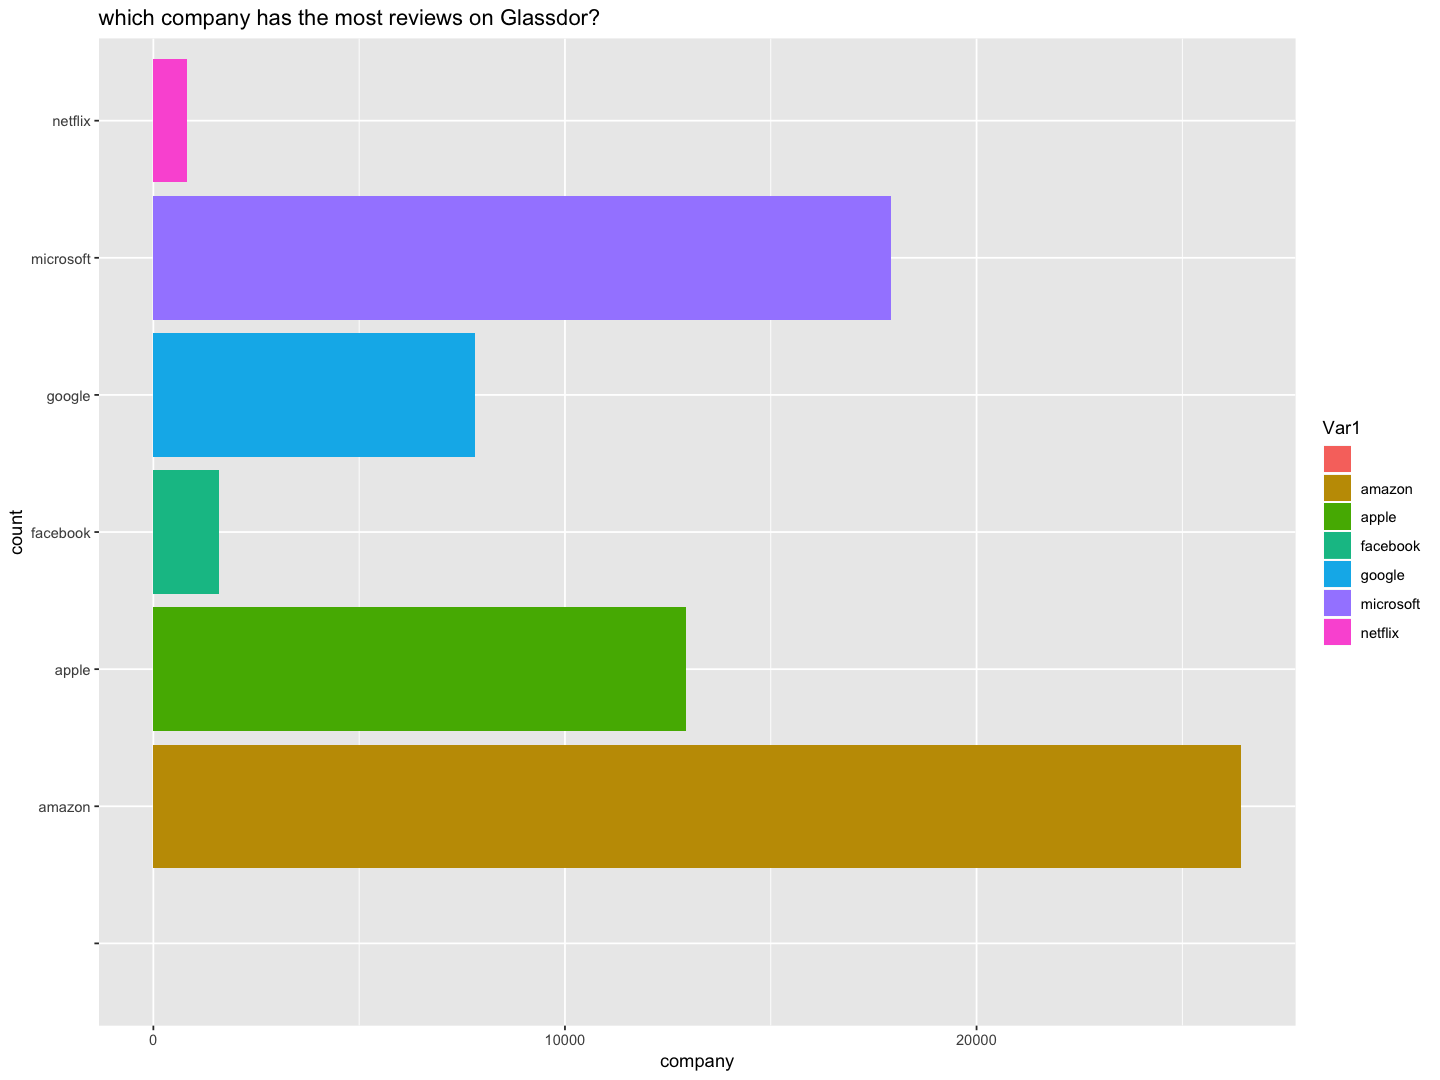

In [84]:
company <- as.data.frame(table(df$company))
company %>% 
    ggplot(aes(x = Var1, y = Freq, fill = Var1))+
    geom_bar(stat = 'identity') +
    coord_flip() +
    labs(x='count', y='company',title = 'which company has the most reviews on Glassdor?')

We can see from the visulization that Amazon has the largest amount of reviews - over 25,000, and Microsoft folollows as the second with less than 20,000. Then comes Apple. Netflix only has 810个reviews in this dataset.

**What are the top 10 job positions that contributed to the reviews?**

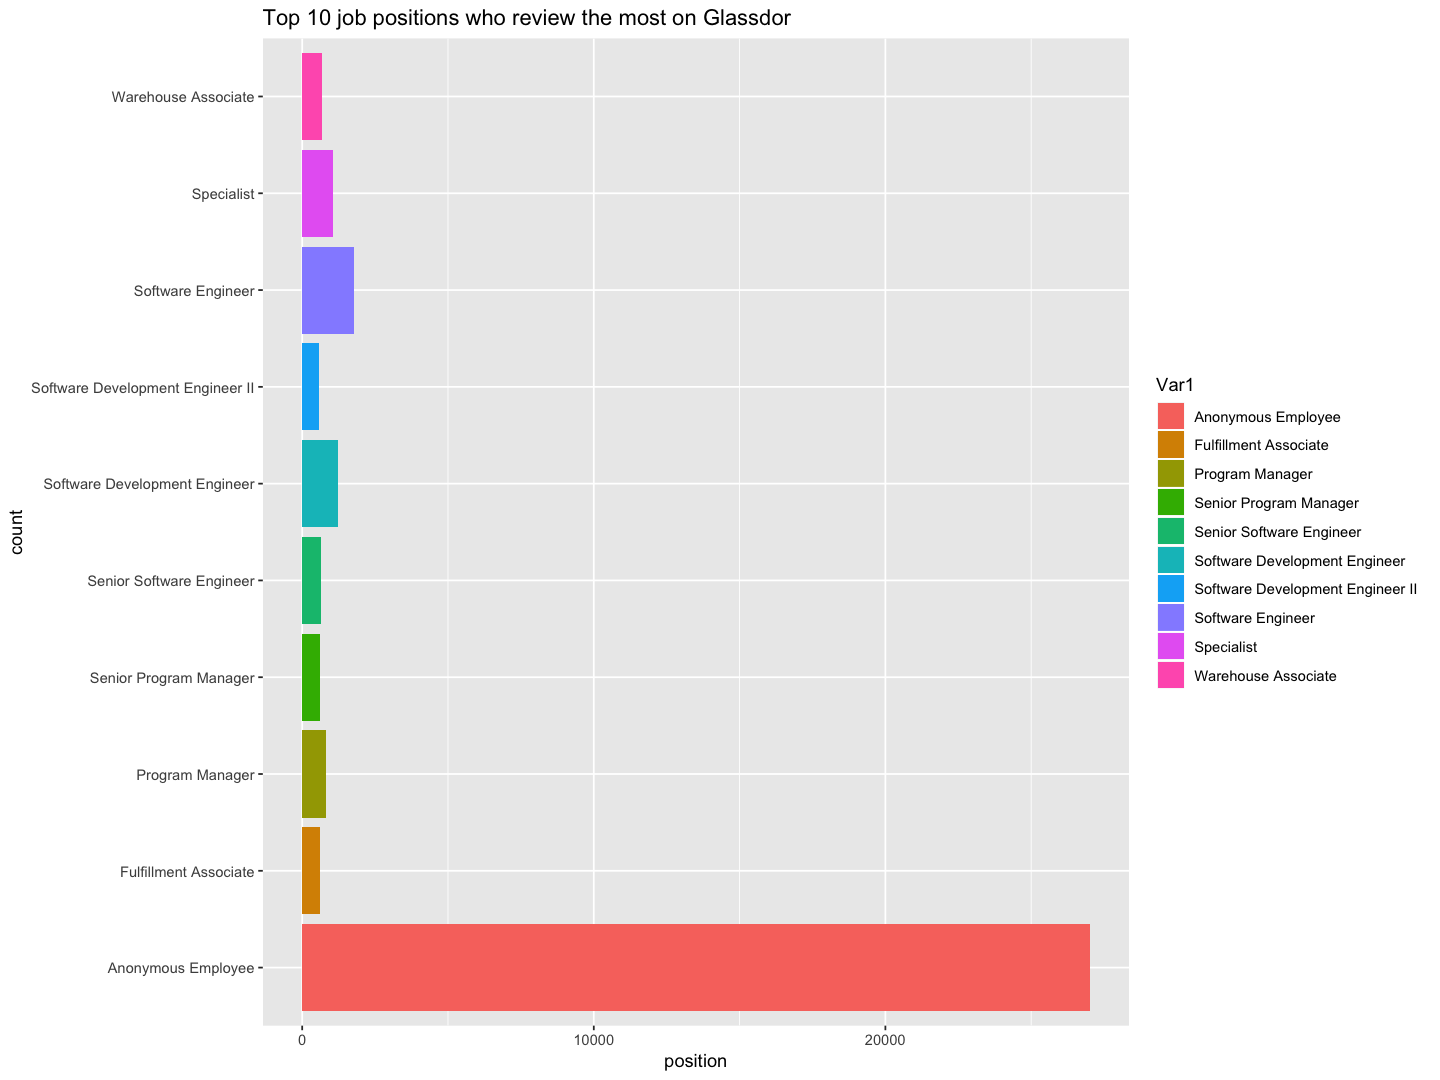

In [85]:
position = as.data.frame(table(df$position))
position = position[order(-position$Freq),]
head(position,10) %>% ggplot(aes(x=Var1,y=Freq,fill = Var1))+
    geom_bar(stat = 'identity') + 
    coord_flip() +labs(x='count', y='position',title = 'Top 10 job positions who review the most on Glassdor')

We can tell from the graph that 'Anonymous Employee'  acounts for the majority， then follows 'Software Engineer' and 'Software Development Engineer'. Appenrently employees tend not to reveal their identities when make a company review.

In [86]:
table(df$status)


Current Employee  Former Employee 
           42536            24988 

Also notice that formor employees take up 1/3 of the reviews while the current employees account for 2/3.

**What are the top 10 locations for employees who made reviews?**

In [87]:
location =as.data.frame(table(df$location))
location = location[order(-location$Freq),]
head(location,10)

Var1                 Freq 
1300 none                 25086
1519 Redmond, WA           5612
1665 Seattle, WA           4961
843  Hyderabad (India)     2150
1231 Mountain View, CA     1706
174  Bengaluru (India)     1607
466  Cupertino, CA         1291
1279 New York, NY          1152
1051 London, England (UK)   930
1144 Menlo Park, CA         805

Among theose who reveal their locations information, Seattle ranks the top location,two cities of which: Redmond and Seattle are on the list. The second state is California and New York. Outside of U.S., there are also two India locations. The list show worldwide popular places that are concentrated with big technology companies.

**What is the time range of the reviews in this dataset?**

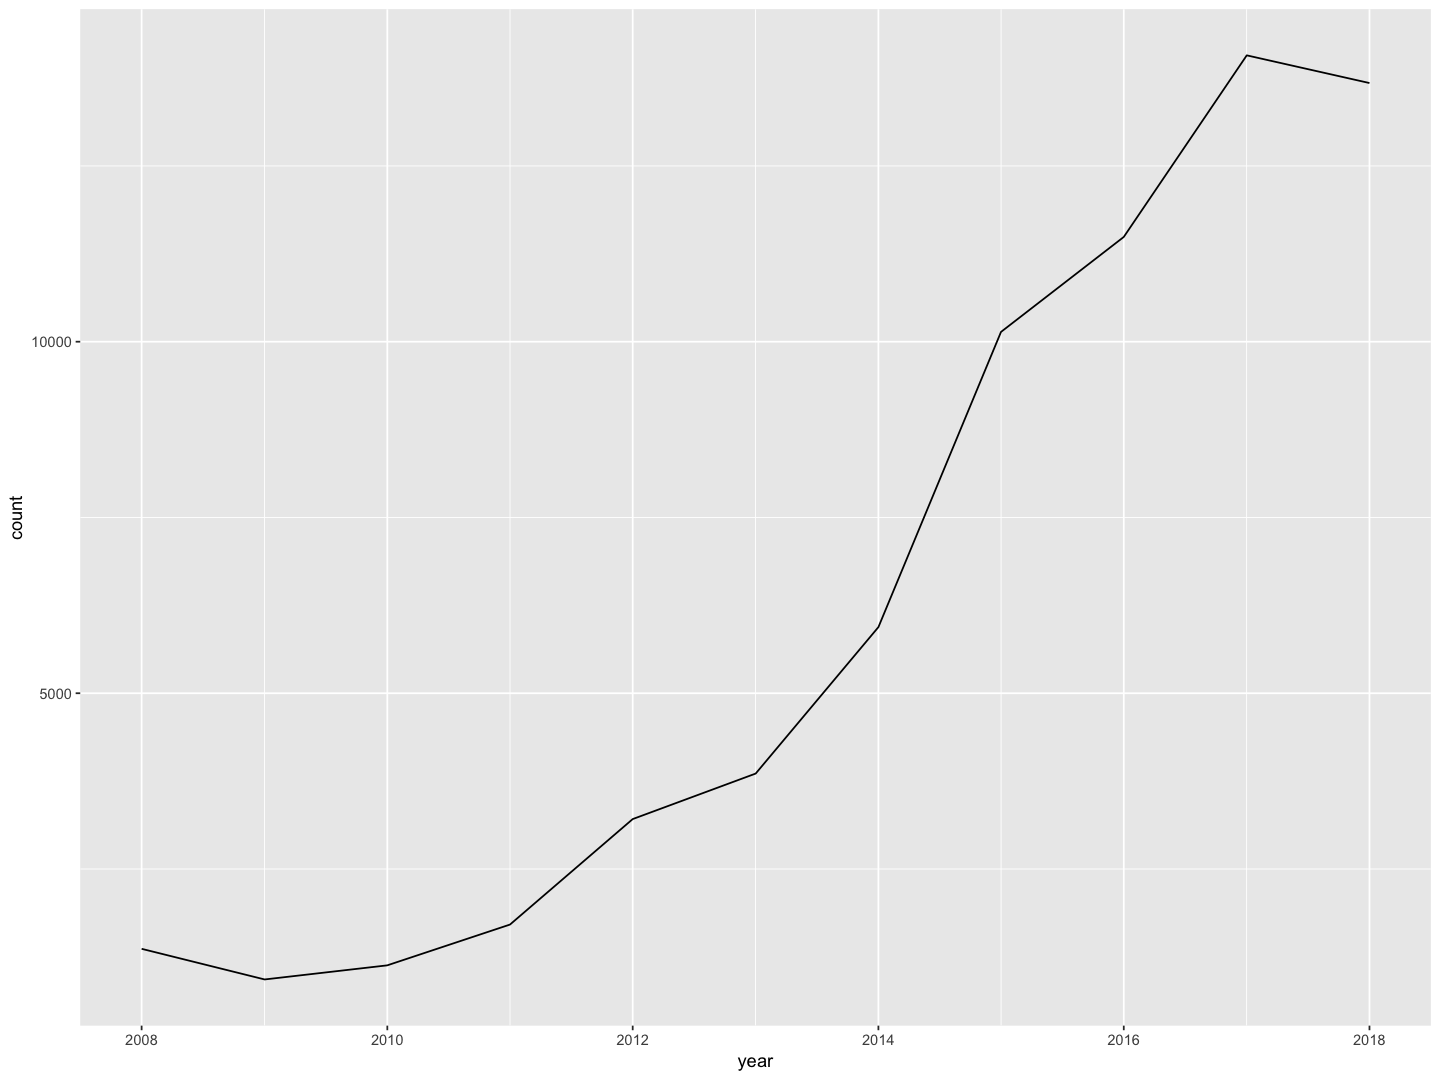

In [53]:
df %>% group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(count =n()) %>%
  ggplot(aes(x=year, y=count))+geom_line(stat='identity')

The dataset dates back to 2008 and continues to 2018, with a sharp increase in 2014. 
There are more than 10,000 reviews every year from 2015 to 2018.

### How different are these companies being rated?**

#### overall rating comparison by mean

In [88]:
p1 <- df %>%
    group_by(company) %>%
    summarize(avg_rating = mean(overall.ratings)) %>%
    ggplot(aes(x=company, y= avg_rating, fill =company)) + 
    geom_bar(stat="identity")+
    coord_flip()+
    labs(x = "", y = "", title = "Average Overall Rating")+
    geom_text(aes(y = avg_rating/2, label = round(avg_rating,2)))+
    theme(legend.position = "none")

#### work balance comparison by mean

In [89]:
p2 <- df %>%
    group_by(company) %>%
    summarize(avg_wbs = mean(work.balance.stars)) %>%
    ggplot(aes(x=company, y= avg_wbs, fill = company)) + 
    geom_bar(stat="identity")+coord_flip()+
    labs(x = "", y = "", title = "Average Work Balance Rating") +
    geom_text(aes(y = avg_wbs/2, label = round(avg_wbs,2)))+
    theme(legend.position = "none")

#### culture values comparison by mean

In [119]:
# culture values comparison (mean)
p3 <- df %>%
    group_by(company) %>%
    summarize(avg_cvs = mean(culture.values.stars)) %>%
    ggplot(aes(x=company, y= avg_cvs, fill = company)) + 
    geom_bar(stat="identity")+coord_flip()+
    labs(x = "", y = "", title = "Average Culture Values Rating")+
    geom_text(aes(y = avg_cvs/2, label = round(avg_cvs,2)))+
    theme(legend.position = "none")

#### career opportunities comparison by mean

In [120]:
p4 <- df %>%
    group_by(company) %>%
    summarize(avg_cos = mean(carrer.opportunities.stars)) %>%
    ggplot(aes(x=company, y= avg_cos, fill = company)) + 
    geom_bar(stat="identity")+coord_flip()+
    labs(x = "", y = "", title = "Average Carrer Opportunities Rating")+
    geom_text(aes(y = avg_cos/2, label = round(avg_cos,2)))+
    theme(legend.position = "none")

#### company benefits comparison by mean

In [121]:

p5<- df %>%
    group_by(company) %>%
    summarize(avg_cbs = mean(comp.benefit.stars)) %>%
    ggplot(aes(x=company, y= avg_cbs, fill = company)) + 
    geom_bar(stat="identity")+coord_flip()+ 
    labs(x = "", y = "", title = "Average Company Benefit Rating")+
    geom_text(aes(y = avg_cbs/2, label = round(avg_cbs,2)))+
    theme(legend.position = "none")

**senior management comparison by mean**

In [122]:
p6<- df %>%
    group_by(company) %>%
    summarize(avg_sms = mean(senior.mangemnet.stars)) %>%
    ggplot(aes(x=company, y= avg_sms, fill = company)) + 
    geom_bar(stat="identity")+
    coord_flip()+ 
    labs(x = "", y = "", title = "Average Senior Managment Rating")+
    geom_text(aes(y = avg_sms/2, label = round(avg_sms,2)))+
    theme(legend.position = "none")

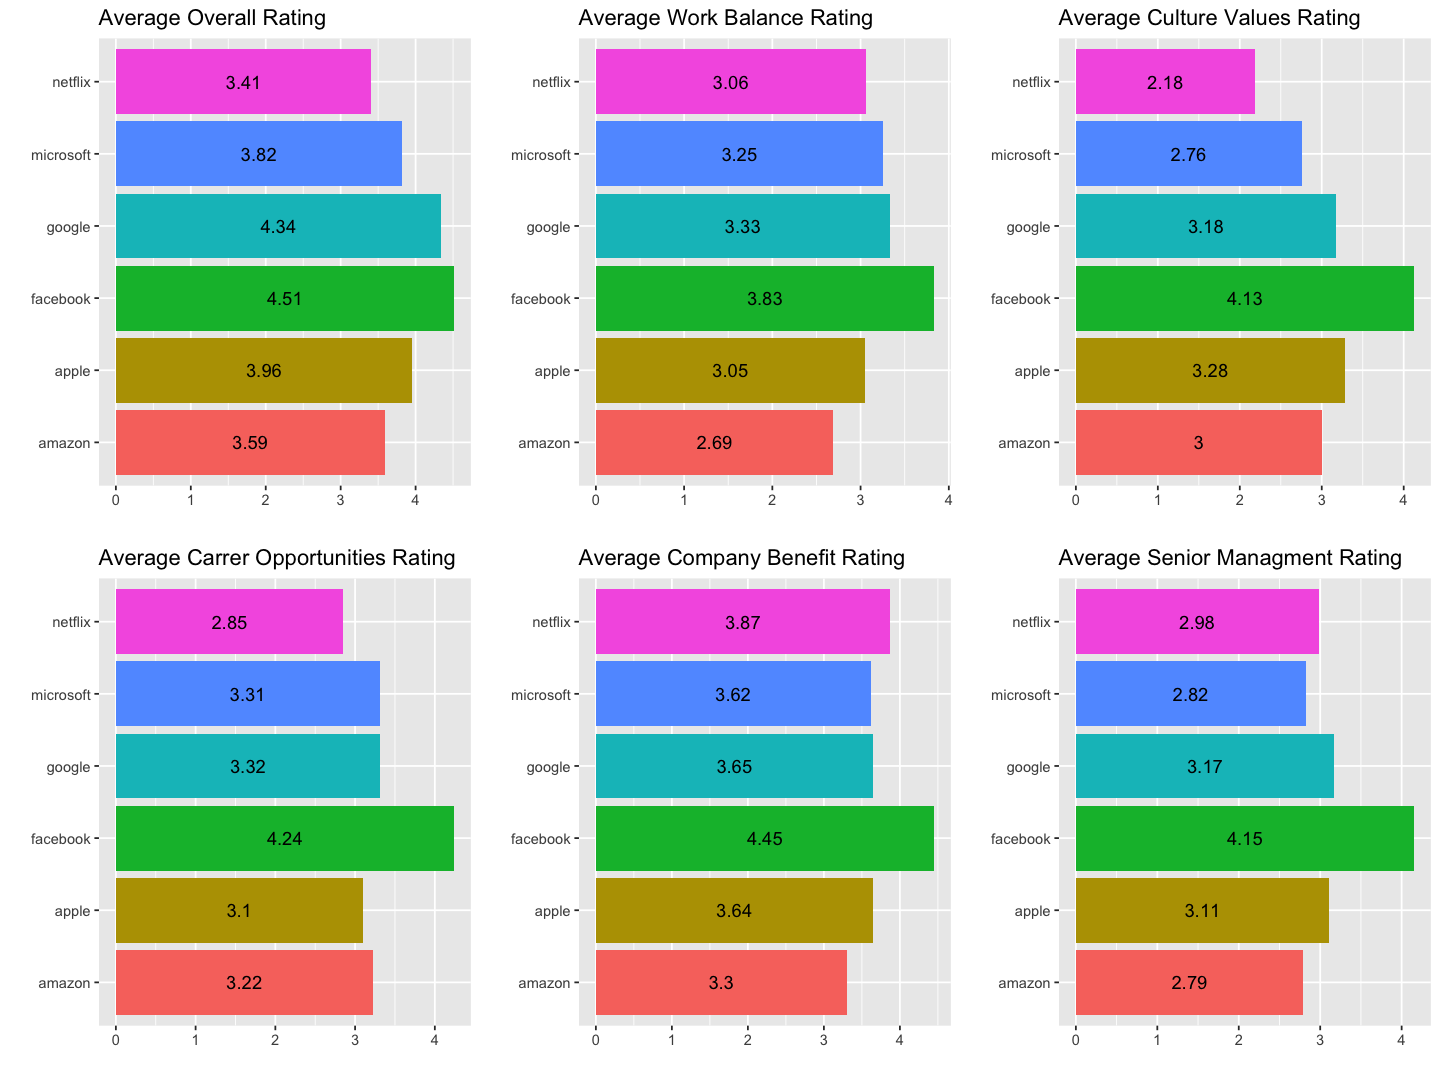

In [123]:
grid.arrange(p1, p2, p3, p4, p5, p6, ncol = 3)

**boxplot to compare employee's opion about the 6 aspects by each company**

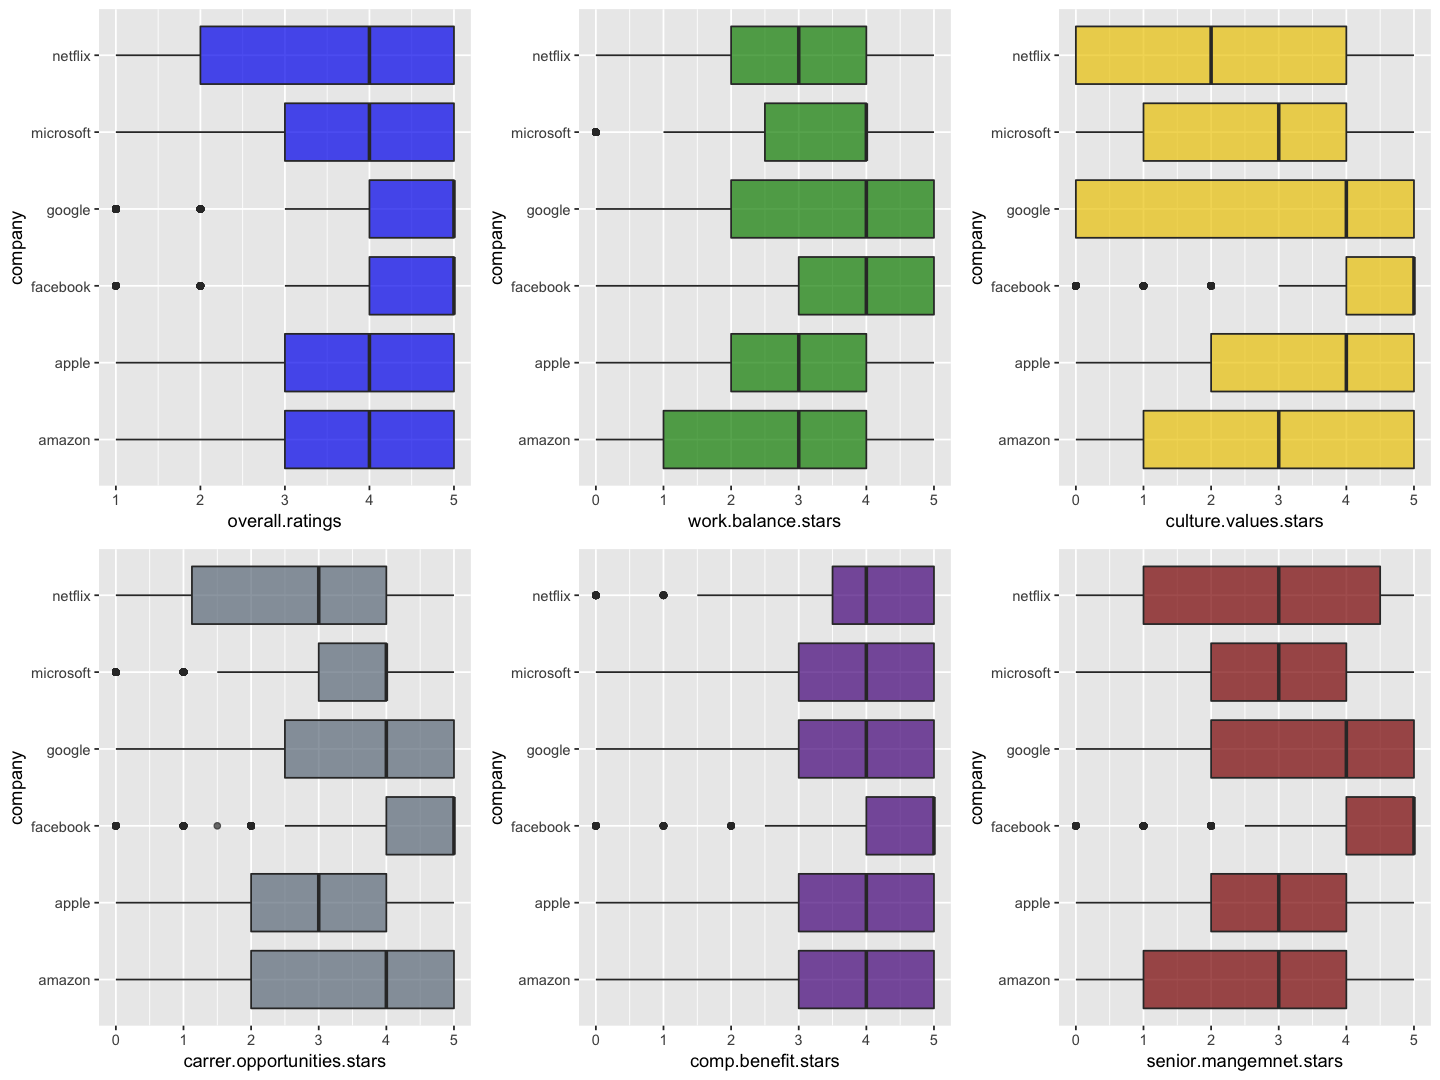

In [101]:
p7 <- ggplot(df, aes(x = company, y = overall.ratings)) +
  geom_boxplot( fill = "blue2", alpha = 0.7)+coord_flip()
p8 <- ggplot(df, aes(x = company, y = work.balance.stars)) +
  geom_boxplot( fill = "green4", alpha = 0.7)+coord_flip()
p9 <-ggplot(df, aes(x = company, y = culture.values.stars)) +
  geom_boxplot(fill = "gold2", alpha = 0.7)+coord_flip()
p10 <-ggplot(df, aes(x = company, y = carrer.opportunities.stars)) +
  geom_boxplot(fill = "slategray4", alpha = 0.7)+coord_flip()
p11 <-ggplot(df, aes(x = company, y = comp.benefit.stars)) +
  geom_boxplot(fill = "purple4", alpha = 0.7)+coord_flip()
p12 <-ggplot(df, aes(x = company, y = senior.mangemnet.stars)) +
  geom_boxplot(fill = "red4", alpha = 0.7)+coord_flip()

grid.arrange(p7, p8, p9, p10, p11, p12, ncol = 3)

**correlation plot of ratings**

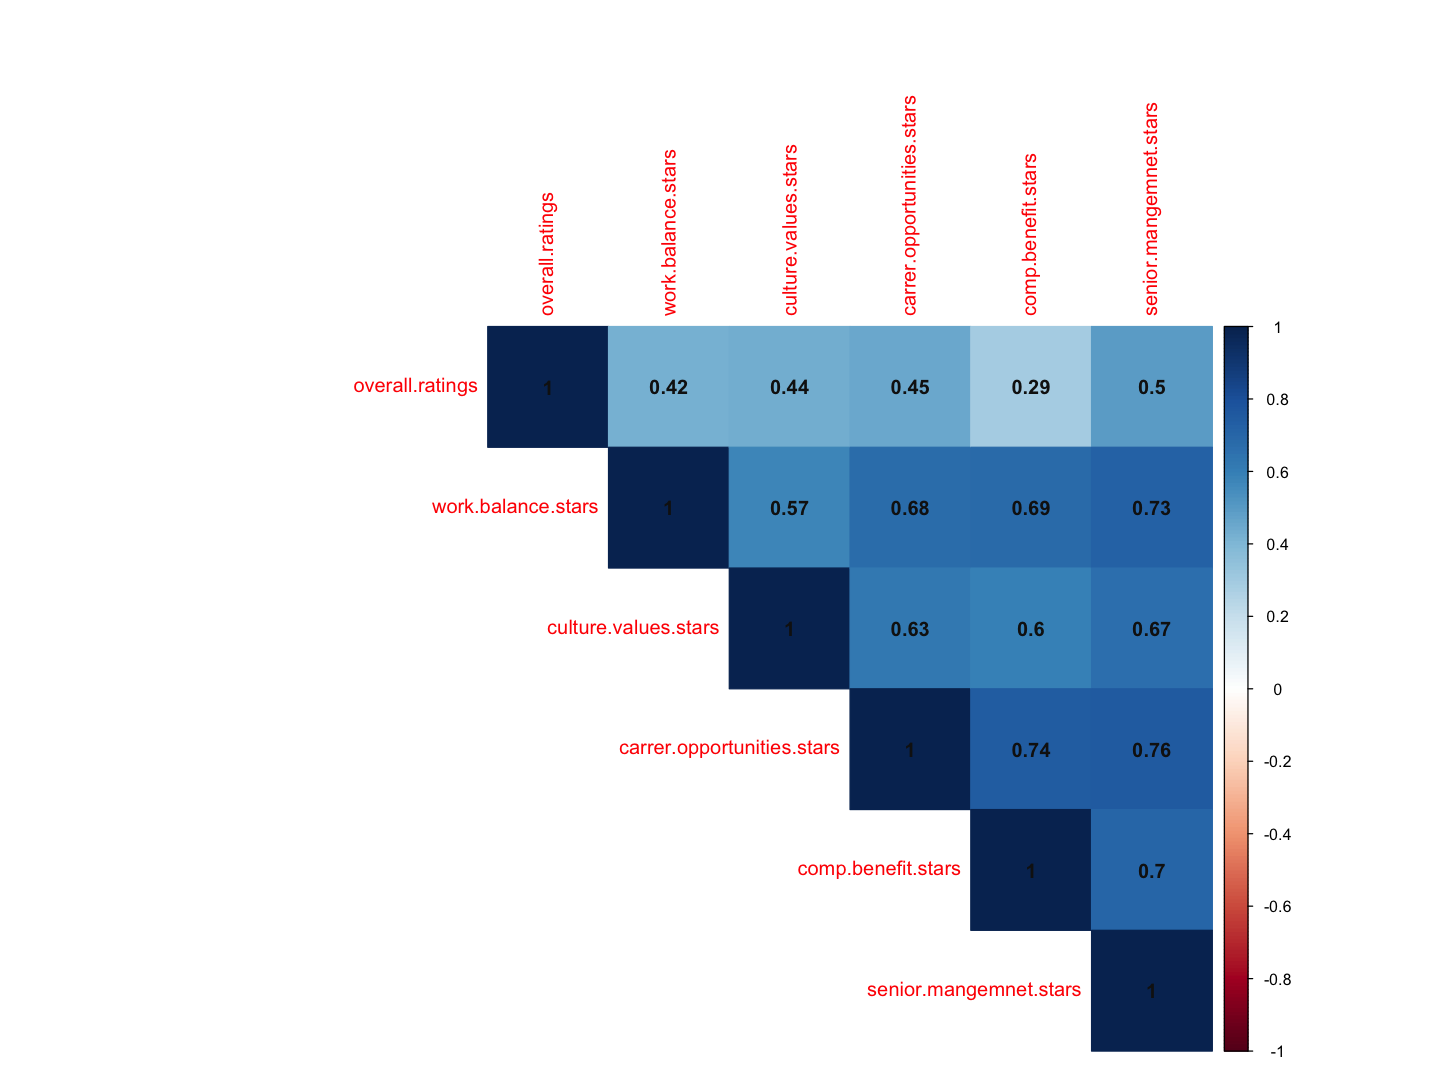

In [102]:
library(corrplot)

corrplot(cor(df[,9:14]),method='color',type='upper',addCoef.col = "gray8",diag = T)

From the correlation plot we can see that culture.values.stars and senior.management.stars have high positive correlations with the overall.ratings, with Pearson correlatiion coefficients above 0.70. It can work as an evidence that more effective employee motivations should emphasize to improve company cultures and senior management strategy.

## PART 3: TEXT MINING

**load packages**

In [104]:
options(warn=-1) #supress warnings
library(sentimentr)
library(tm)

### Clean the textual data

In [105]:
#create a function to remove messey contents
clean_text <- function(df_column){
    df_column <- df_column %>%
    str_remove_all("http.*") %>%
    str_remove_all("www.*") %>%
    str_remove_all("[^\x01-\x7F]") %>%
    removeNumbers() %>%
    tolower()
}

#apply function on string columns
df$summary = clean_text(df$summary)
df$pros = clean_text(df$pros)
df$cons = clean_text(df$cons)
df$advice.to.mgmt = clean_text(df$advice.to.mgmt)

### PART 3.1: Text Mining: Word Frequency
 on columns :
 - **'pros'** 
 - **'cons'** 


**calculate average number of characters in Pros for each company**

In [106]:
p13 <- df %>%
    group_by(company) %>%
    summarize(avg_char_pros = mean(nchar(pros))) %>%
    ggplot(aes(x=company, y= avg_char_pros, fill = company)) + 
    geom_bar(stat="identity")+
    coord_flip()+ 
    labs(x = "", y = "", title = "Average Number of Characters in Pros")+
    geom_text(aes( y = avg_char_pros/2,label = round(avg_char_pros,0)))

**calculate average number of characters in Cons for each company**

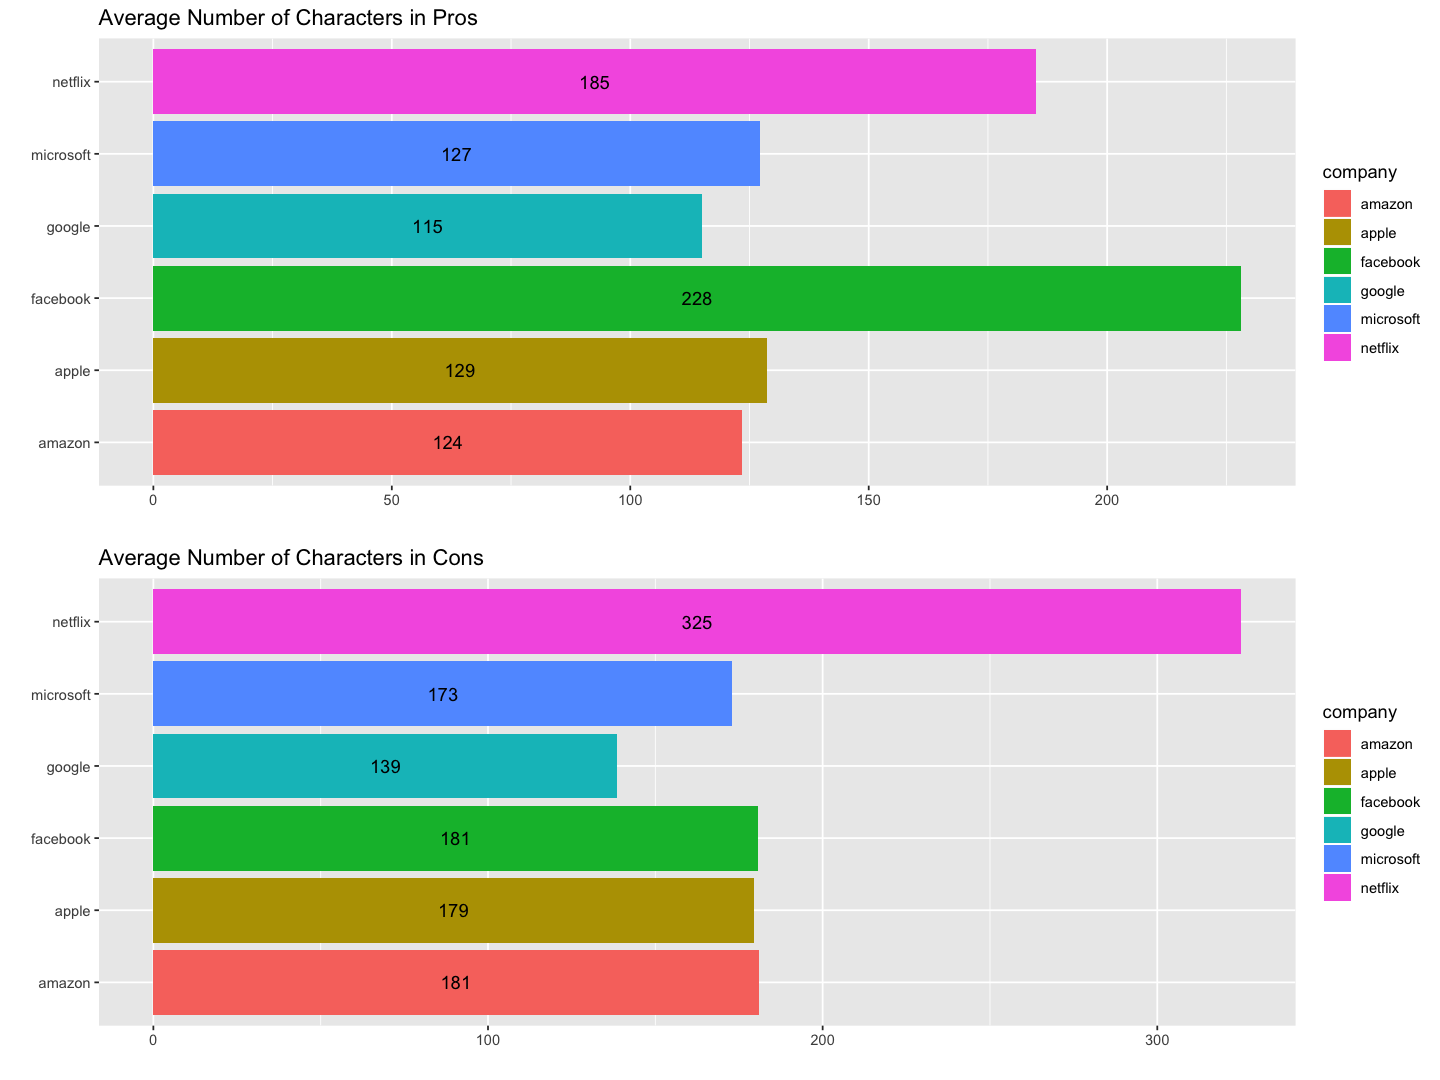

In [107]:
p14 <- df %>%
  group_by(company) %>%
  summarize(avg_char_cons = mean(nchar(cons))) %>%
  ggplot(aes(x=company, y= avg_char_cons, fill = company)) + geom_bar(stat="identity")+coord_flip()+ labs(x = "", y = "", title = "Average Number of Characters in Cons") +geom_text(aes(y = avg_char_cons/2, label = round(avg_char_cons,0)))

grid.arrange(p13,p14, ncol=1)

- Highest number of pros count: **Facebook**
- Highest number of cons: **Netflix**

### Character, Words and Sentences for all Reviews

Inspect review length (pros & cons) and ratings: **Are longer reviews associated with higher overall ratings?**

In [108]:
cor(nchar(df$pros),df$overall.ratings) 
cor(nchar(df$cons),df$overall.ratings)

[1] 0.04403859

[1] -0.2941833

No strong correaltions are showed, therefore longer reviews are not necessarily associated with higher overall ratings.

**Inspect number of words in pros and cons**

In [124]:
#words
summary(str_count(string= df$pros,pattern = '\\S+')) 
summary(str_count(string = df$cons,pattern = '\\S+')) 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2.00    7.00   13.00   21.35   25.00 1415.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     8.0    15.0    30.5    31.0  2163.0 

The average number of words include in pro and con are about 30. However, the longest pro has 1.4k words and the longest con has 2.1k words.

**Inspect number of sentences in pros and cons**

In [132]:
#sentence
summary(str_count(string = df$pros,pattern = "[A-Za-z,;'\"\\s]+[^.!?]*[.?!]"))
summary(str_count(string = df$cons,pattern = "[A-Za-z,;'\"\\s]+[^.!?]*[.?!]"))

longest_pro_index = which.max(str_count(string = df$pros,pattern = "[A-Za-z,;'\"\\s]+[^.!?]*[.?!]"))
longest_pro_index
#df$pros[longest_con_index]
longest_con_index = which.max(str_count(string = df$cons,pattern = "[A-Za-z,;'\"\\s]+[^.!?]*[.?!]"))
longest_con_index
#df$pros[longest_con_index]

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   1.000   1.442   2.000 101.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   1.000   1.827   2.000 103.000 

[1] 5

[1] 10848

**Most commmon words people used to describe their company: Which words are used most frequently in the reviews for each company?**

**Google TOP 10 frequent words**

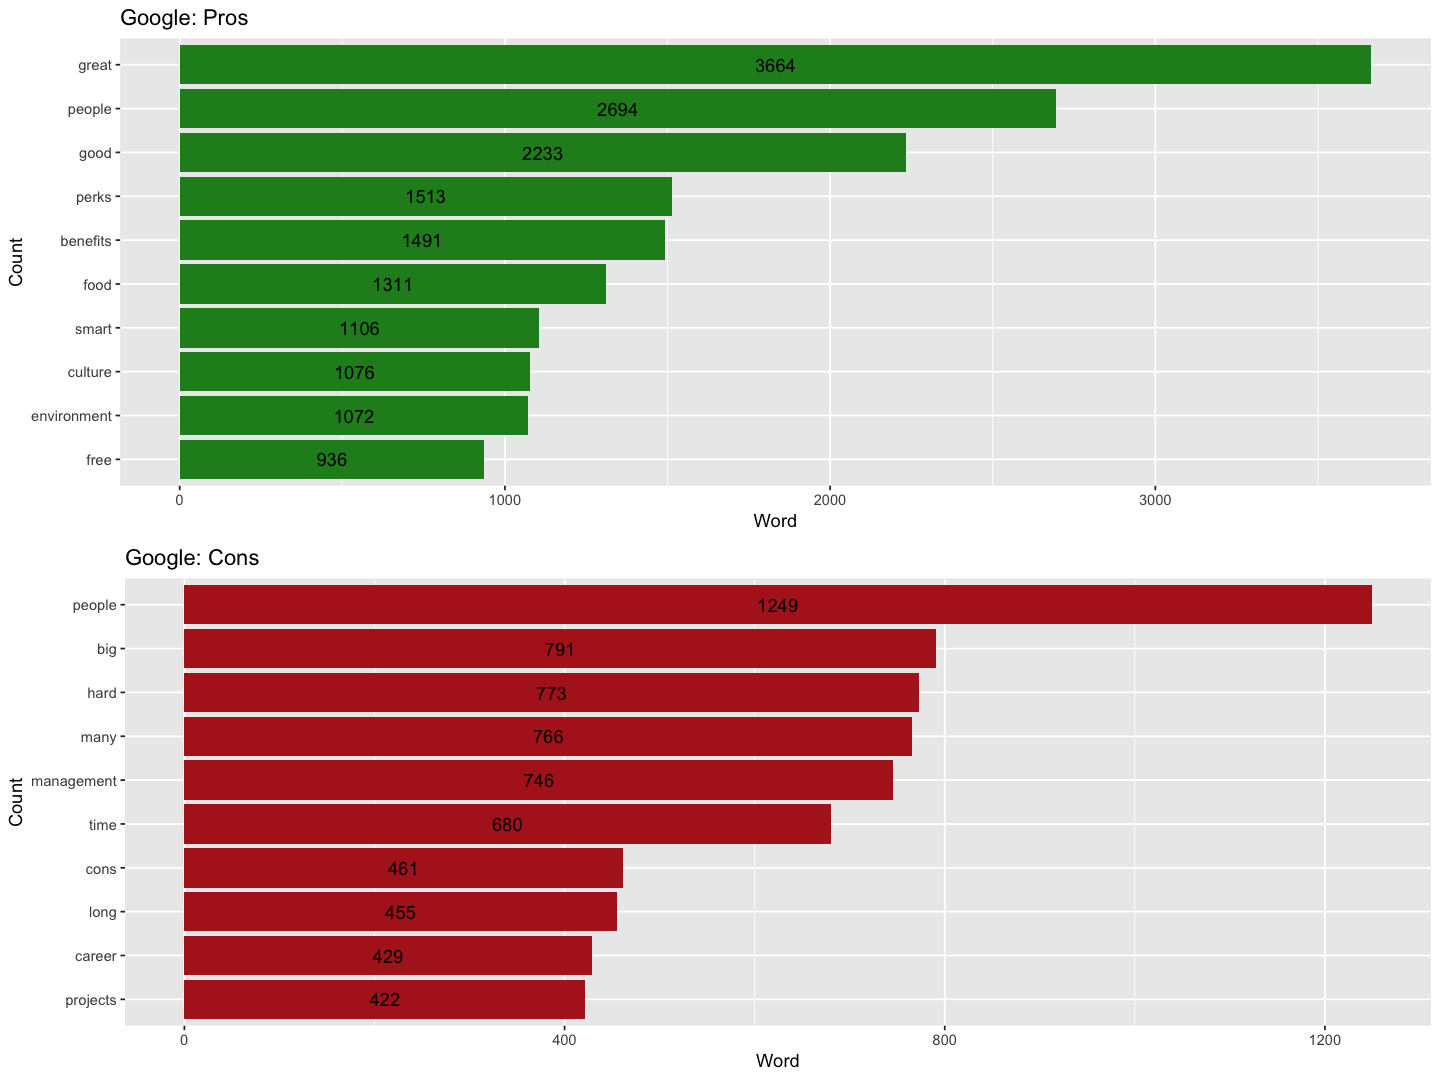

In [126]:
#First use the tm package's traditional English stop words, then add other unvaluable stopwords from the result.
gg_pros_words <- as.data.frame(freq_terms(text.var=df_gg$pros,top=100,stopwords =c(tm::stopwords("english"), "work","google","company","job","can","get","lot","working")))
gg_cons_words <- as.data.frame(freq_terms(text.var=df_gg$cons,top=100,stopwords =c (tm::stopwords("english"),"work","google","company","can","get","much","really","lot","good","sometimes","will","like","job","working")))

p15 <- gg_pros_words %>% slice(1:10) %>% ggplot(aes(x=reorder(WORD,+ FREQ), y=FREQ))+geom_bar(stat="identity",fill = "forestgreen")+ labs(x = "Count", y = "Word", title = "Google: Pros")+coord_flip()+geom_text(aes(y = FREQ/2,label = round(FREQ,0)))
p16 <-gg_cons_words %>% slice(1:10) %>% ggplot(aes(x=reorder(WORD,+FREQ),y=FREQ))+geom_bar(stat="identity",fill = "firebrick")+ labs(x = "Count", y = "Word", title = "Google: Cons")+coord_flip()+geom_text(aes(y = FREQ/2,label = round(FREQ,0)))

grid.arrange(p15,p16, ncol=1)

**Amazon TOP 10 frequent words**

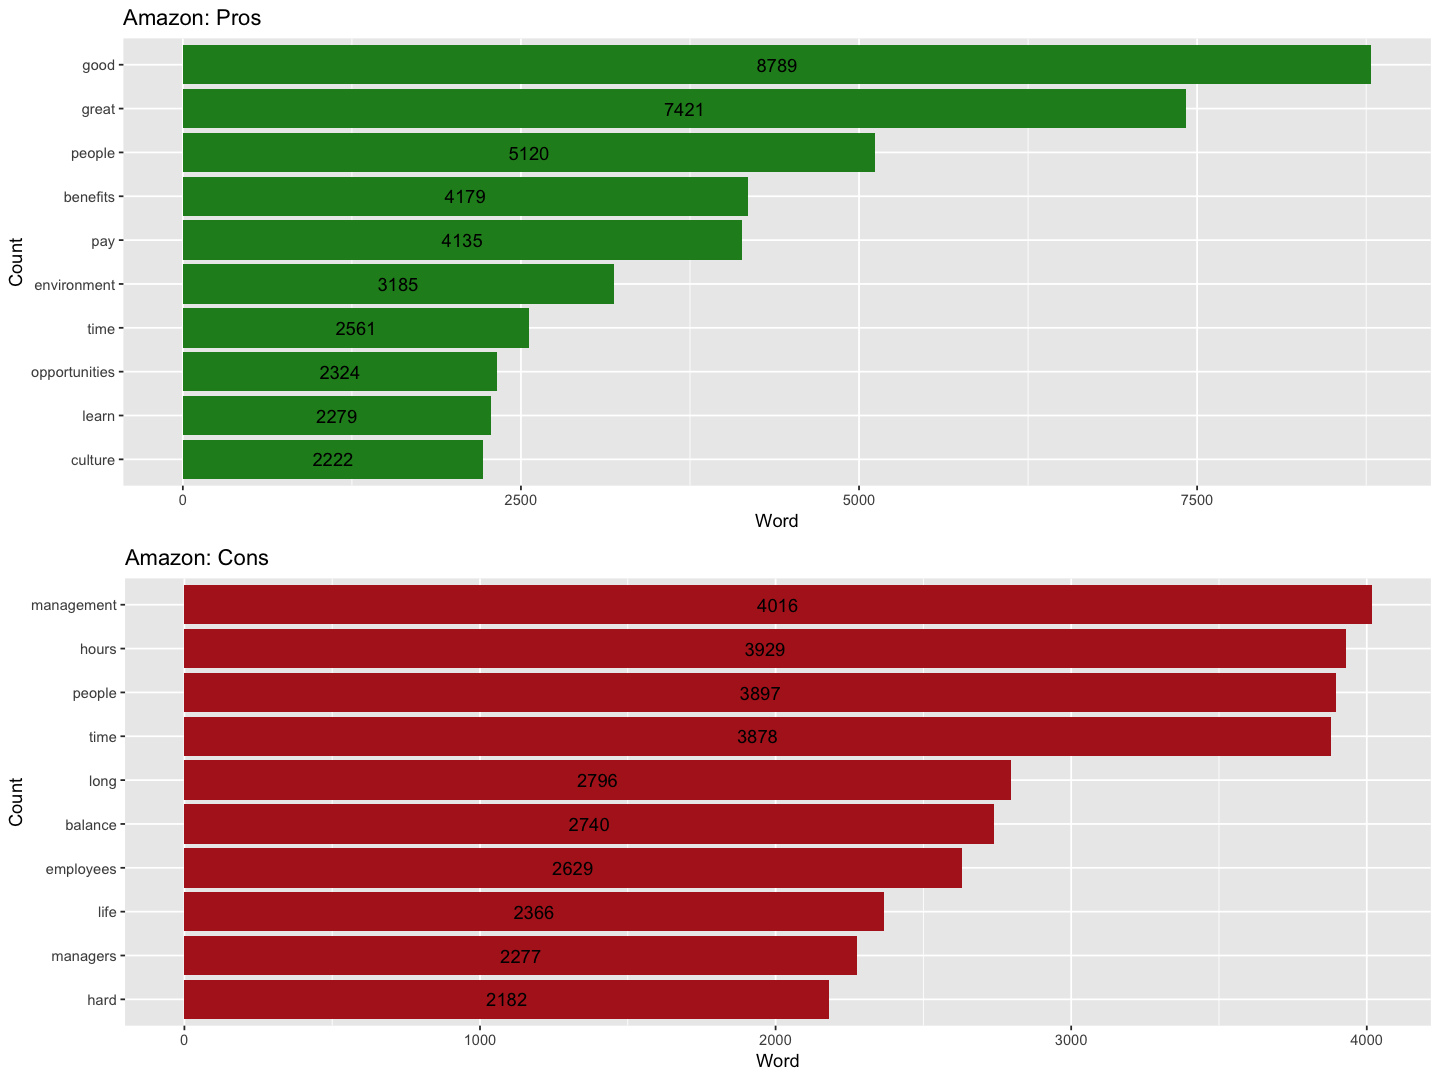

In [128]:
amz_pros_words <- as.data.frame(freq_terms(text.var=df_amz$pros,top=100,stopwords = c(tm::stopwords("english"), "work","amazon","company","job","can","get","lot","working")))
amz_cons_words <- as.data.frame(freq_terms(text.var=df_amz$cons,top=100,stopwords = c(tm::stopwords("english"), "work","amazon","company","can","get","much","really","lot","good","sometimes","will","like","job","working")))

p17 <- amz_pros_words %>% slice(1:10) %>% ggplot( aes(x=reorder(WORD,+FREQ),y=FREQ))+geom_bar(stat="identity",fill = "forestgreen")+ labs(x = "Count", y = "Word", title = "Amazon: Pros")+coord_flip()+geom_text(aes(y = FREQ/2,label = round(FREQ,0)))
p18 <- amz_cons_words %>% slice(1:10) %>% ggplot(aes(x=reorder(WORD,+FREQ),y=FREQ))+geom_bar(stat="identity",fill = "firebrick")+ labs(x = "Count", y = "Word", title = "Amazon: Cons")+coord_flip()+geom_text(aes(y = FREQ/2,label = round(FREQ,0)))

grid.arrange(p17,p18, ncol=1)

**Apple TOP 10 frequent words**

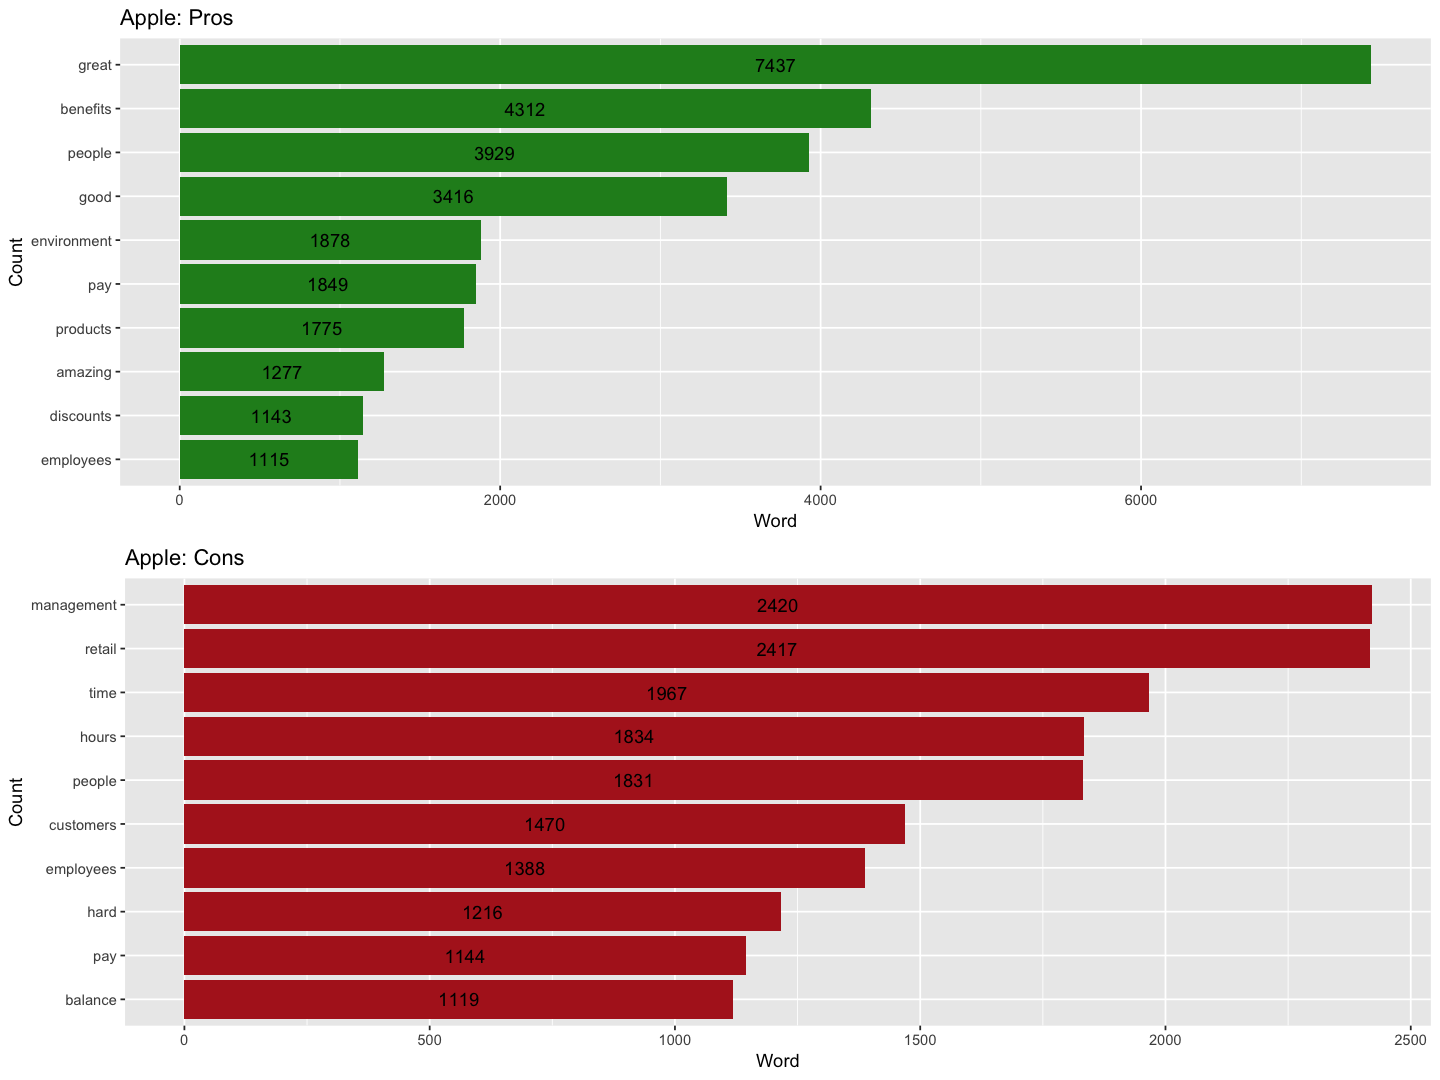

In [129]:
apl_pros_words <- as.data.frame(freq_terms(text.var=df_apl$pros,top=100,stopwords =c(tm::stopwords("english"), "work","apple","company","job","can","get","lot","working")))
apl_cons_words <- as.data.frame(freq_terms(text.var=df_apl$cons,top=100,stopwords = c(tm::stopwords("english"), "work","apple","company","can","get","much","really","lot","good","sometimes","will","like","job","working")))

p19 <- apl_pros_words %>% slice(1:10) %>% ggplot(aes(x=reorder(WORD,+FREQ),y=FREQ))+geom_bar(stat="identity",fill = "forestgreen")+ labs(x = "Count", y = "Word", title = "Apple: Pros")+coord_flip()+geom_text(aes(y = FREQ/2,label = round(FREQ,0)))
p20 <- apl_cons_words %>% slice(1:10) %>% ggplot(aes(x=reorder(WORD,+FREQ),y=FREQ))+geom_bar(stat="identity",fill = "firebrick")+ labs(x = "Count", y = "Word", title = "Apple: Cons")+coord_flip()+geom_text(aes(y = FREQ/2,label = round(FREQ,0)))

grid.arrange(p19,p20, ncol=1)

**FACEBOOK TOP 10 frequent words**

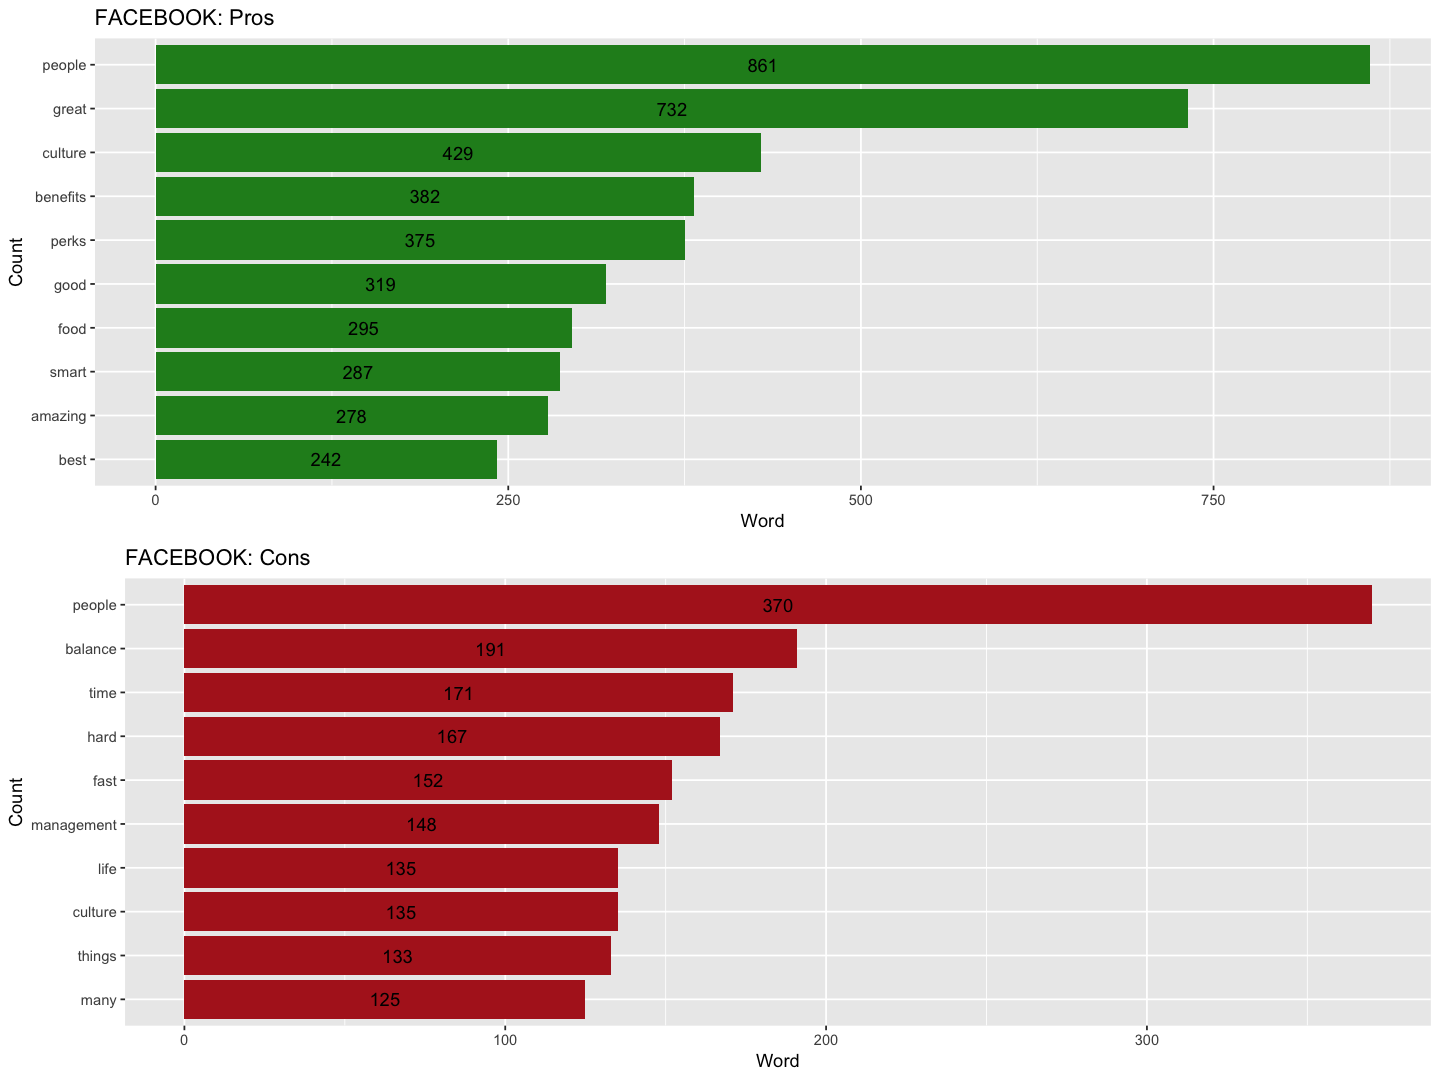

In [130]:
fb_pros_words <- as.data.frame(freq_terms(text.var=df_fb$pros,top=100,stopwords = c(tm::stopwords("english"), "work","facebook","company","job","can","get","lot","working","really")))
fb_cons_words <- as.data.frame(freq_terms(text.var=df_fb$cons,top=100,stopwords = c(tm::stopwords("english"), "work","facebook","company","can","get","much","really","lot","good","sometimes","will","like","job","working")))

p21 <-fb_pros_words %>% slice(1:10) %>% ggplot(aes(x=reorder(WORD,+ FREQ), y=FREQ))+geom_bar(stat="identity",fill = "forestgreen")+ labs(x = "Count", y = "Word", title = "FACEBOOK: Pros")+coord_flip()+geom_text(aes(y = FREQ/2,label = round(FREQ,0)))

p22 <-fb_cons_words %>% slice(1:10) %>%ggplot( aes(x=reorder(WORD,+ FREQ), y=FREQ))+geom_bar(stat="identity",fill = "firebrick")+ labs(x = "Count", y = "Word", title = "FACEBOOK: Cons")+coord_flip()+geom_text(aes(y = FREQ/2,label = round(FREQ,0)))

grid.arrange(p21,p22, ncol=1)

**Microsoft TOP 10 frequent words**

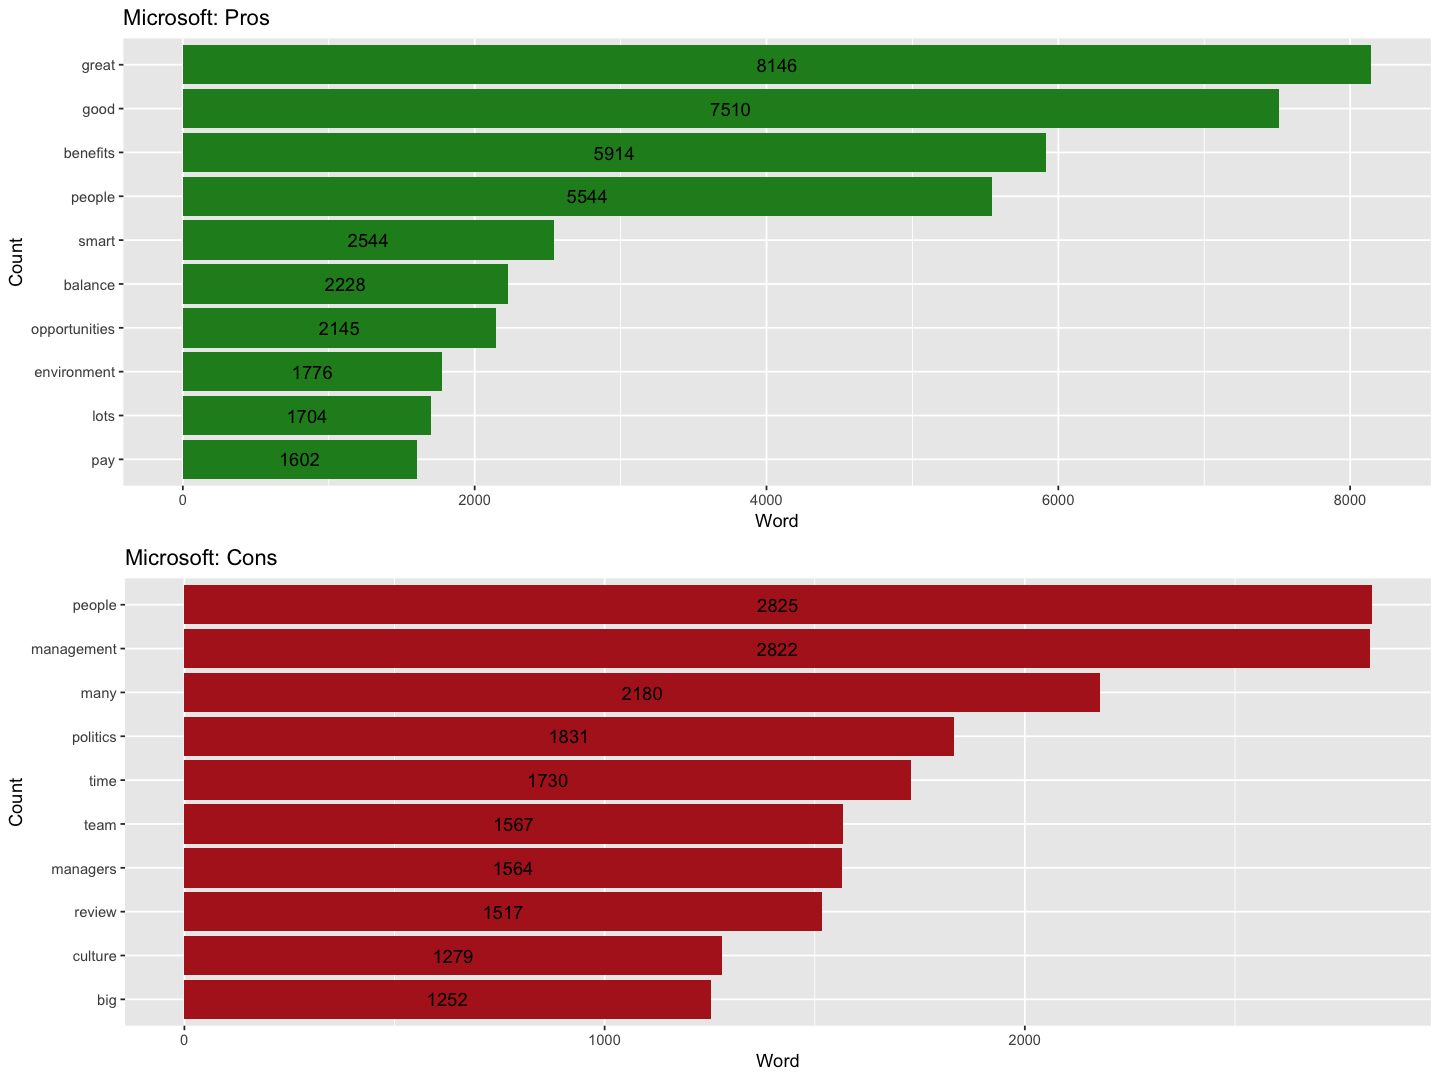

In [131]:
ms_pros_words <- as.data.frame(freq_terms(text.var=df_ms$pros,top=100,stopwords = c(tm::stopwords("english"), "work","microsoft","company","job","can","get","lot","working","really")))
ms_cons_words <- as.data.frame(freq_terms(text.var=df_ms$cons,top=100,stopwords = c(tm::stopwords("english"), "work","microsoft","company","can","get","much","really","lot","good","sometimes","will","like","job","working")))


p23 <- ms_pros_words %>% slice(1:10) %>% ggplot(aes(x=reorder(WORD,+ FREQ), y=FREQ))+geom_bar(stat="identity",fill = "forestgreen")+ labs(x = "Count", y = "Word", title = "Microsoft: Pros")+coord_flip()+geom_text(aes(y = FREQ/2,label = round(FREQ,0)))

p24 <- ms_cons_words %>% slice(1:10) %>% ggplot(aes(x=reorder(WORD,+ FREQ), y=FREQ))+geom_bar(stat="identity",fill = "firebrick")+ labs(x = "Count", y = "Word", title = "Microsoft: Cons")+coord_flip()+geom_text(aes(y = FREQ/2,label = round(FREQ,0)))

grid.arrange(p23,p24, ncol=1)

**Netflix TOP 10 frequent words**

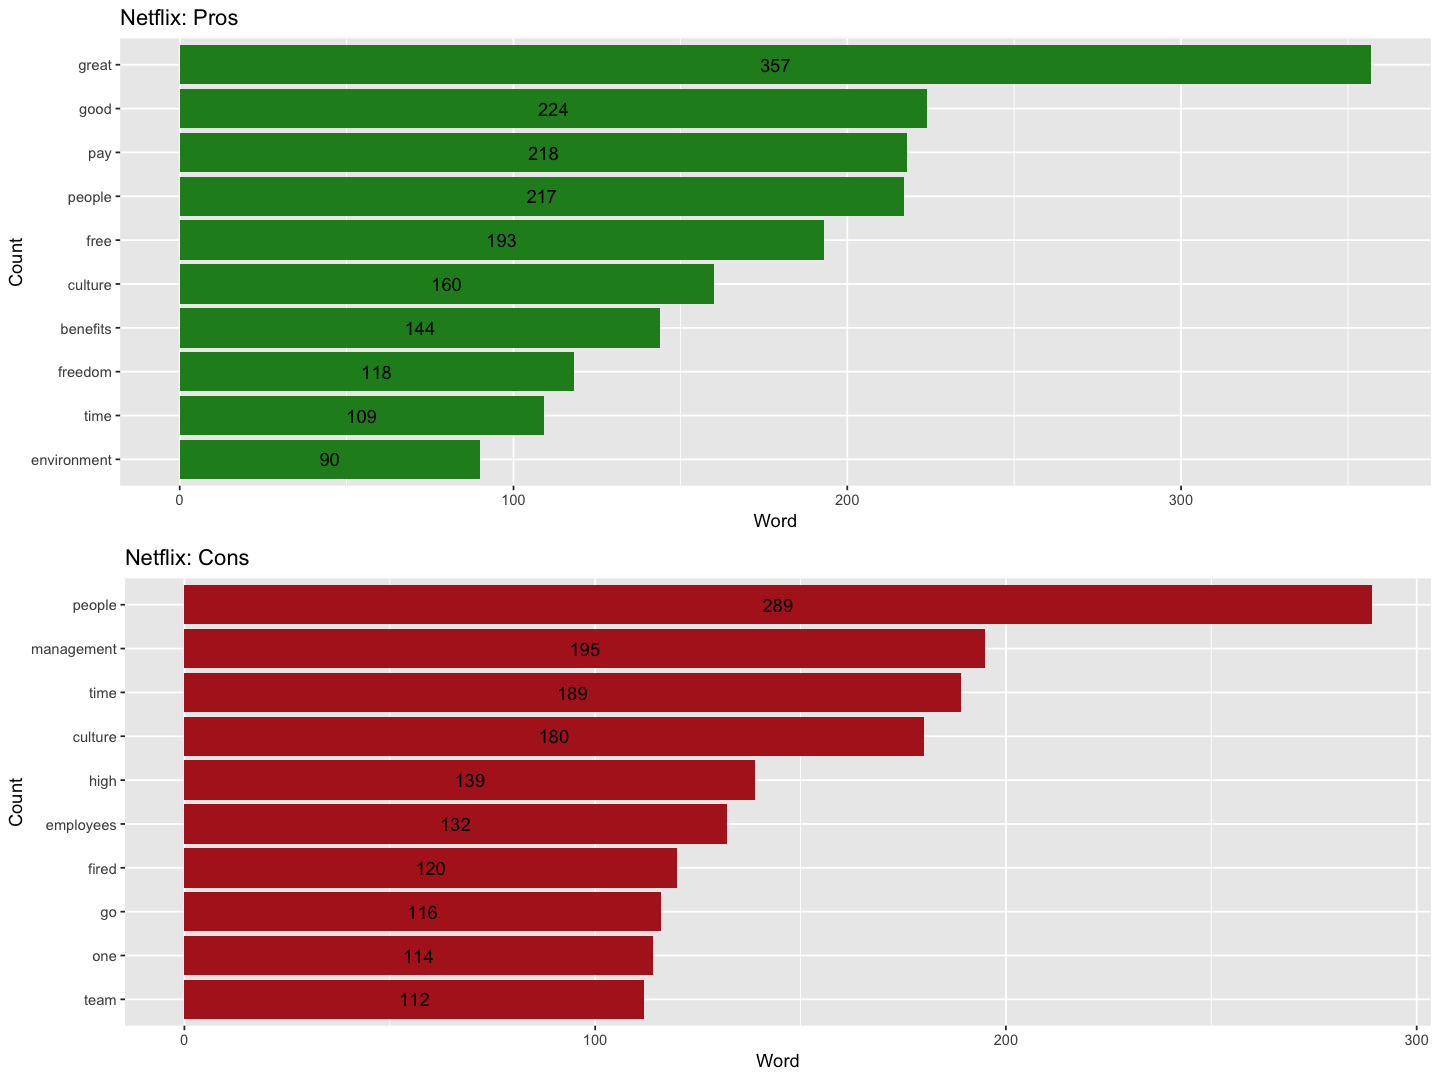

In [133]:
nf_pros_words <- as.data.frame(freq_terms(text.var=df_nf$pros,top=100,stopwords = c(tm::stopwords("english"), "work","netflix","company","job","can","get","lot","working","really")))
nf_cons_words <- as.data.frame(freq_terms(text.var=df_nf$cons,top=100,stopwords = c(tm::stopwords("english"), "work","netflix","company","can","get","much","really","lot","good","sometimes","will","like","job","working")))

p25 <- nf_pros_words %>% slice(1:10) %>% ggplot(aes(x=reorder(WORD,+ FREQ), y=FREQ))+geom_bar(stat="identity",fill = "forestgreen")+ labs(x = "Count", y = "Word", title = "Netflix: Pros")+coord_flip()+geom_text(aes(y = FREQ/2,label = round(FREQ,0)))

p26 <- nf_cons_words %>% slice(1:10) %>%ggplot(aes(x=reorder(WORD,+ FREQ), y=FREQ))+geom_bar(stat="identity",fill = "firebrick")+ labs(x = "Count", y = "Word", title = "Netflix: Cons")+coord_flip()+geom_text(aes(y = FREQ/2,label = round(FREQ,0)))

grid.arrange(p25,p26, ncol=1)

### WordcloudData to visulize the word frequency

In [134]:
#WordcloudData to visulize the word frequency
library(wordcloud)
library(tidytext)

**Wordcloud for Google pros and cons**

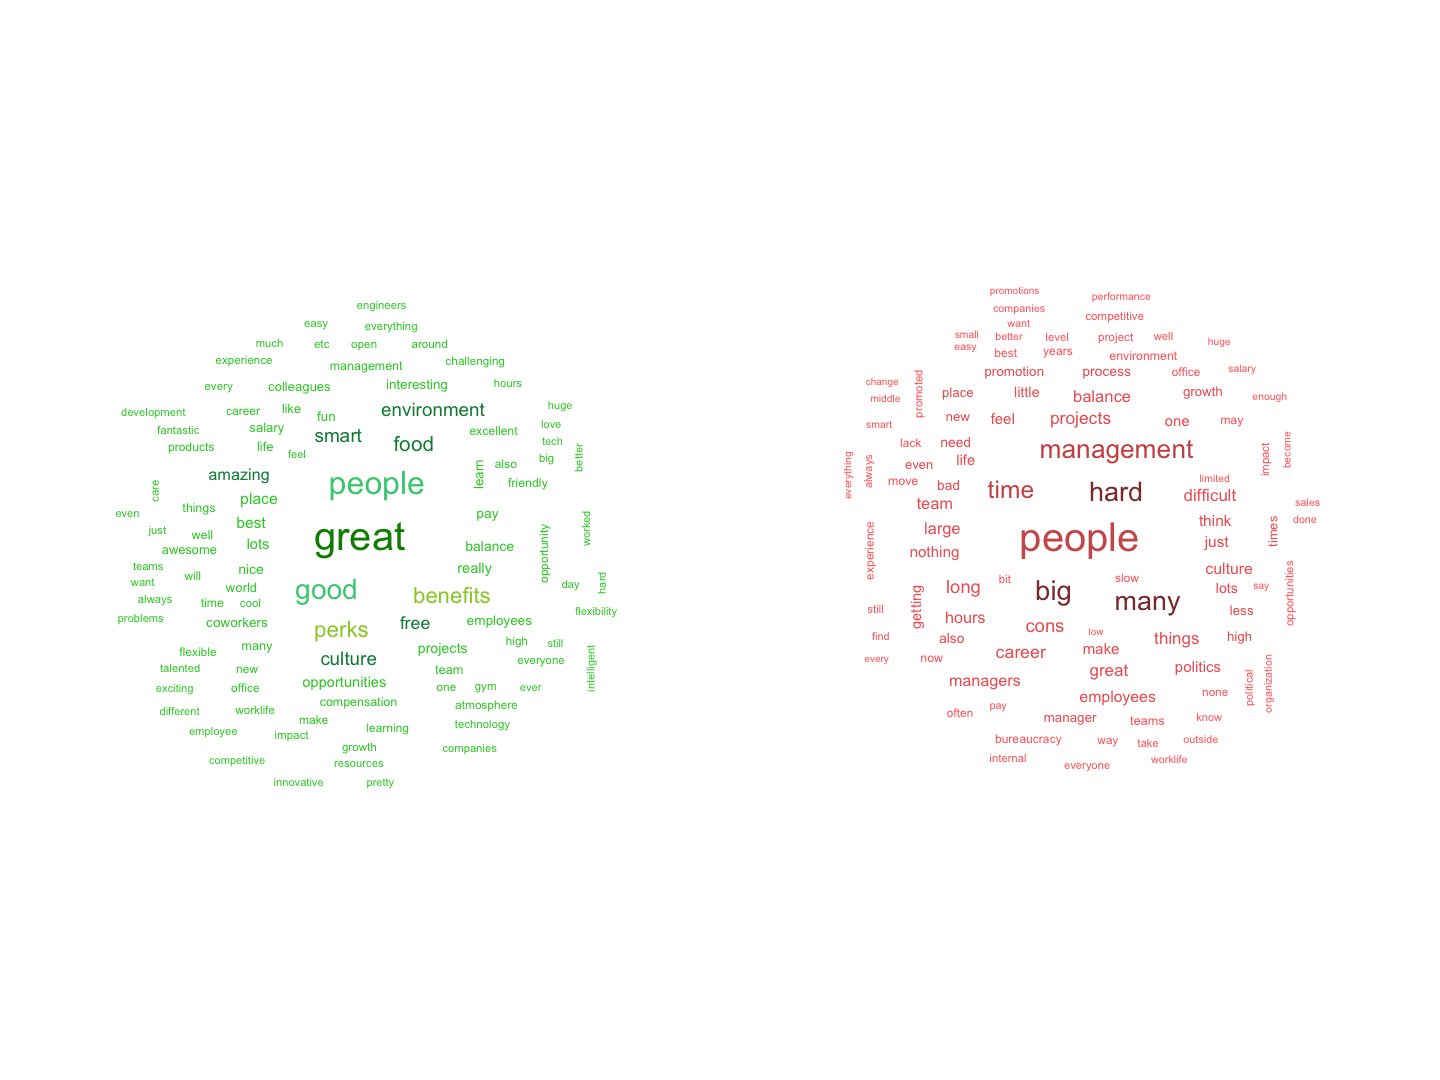

In [135]:
par(mfrow=c(1,2),mar=c(0,0,0,0))
wordcloud(gg_pros_words$WORD,gg_pros_words$FREQ,scale=c(2,0.5),random.order = FALSE,colors=c("limegreen","springgreen4","yellowgreen","seagreen3","green4"))
wordcloud(gg_cons_words$WORD,gg_cons_words$FREQ,scale=c(2,0.3),random.order = FALSE,colors=c("indianred1","indianred2","indianred3","indianred4","indianred"))

**Wordcloud for Amazon pros and cons**

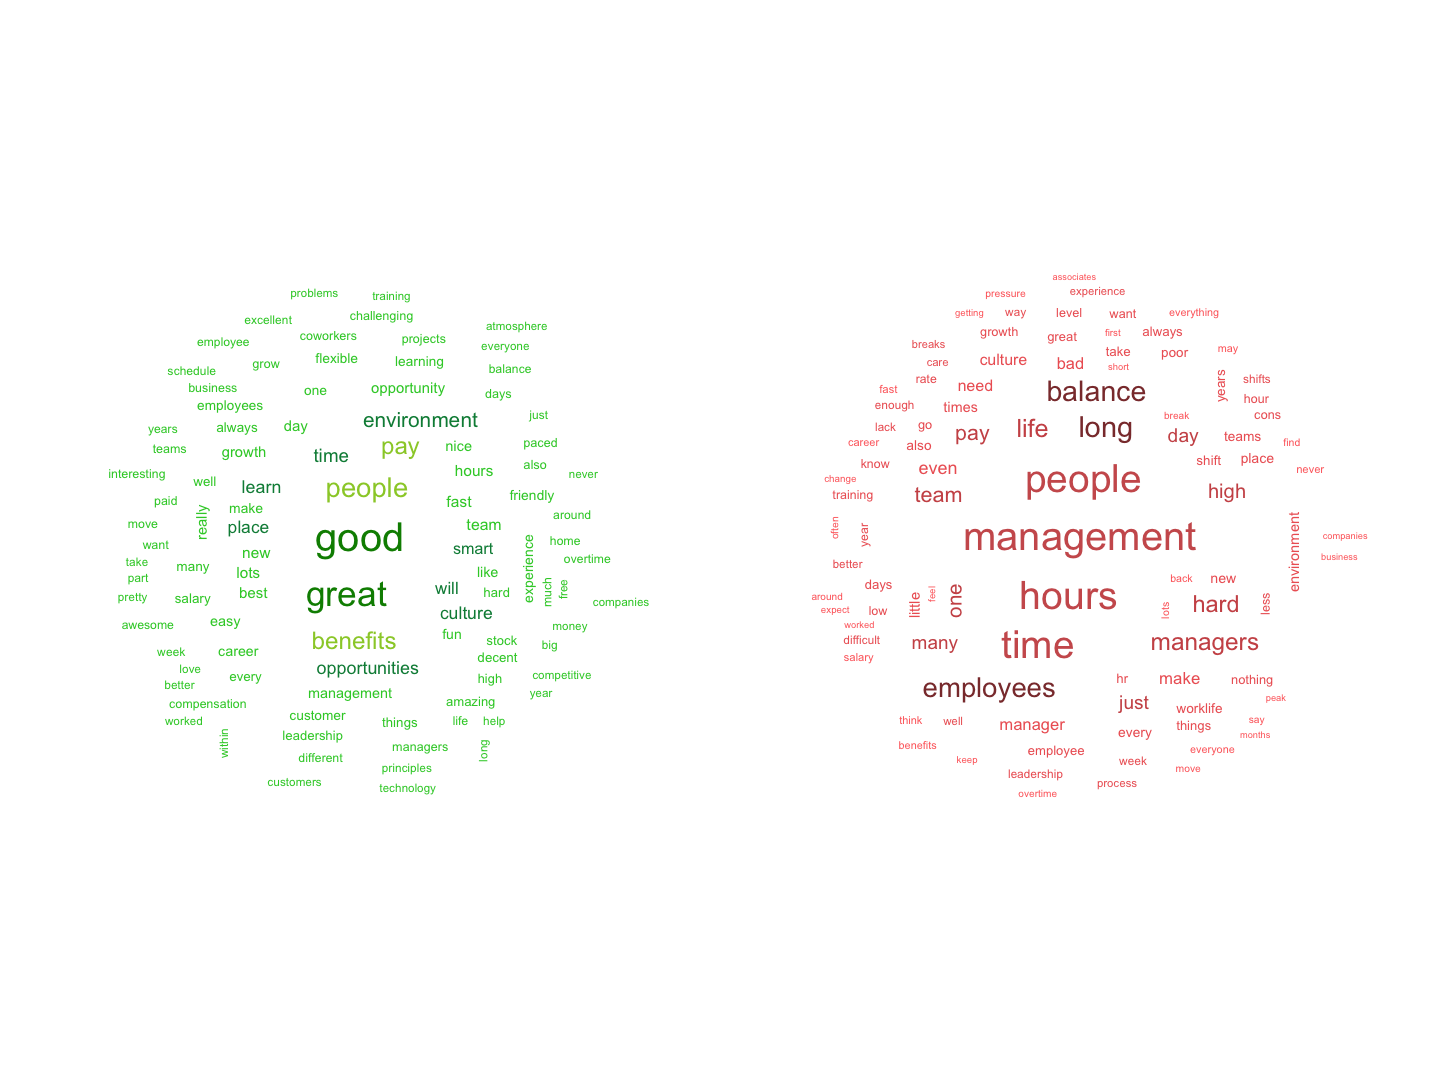

In [136]:
par(mfrow=c(1,2),mar = c(0, 0,0,0))
wordcloud(amz_pros_words$WORD,amz_pros_words$FREQ,scale=c(2,0.5),random.order = FALSE,colors=c("limegreen","springgreen4","yellowgreen","seagreen3","green4"))
wordcloud(amz_cons_words$WORD,amz_cons_words$FREQ,scale=c(2,0.2),random.order = FALSE,colors=c("indianred1","indianred2","indianred3","indianred4","indianred"))

**Wordcloud for Apple pros and cons**

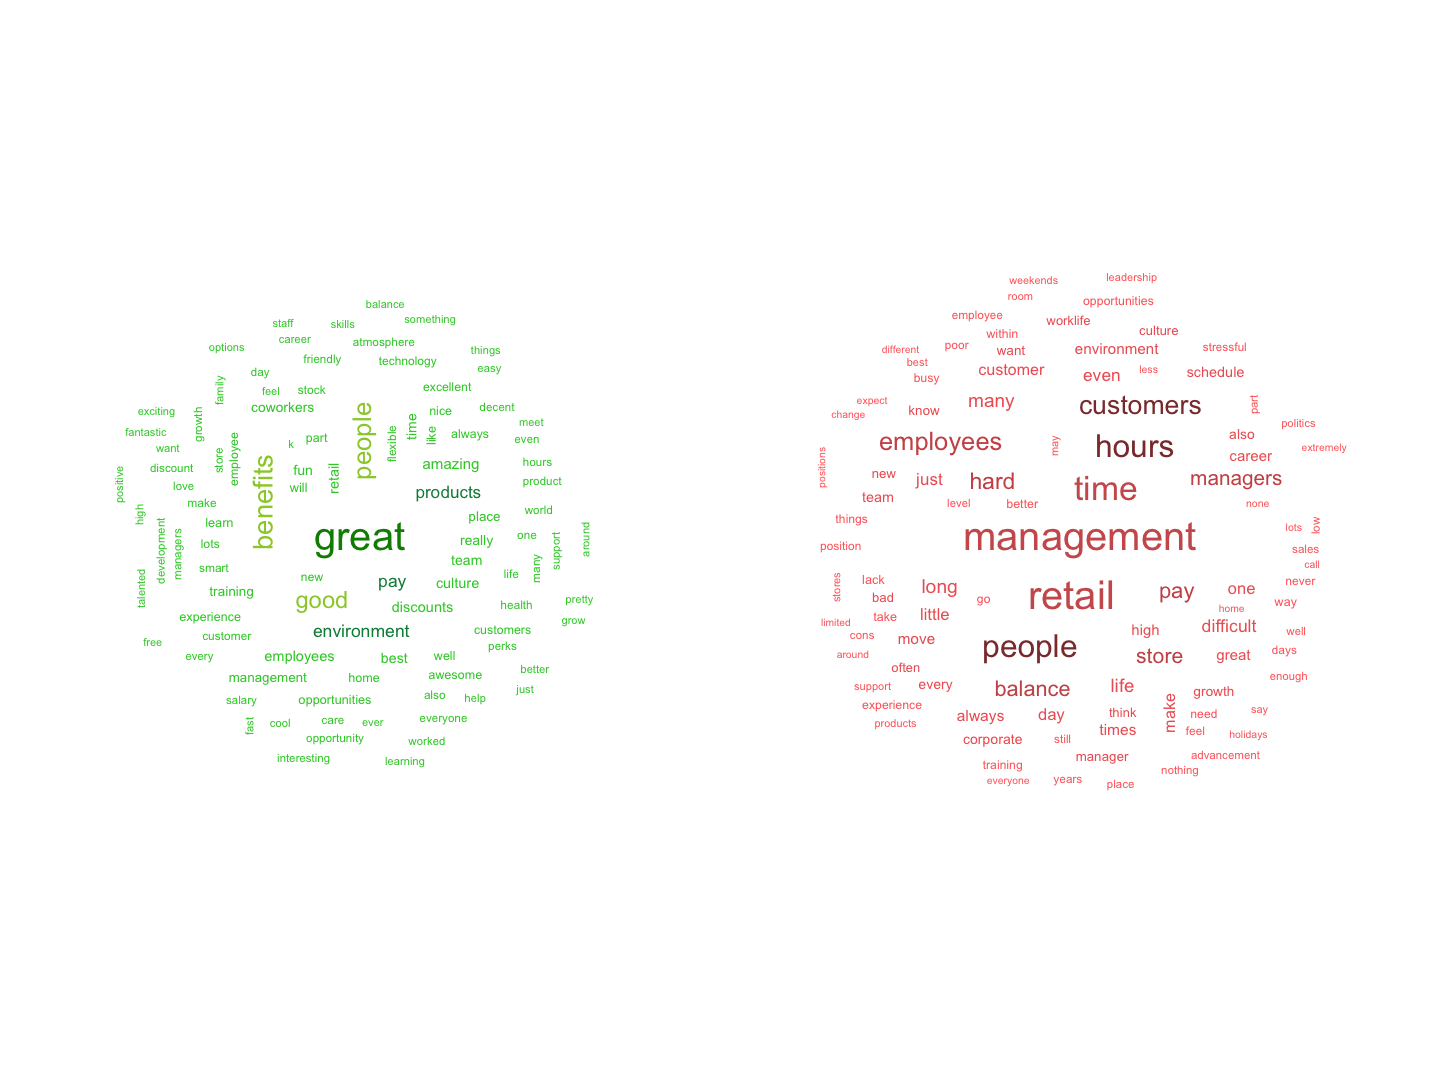

In [137]:
par(mfrow=c(1,2),mar=c(0,0,0,0))
wordcloud(apl_pros_words$WORD,apl_pros_words$FREQ,scale=c(2,0.5),random.order = FALSE, colors=c("limegreen","springgreen4","yellowgreen","seagreen3","green4"))
wordcloud(apl_cons_words$WORD,apl_cons_words$FREQ,scale=c(2,0.3),random.order = FALSE,colors=c("indianred1","indianred2","indianred3","indianred4","indianred"))

**Wordcloud for Facebook pros and cons**

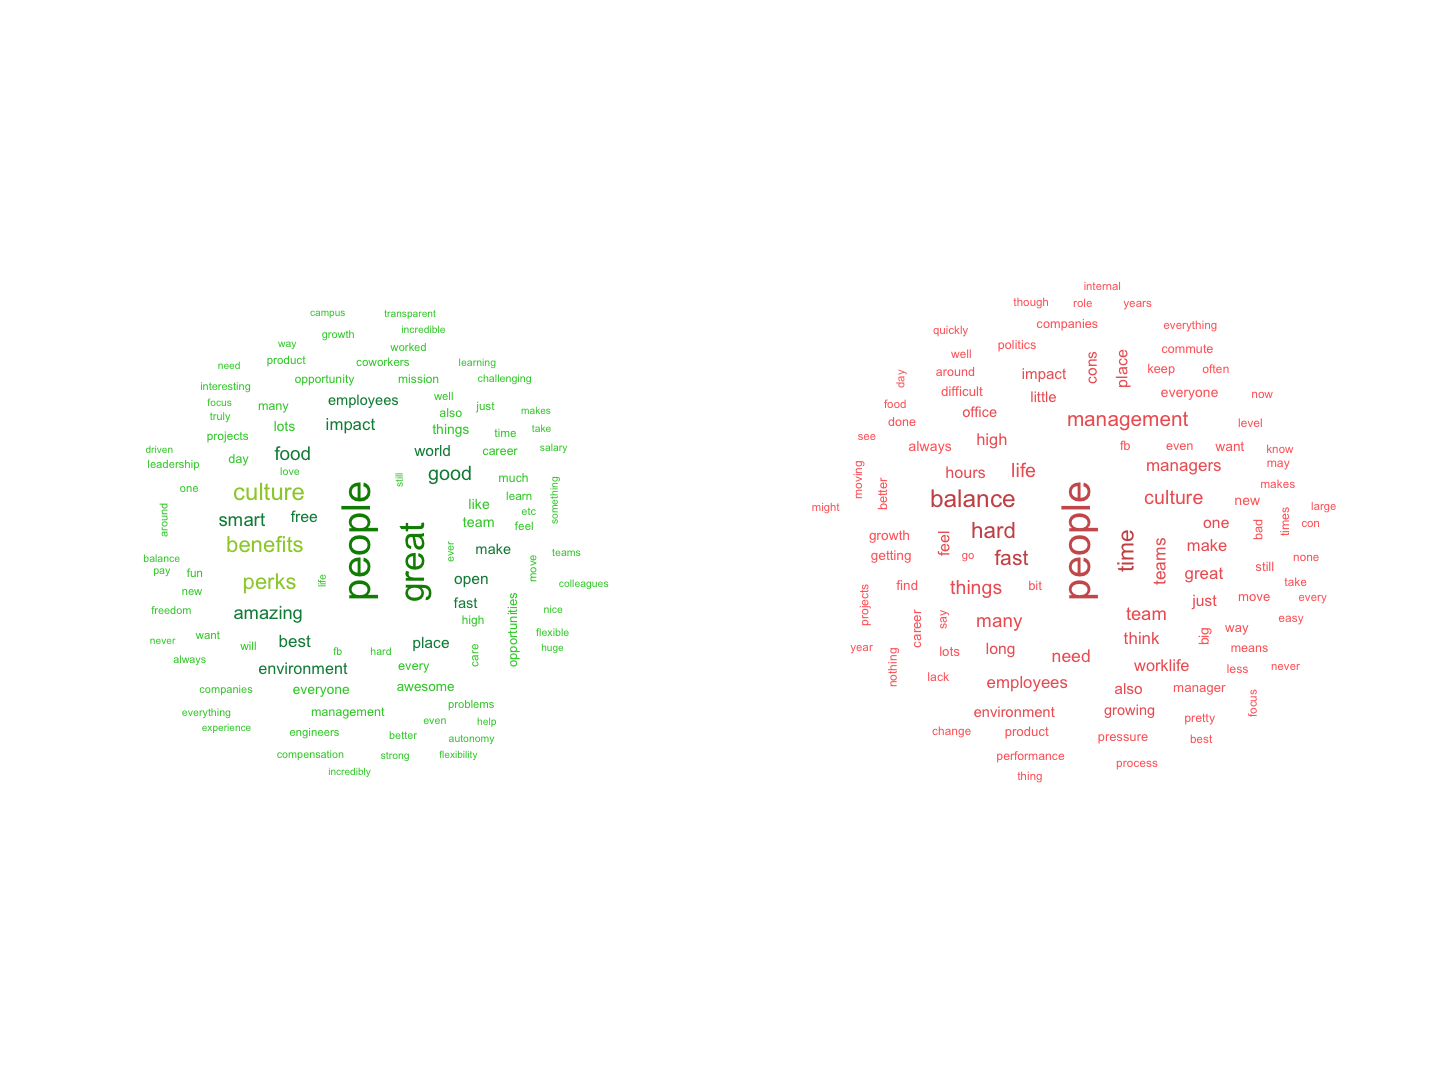

In [138]:
par(mfrow=c(1,2),mai = c(0, 0, 0, 0))
wordcloud(fb_pros_words$WORD,fb_pros_words$FREQ,scale=c(2,0.4),random.order = FALSE,colors=c("limegreen","springgreen4","yellowgreen","seagreen3","green4"))
wordcloud(fb_cons_words$WORD,fb_cons_words$FREQ,scale=c(2,0.4),random.order = FALSE,colors=c("indianred1","indianred2","indianred3","indianred4","indianred"))

**Wordcloud for Microsoft pros and cons**

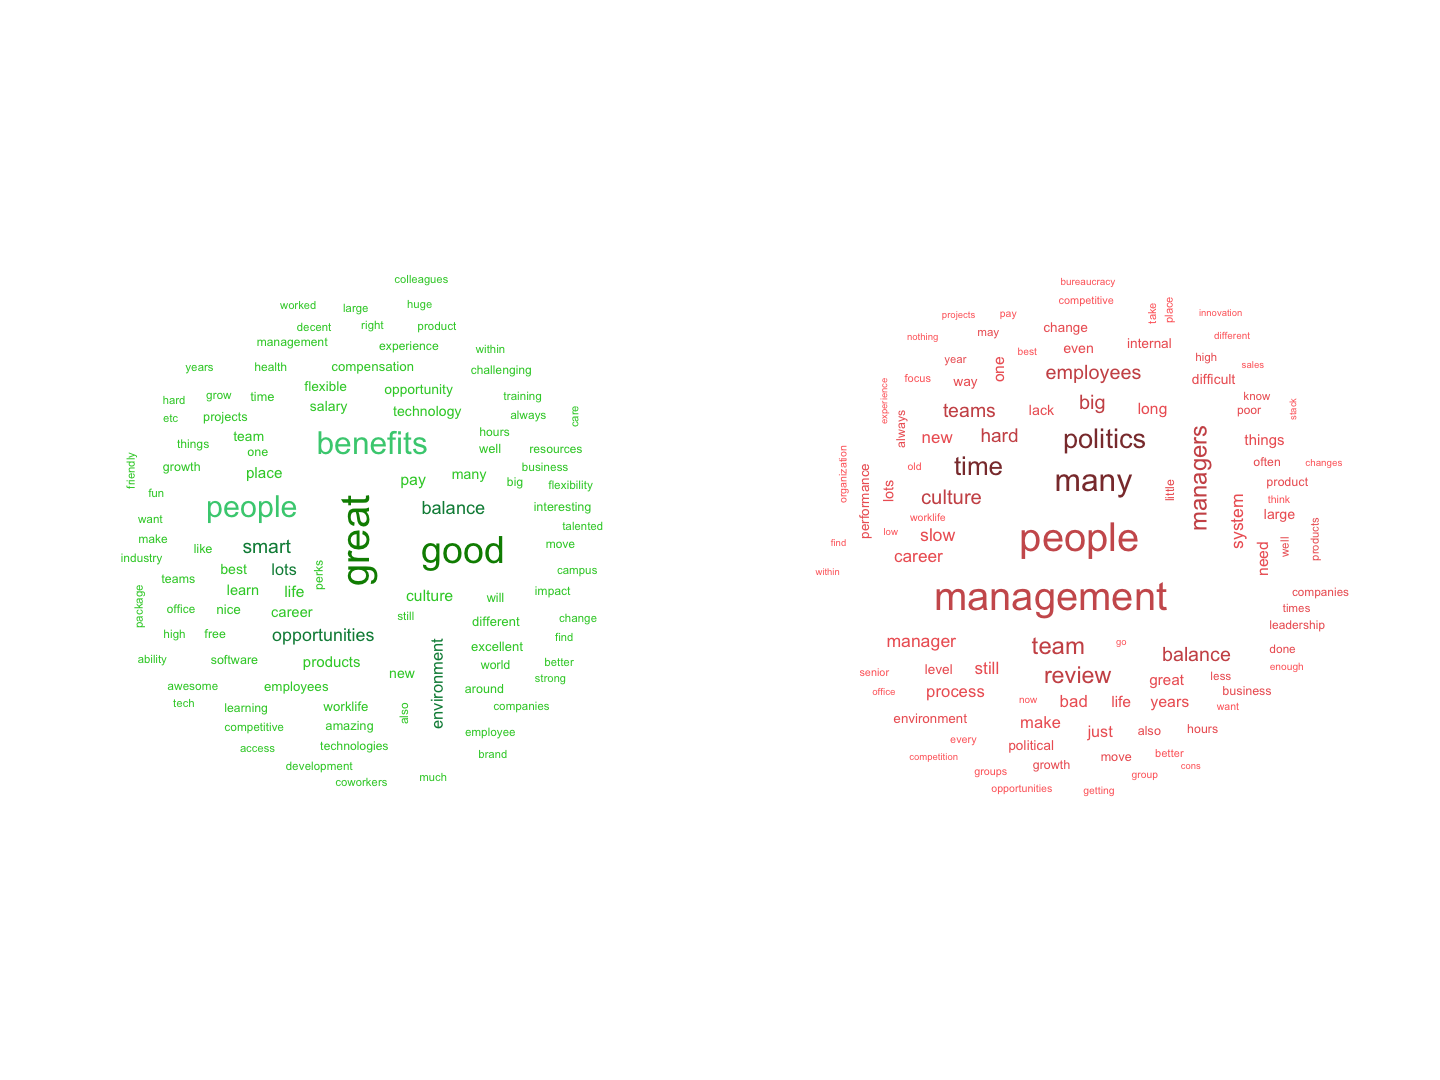

In [139]:
par(mfrow=c(1,2),mai = c(0, 0, 0, 0))
wordcloud(ms_pros_words$WORD,ms_pros_words$FREQ,scale=c(2,0.5),random.order = FALSE,colors=c("limegreen","springgreen4","yellowgreen","seagreen3","green4"))
wordcloud(ms_cons_words$WORD,ms_cons_words$FREQ,scale=c(2,0.2),random.order = FALSE,colors=c("indianred1","indianred2","indianred3","indianred4","indianred"))

**Wordcloud for Netflix pros and cons**

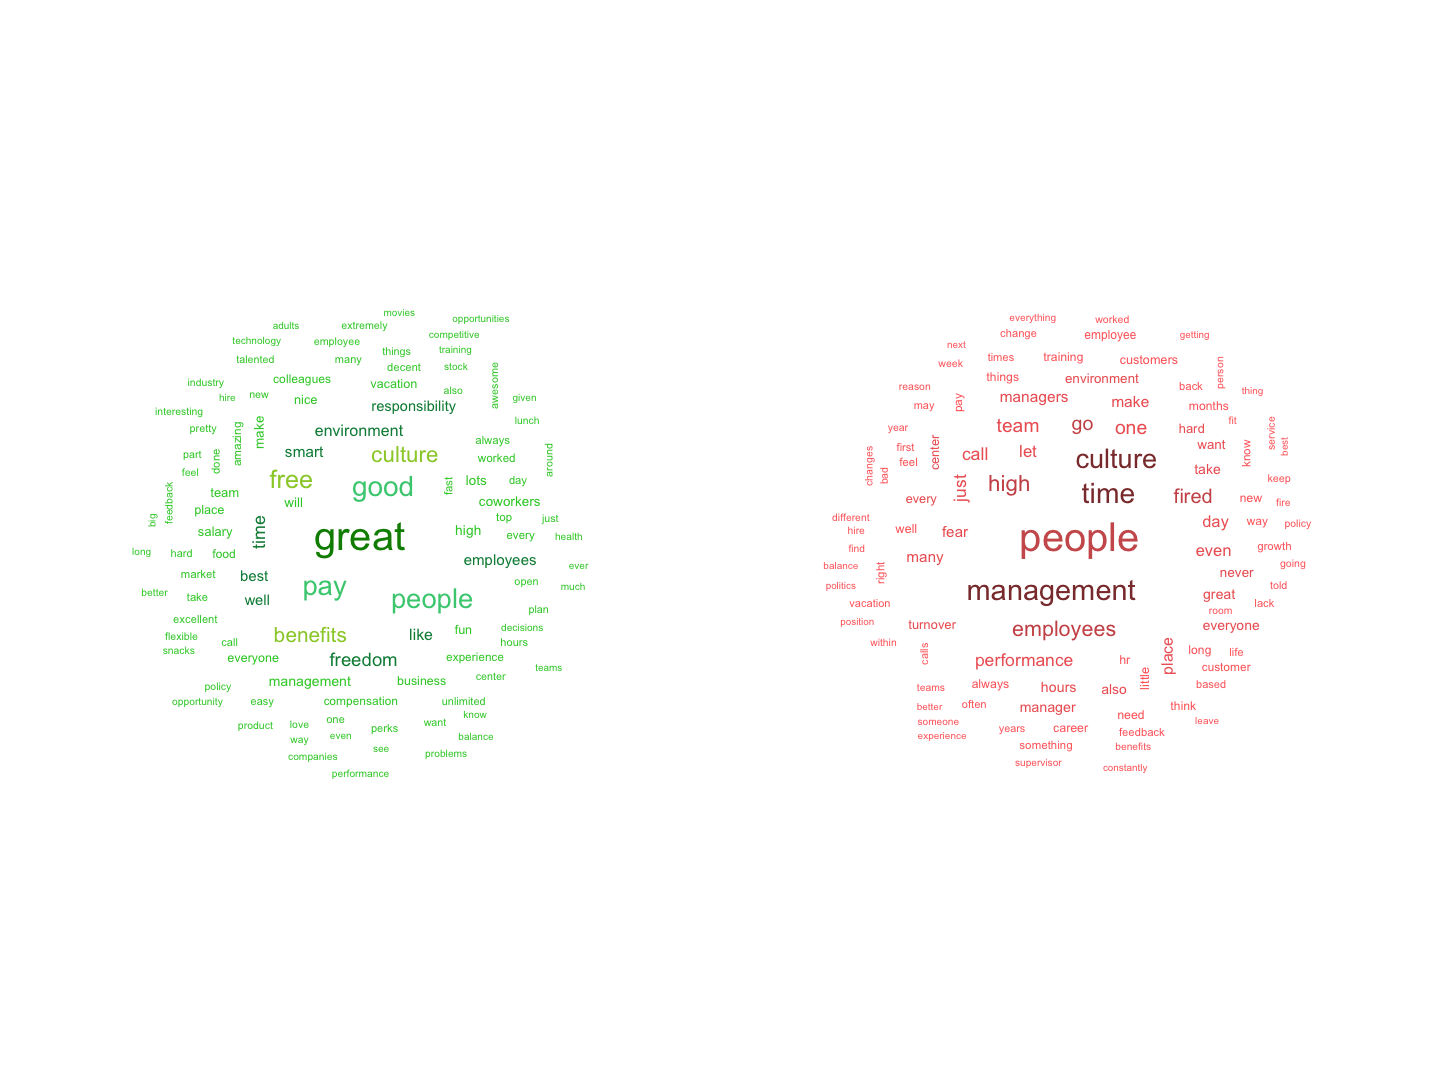

In [140]:
par(mfrow=c(1,2),oma = c(0, 0, 0, 0))
wordcloud(nf_pros_words$WORD,nf_pros_words$FREQ,scale=c(2,0.4),random.order = FALSE,colors=c("limegreen","springgreen4","yellowgreen","seagreen3","green4"))
wordcloud(nf_cons_words$WORD,nf_cons_words$FREQ,scale=c(2,0.3),random.order = FALSE,colors=c("indianred1","indianred2","indianred3","indianred4","indianred"))

## PART 3.2 Text Mining: Sentimental Analysis

on column **summary** to answer the question:
 - **What is the relationship between positive/negative words in the summary and overall ratings?**

In [141]:
df_gg%>%
  select(X,summary, overall.ratings) %>%
  group_by(X)%>%
  unnest_tokens(output = word, input = summary)%>%
  inner_join(get_sentiments('bing'))%>%
  group_by(sentiment) 

Joining, by = "word"



X    overall.ratings word        sentiment
1     1   5               best        positive 
2     1   5               work        positive 
3     2   4               burn        negative 
4     2   4               inevitable  negative 
5     3   5               great       positive 
6     3   5               fun         positive 
7     3   5               fast        positive 
8     4   5               best        positive 
9     4   5               worked      positive 
10    6   5               nice        positive 
11    8   5               great       positive 
12    8   5               work        positive 
13    8   5               progress    positive 
14    9   5               realistic   positive 
15   11   5               nice        positive 
16   11   5               work        positive 
17   13   5               best        positive 
18   13   5               work        positive 
19   14   5               best        positive 
20   14   5               work        positive 
21   19   5               great       positive 
22   21   5               great       positive 
23   21   5               great       positive 
24   21   5               better      positive 
25   22   5               great       positive 
26   22   5               work        positive 
27   26   5               good        positive 
28   26   5               work        positive 
29   27   5               great       positive 
30   28   5               perfect     positive 
⋮    ⋮    ⋮               ⋮           ⋮        
7687 7727 5               love        positive 
7688 7728 4               like        positive 
7689 7729 1               great       positive 
7690 7729 1               great       positive 
7691 7731 2               great       positive 
7692 7732 4               great       positive 
7693 7732 4               best        positive 
7694 7733 4               fair        positive 
7695 7733 4               work        positive 
7696 7734 3               fun         positive 
7697 7734 3               fun         positive 
7698 7735 5               great       positive 
7699 7735 5               work        positive 
7700 7736 5               best        positive 
7701 7736 5               work        positive 
7702 7737 5               best        positive 
7703 7739 1               loss        negative 
7704 7739 1               competitive positive 
7705 7763 5               cool        positive 
7706 7771 5               premier     positive 
7707 7773 4               super       positive 
7708 7776 5               die         negative 
7709 7781 4               top         positive 
7710 7791 3               cool        positive 
7711 7795 4               super       positive 
7712 7796 4               super       positive 
7713 7799 5               super       positive 
7714 7806 5               freedom     positive 
7715 7808 3               die         negative 
7716 7816 3               innovative  positive

### Fraction of Positive Words

compute a fraction of positive words and all positive and negative words for each review and visualize in picture

**Summary by sentiment proportion, break down by overall**

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"



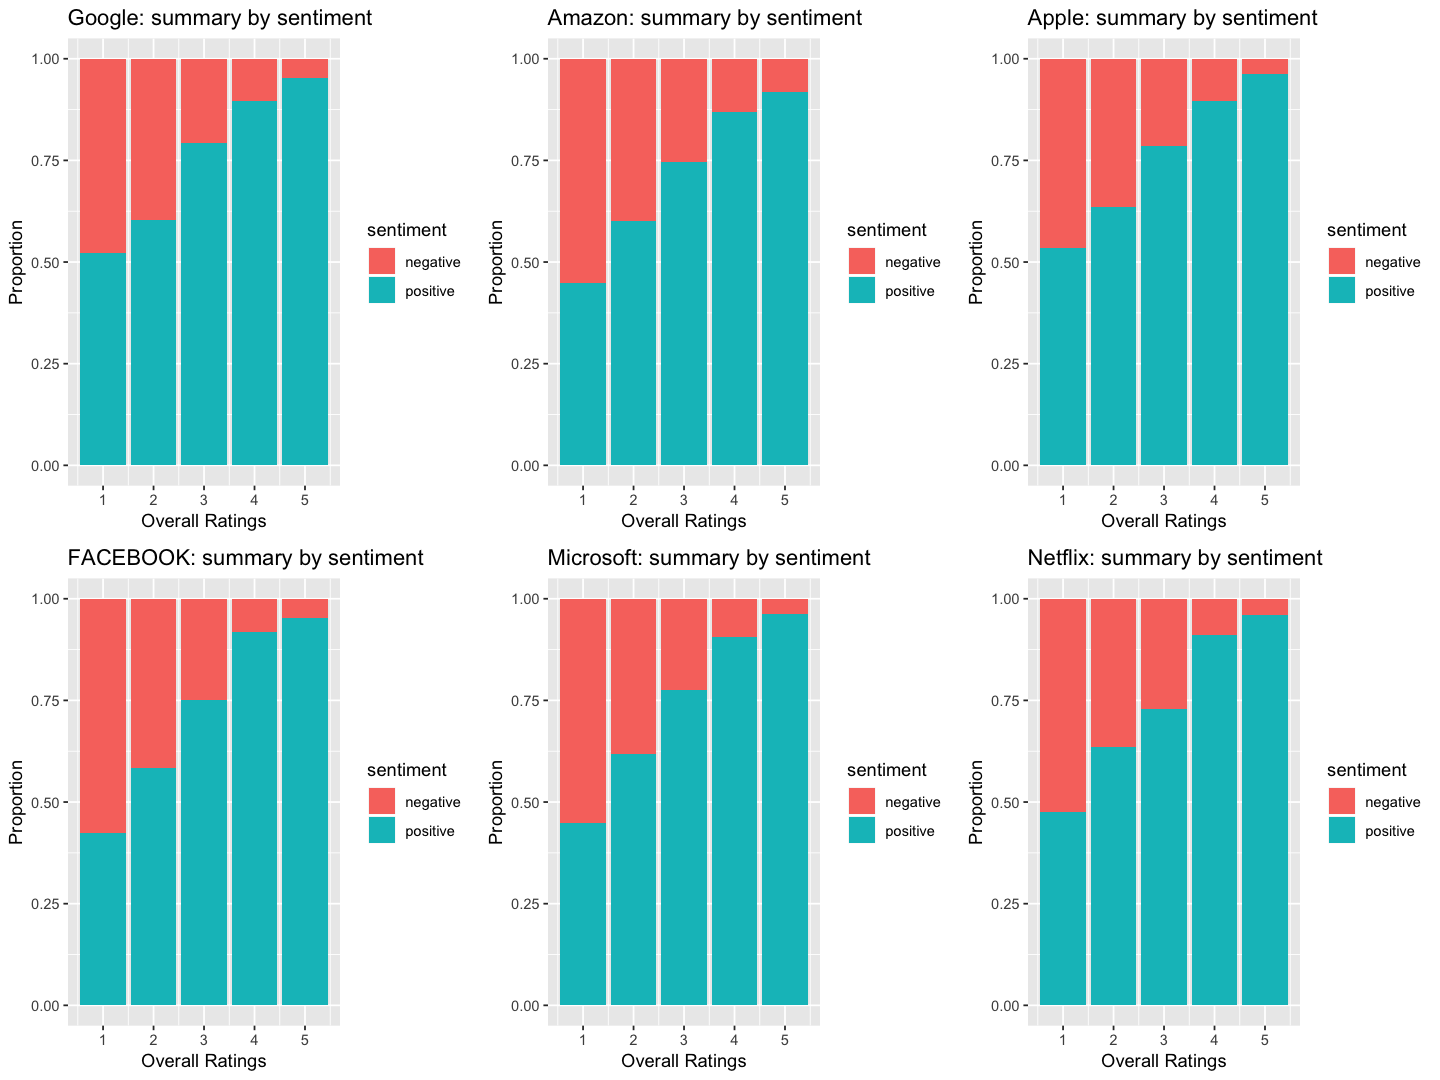

In [142]:
#Google summary by sentiment proportion, break down by overall ratings

p27 <- df_gg %>%
  select(X,summary,overall.ratings)%>%
  group_by(X)%>%
  unnest_tokens(output=word,input=summary)%>%
  ungroup()%>%
  inner_join(get_sentiments('bing'))%>%
  group_by(overall.ratings,sentiment)%>%
  summarize(n = n())%>%
  mutate(proportion = n/sum(n)) %>%
  ggplot(aes(x=overall.ratings, y=proportion, fill = sentiment))+geom_col()+labs(x = "Overall Ratings", y = "Proportion", title = "Google: summary by sentiment")

#Amazon summary by sentiment proportion, break down by overall ratings

p28 <- df_amz %>%
  select(X,summary,overall.ratings)%>%
  group_by(X)%>%
  unnest_tokens(output=word,input=summary)%>%
  ungroup()%>%
  inner_join(get_sentiments('bing'))%>%
  group_by(overall.ratings,sentiment)%>%
  summarize(n = n())%>%
  mutate(proportion = n/sum(n)) %>%
  ggplot(aes(x=overall.ratings, y=proportion, fill = sentiment))+geom_col()+labs(x = "Overall Ratings", y = "Proportion", title = "Amazon: summary by sentiment")

#Apple summary by sentiment proportion, break down by overall ratings

p29 <- df_apl %>%
  select(X,summary,overall.ratings)%>%
  group_by(X)%>%
  unnest_tokens(output=word,input=summary)%>%
  ungroup()%>%
  inner_join(get_sentiments('bing'))%>%
  group_by(overall.ratings,sentiment)%>%
  summarize(n = n())%>%
  mutate(proportion = n/sum(n)) %>%
  ggplot(aes(x=overall.ratings, y=proportion, fill = sentiment))+geom_col()+labs(x = "Overall Ratings", y = "Proportion", title = "Apple: summary by sentiment")

#FB summary by sentiment proportion, break down by overall ratings

p30 <- df_fb %>%
  select(X,summary,overall.ratings)%>%
  group_by(X)%>%
  unnest_tokens(output=word,input=summary)%>%
  ungroup()%>%
  inner_join(get_sentiments('bing'))%>%
  group_by(overall.ratings,sentiment)%>%
  summarize(n = n())%>%
  mutate(proportion = n/sum(n)) %>%
  ggplot(aes(x=overall.ratings, y=proportion, fill = sentiment))+geom_col()+labs(x = "Overall Ratings", y = "Proportion", title = "FACEBOOK: summary by sentiment")

#Microsoft summary by sentiment proportion, break down by overall ratings

p31 <- df_ms %>%
  select(X,summary,overall.ratings)%>%
  group_by(X)%>%
  unnest_tokens(output=word,input=summary)%>%
  ungroup()%>%
  inner_join(get_sentiments('bing'))%>%
  group_by(overall.ratings,sentiment)%>%
  summarize(n = n())%>%
  mutate(proportion = n/sum(n)) %>%
  ggplot(aes(x=overall.ratings, y=proportion, fill = sentiment))+geom_col()+labs(x = "Overall Ratings", y = "Proportion", title = "Microsoft: summary by sentiment")

#Netflix summary by sentiment proportion, break down by overall ratings

p32 <- df_nf %>%
  select(X,summary,overall.ratings)%>%
  group_by(X)%>%
  unnest_tokens(output=word,input=summary)%>%
  ungroup()%>%
  inner_join(get_sentiments('bing'))%>%
  group_by(overall.ratings,sentiment)%>%
  summarize(n = n())%>%
  mutate(proportion = n/sum(n)) %>%
  ggplot(aes(x=overall.ratings, y=proportion, fill = sentiment))+geom_col()+labs(x = "Overall Ratings", y = "Proportion", title = "Netflix: summary by sentiment")

grid.arrange(p27, p28, p29, p30, p31, p32, ncol = 3)

**Word by Emotion(nrc lexicon): let's also inspect word by emotion and visualize the result**

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"



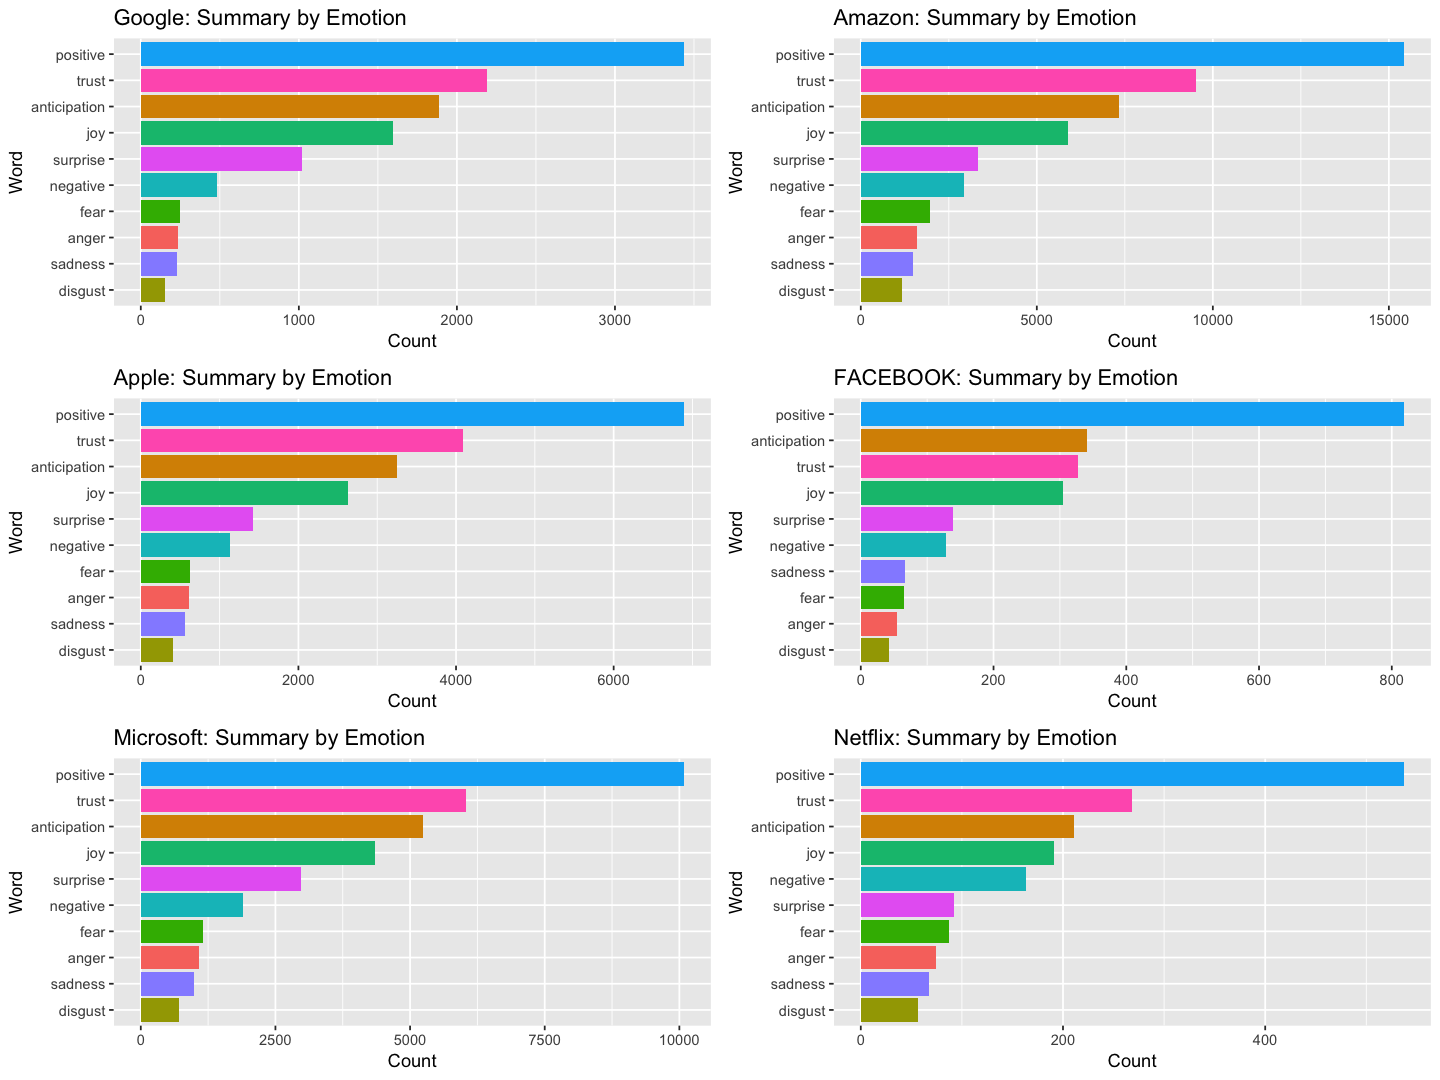

In [143]:
p33 <- df_gg%>%
  group_by(X)%>%
  unnest_tokens(output = word, input = summary)%>%
  inner_join(get_sentiments('nrc'))%>%
  group_by(sentiment)%>%
  count()%>%
  ggplot(aes(x=reorder(sentiment,X = n),y=n,fill=sentiment))+geom_col()+guides(fill=F)+coord_flip()+labs(x = "Word", y = "Count", title = "Google: Summary by Emotion")

p34 <- df_amz%>%
  group_by(X)%>%
  unnest_tokens(output = word, input = summary)%>%
  inner_join(get_sentiments('nrc'))%>%
  group_by(sentiment)%>%
  count()%>%
  ggplot(aes(x=reorder(sentiment,X = n),y=n,fill=sentiment))+geom_col()+guides(fill=F)+coord_flip()+labs(x = "Word", y = "Count", title = "Amazon: Summary by Emotion")

p35 <- df_apl%>%
  group_by(X)%>%
  unnest_tokens(output = word, input = summary)%>%
  inner_join(get_sentiments('nrc'))%>%
  group_by(sentiment)%>%
  count()%>%
  ggplot(aes(x=reorder(sentiment,X = n),y=n,fill=sentiment))+geom_col()+guides(fill=F)+coord_flip()+labs(x = "Word", y = "Count", title = "Apple: Summary by Emotion")

p36 <- df_fb%>%
  group_by(X)%>%
  unnest_tokens(output = word, input = summary)%>%
  inner_join(get_sentiments('nrc'))%>%
  group_by(sentiment)%>%
  count()%>%
  ggplot(aes(x=reorder(sentiment,X = n),y=n,fill=sentiment))+geom_col()+guides(fill=F)+coord_flip()+labs(x = "Word", y = "Count", title = "FACEBOOK: Summary by Emotion")

p37 <- df_ms%>%
  group_by(X)%>%
  unnest_tokens(output = word, input = summary)%>%
  inner_join(get_sentiments('nrc'))%>%
  group_by(sentiment)%>%
  count()%>%
  ggplot(aes(x=reorder(sentiment,X = n),y=n,fill=sentiment))+geom_col()+guides(fill=F)+coord_flip()+labs(x = "Word", y = "Count", title = "Microsoft: Summary by Emotion")

p38 <- df_nf%>%
  group_by(X)%>%
  unnest_tokens(output = word, input = summary)%>%
  inner_join(get_sentiments('nrc'))%>%
  group_by(sentiment)%>%
  count()%>%
  ggplot(aes(x=reorder(sentiment,X = n),y=n,fill=sentiment))+geom_col()+guides(fill=F)+coord_flip()+labs(x = "Word", y = "Count", title = "Netflix: Summary by Emotion")


grid.arrange(p33, p34, p35, p36, p37, p38, ncol = 2)

#### Text Mining Part Summary: Positive and Negative Comparison Cloud for the whole dataset on summary to answer the question:

 - **What do employee like and dislike about a company in general?**

Joining, by = "word"

Joining, by = "word"



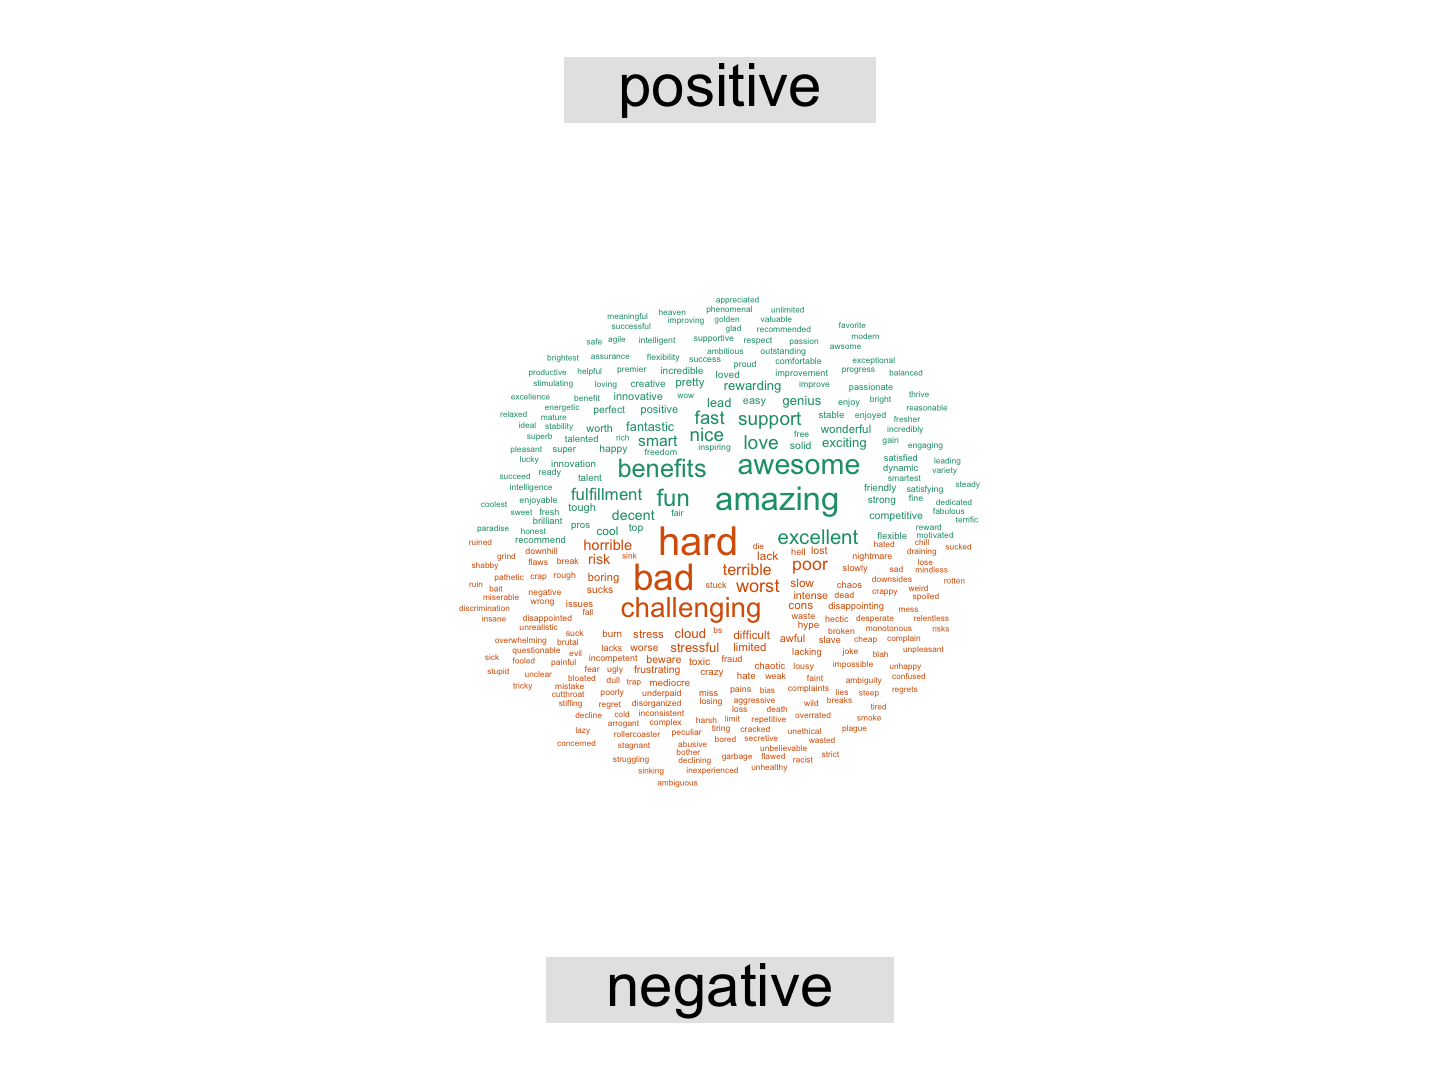

In [144]:
wordcloudData = 
  df%>%
  group_by(X)%>%
  unnest_tokens(output=word,input=summary)%>%
  anti_join(stop_words)%>%
  inner_join(get_sentiments('bing'))%>%
  ungroup()%>%
  count(sentiment,word,sort=T)%>%
  spread(key=sentiment,value = n,fill=0)%>%
  data.frame()
rownames(wordcloudData) = wordcloudData[,'word']
wordcloudData = wordcloudData[,c('positive','negative')]
set.seed(617)
comparison.cloud(term.matrix = wordcloudData,scale = c(2,0.4),max.words = 300, rot.per=0)

## PART 4: Trend Analysis to answer the question:
- **How did the ratings change over time for each company?**

### PART 4.1: Do current employees review the companies higher than the former ones?

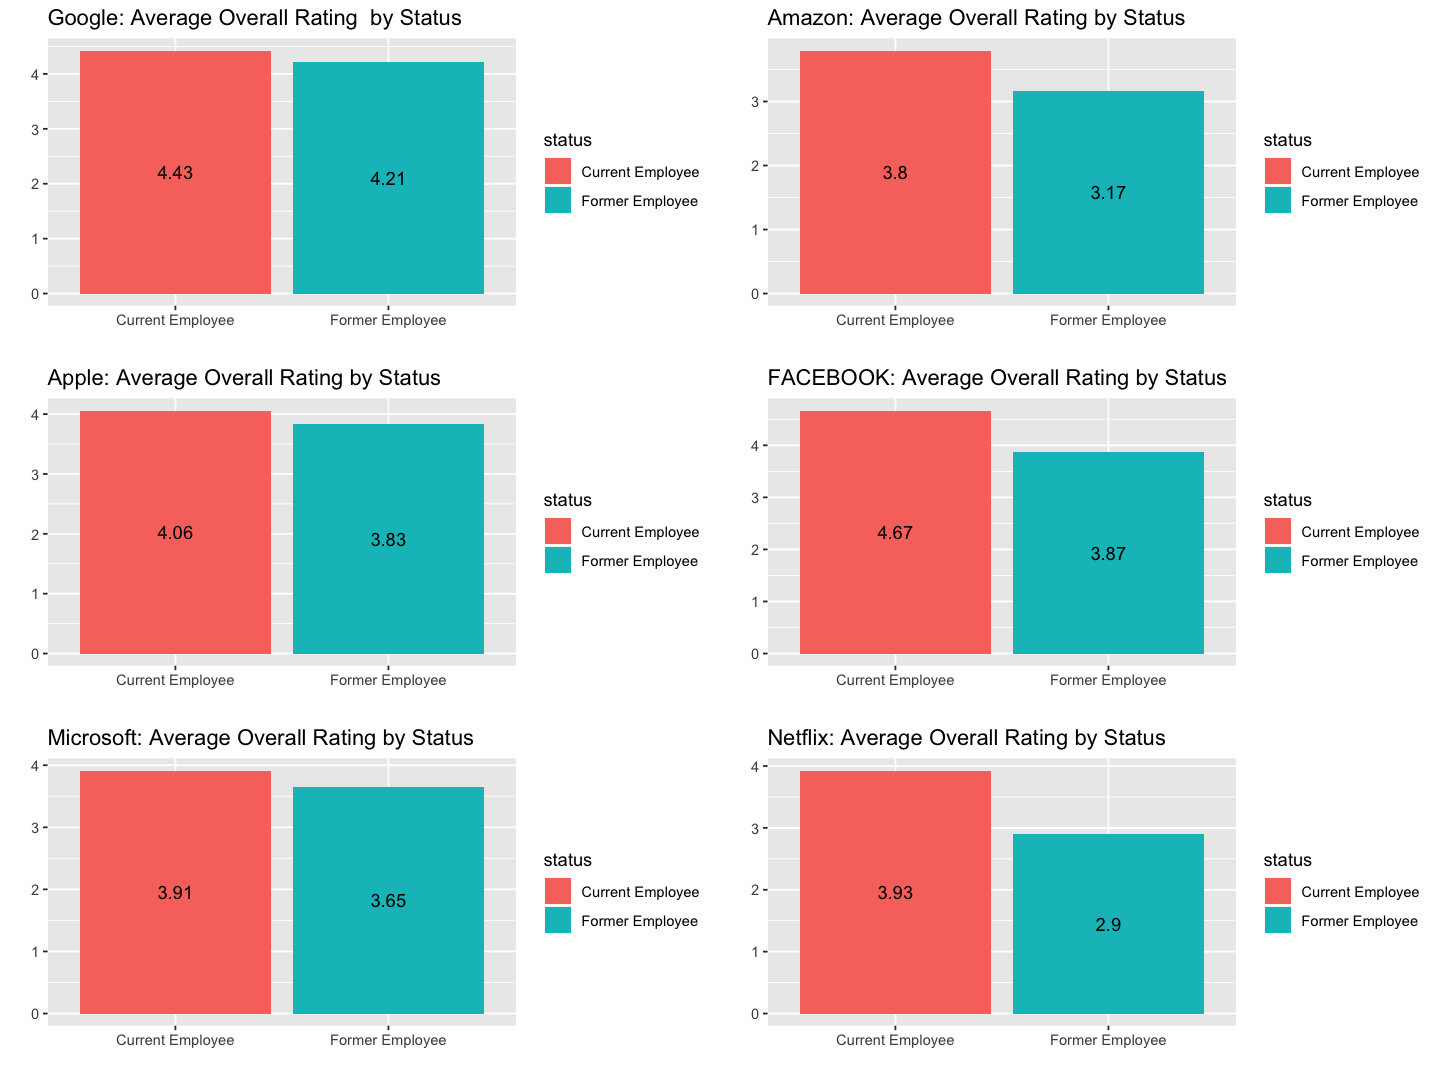

In [145]:
#Google: Average Overall Rating  by Status (current/former employee)
p39 <-df_gg %>%
  group_by(status) %>%
  summarize(avg_rating = mean(overall.ratings)) %>%
  ggplot(aes(x=status, y= avg_rating, fill = status)) + geom_bar(stat="identity")+labs(x = "", y = "", title = "Google: Average Overall Rating  by Status")+geom_text(aes(y = avg_rating/2, label = round(avg_rating,2)))

#Amazon: Average Overall Rating by Status
p40 <-df_amz %>%
  group_by(status) %>%
  summarize(avg_rating = mean(overall.ratings)) %>%
  ggplot(aes(x=status, y= avg_rating, fill = status)) + geom_bar(stat="identity")+labs(x = "", y = "", title = "Amazon: Average Overall Rating by Status")+geom_text(aes(y = avg_rating/2, label = round(avg_rating,2)))

#Apple: Average Overall Rating by Status
p41 <- df_apl %>%
  group_by(status) %>%
  summarize(avg_rating = mean(overall.ratings)) %>%
  ggplot(aes(x=status, y= avg_rating, fill = status)) + geom_bar(stat="identity")+labs(x = "", y = "", title = "Apple: Average Overall Rating by Status")+geom_text(aes(y = avg_rating/2, label = round(avg_rating,2)))

#Facebook: Average Overall Rating by Status
p42 <- df_fb %>%
  group_by(status) %>%
  summarize(avg_rating = mean(overall.ratings)) %>%
  ggplot(aes(x=status, y= avg_rating, fill = status)) + geom_bar(stat="identity")+labs(x = "", y = "", title = "FACEBOOK: Average Overall Rating by Status")+geom_text(aes(y = avg_rating/2, label = round(avg_rating,2)))

#Microsoft: Average Overall Rating by Status
p43 <- df_ms %>%
  group_by(status) %>%
  summarize(avg_rating = mean(overall.ratings)) %>%
  ggplot(aes(x=status, y= avg_rating, fill = status)) + geom_bar(stat="identity")+labs(x = "", y = "", title = "Microsoft: Average Overall Rating by Status")+geom_text(aes(y = avg_rating/2, label = round(avg_rating,2)))

#Netflix: Average Overall Rating by Status
p44 <- df_nf %>%
  group_by(status) %>%
  summarize(avg_rating = mean(overall.ratings)) %>%
  ggplot(aes(x=status, y= avg_rating, fill = status)) + geom_bar(stat="identity")+labs(x = "", y = "", title = "Netflix: Average Overall Rating by Status")+geom_text(aes(y = avg_rating/2, label = round(avg_rating,2)))

grid.arrange(p39, p40, p41, p42, p43, p44, ncol = 2)

We can tell from the graph that
- Current employees rated their firms higher than former employee
- Google has the most satisfied current employee
- Netflix has the biggest gap for company rating between current and former employee

### PART 4.2: Ratings trend over years for each company

**GOOGLE OVER TIME**

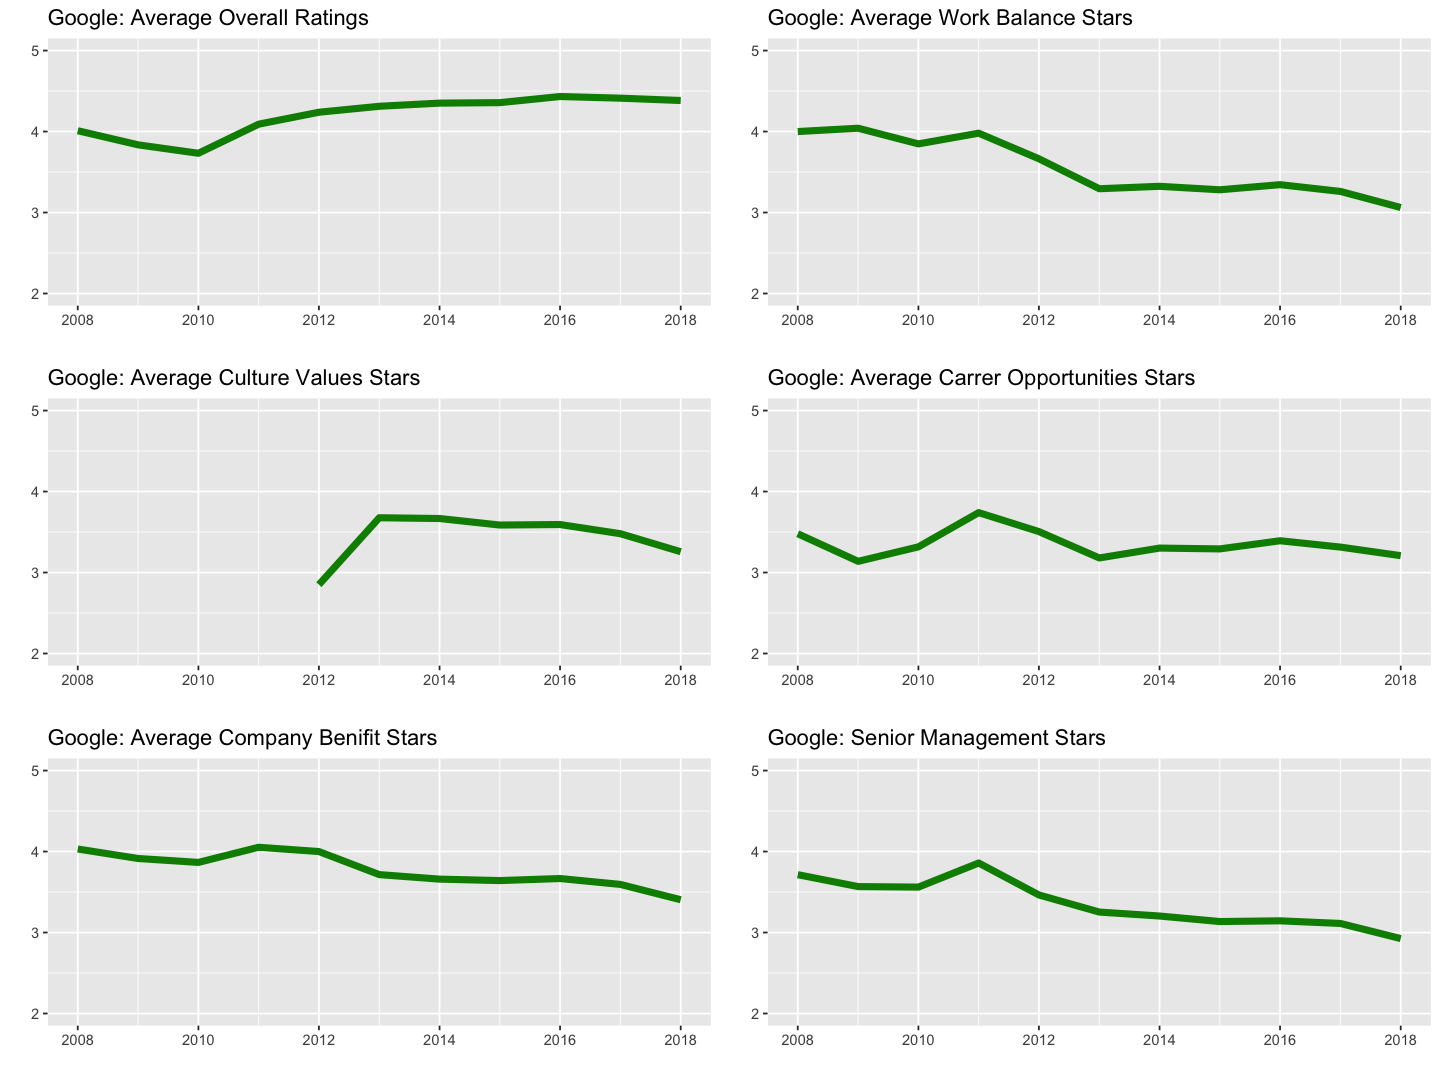

In [149]:
#GOOGLE OVER TIME:

#Google: Average Overall Ratings
p45 <- df_gg %>%
    select(dates,overall.ratings) %>%
    group_by(year=floor_date(as.Date(dates), "year")) %>%
    summarise(average =mean(overall.ratings)) %>%
    ggplot(aes(x = year, y = average))+
    geom_line(color = "green4", size = 2)+
    labs(x="",y="",title ="Google: Average Overall Ratings" )+
    scale_y_continuous(limits=c(2, 5))

#Google: Average Work Balance Stars
p46 <- df_gg %>%
  select(dates,work.balance.stars) %>%
  group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(average=mean(work.balance.stars)) %>%
  ggplot(aes(x = year, y = average))+geom_line(color = "green4", size = 2)+labs(x="",y="",title ="Google: Average Work Balance Stars" )+
    scale_y_continuous(limits=c(2, 5))


#Google: Average Culture Values Stars
p47<-df_gg %>%
  select(dates,culture.values.stars) %>%
  group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(average=mean(culture.values.stars)) %>%
  ggplot(aes(x = year, y = average))+geom_line(color = "green4", size = 2)+labs(x="",y="",title ="Google: Average Culture Values Stars" )+
    scale_y_continuous(limits=c(2, 5))


#Google: Average Carrer Opportunities Stars
p48 <-df_gg %>%
  select(dates,carrer.opportunities.stars) %>%
  group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(average =mean(carrer.opportunities.stars)) %>%
  ggplot(aes(x = year, y = average))+geom_line(color = "green4", size = 2)+labs(x="",y="",title ="Google: Average Carrer Opportunities Stars" )+
    scale_y_continuous(limits=c(2, 5))

#Google: Average Company Benifit Stars
p49 <-df_gg %>%
  select(dates,comp.benefit.stars) %>%
  group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(average =mean(comp.benefit.stars)) %>%
  ggplot(aes(x = year, y = average))+geom_line(color = "green4", size = 2)+labs(x="",y="",title ="Google: Average Company Benifit Stars" )+
    scale_y_continuous(limits=c(2, 5))

#Google: Senior Management Stars
p50 <-df_gg %>%
  select(dates,senior.mangemnet.stars) %>%
  group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(average =mean(senior.mangemnet.stars)) %>%
  ggplot(aes(x = year, y = average))+geom_line(color = "green4", size = 2)+labs(x="",y="",title ="Google: Senior Management Stars" )+
    scale_y_continuous(limits=c(2, 5))

grid.arrange(p45, p46, p47, p48, p49, p50, ncol = 2)

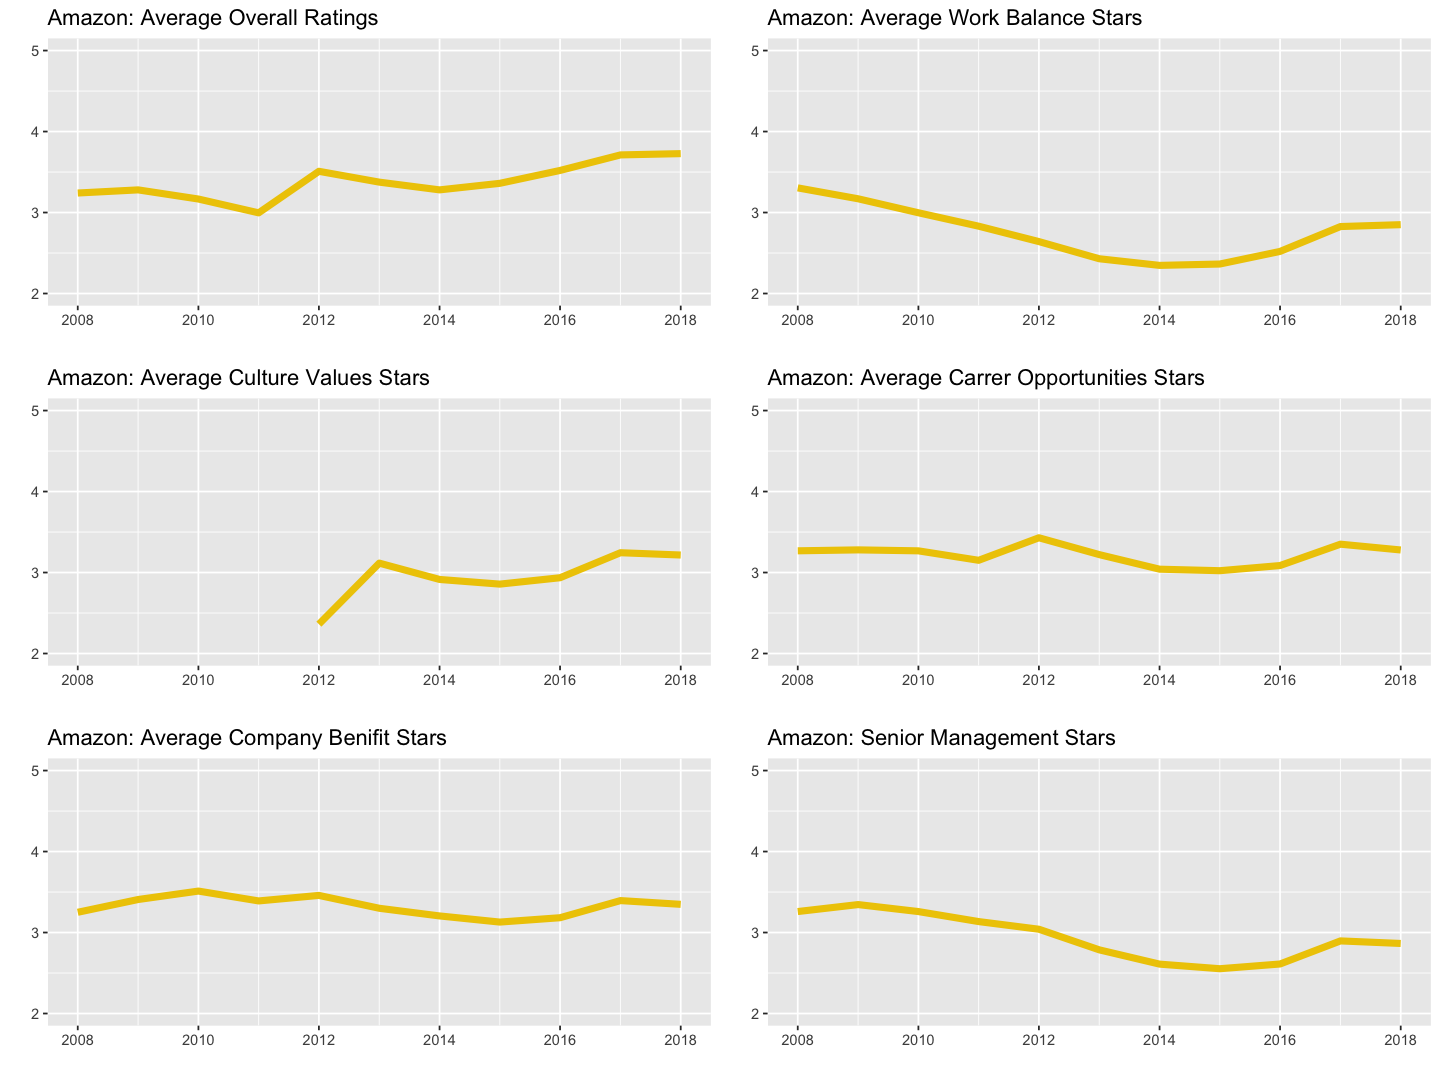

In [150]:
#Amazon: Average Overall Ratings

p51 <- df_amz %>%
  select(dates,overall.ratings) %>%
  filter(as.Date(dates) < as.Date("2019-12-31")) %>% #to remove outliers "9999-01-01"
  group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(average =mean(overall.ratings)) %>%
  ggplot(aes(x = year, y = average))+
  geom_line(color = "gold2", size = 2)+labs(x="",y="",title ="Amazon: Average Overall Ratings" )+
  scale_y_continuous(limits=c(2, 5))

#Amazon: Average Work Balance Stars
p52 <- df_amz %>%
  select(dates,work.balance.stars) %>%
  filter(as.Date(dates) < as.Date("2019-12-31")) %>%
  group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(average=mean(work.balance.stars)) %>%
  ggplot(aes(x = year, y = average))+geom_line(color = "gold2", size = 2)+labs(x="",y="",title ="Amazon: Average Work Balance Stars" )+
  scale_y_continuous(limits=c(2, 5))


#Amazon: Average Culture Values Stars
p53<-df_amz %>%
  select(dates,culture.values.stars) %>%
  filter(as.Date(dates) < as.Date("2019-12-31")) %>%
  group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(average=mean(culture.values.stars)) %>%
  ggplot(aes(x = year, y = average))+geom_line(color = "gold2", size = 2)+labs(x="",y="",title ="Amazon: Average Culture Values Stars" )+
  scale_y_continuous(limits=c(2, 5))


#Amazon: Average Carrer Opportunities Stars
p54 <-df_amz %>%
  select(dates,carrer.opportunities.stars) %>%
  filter(as.Date(dates) < as.Date("2019-12-31")) %>%
  group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(average =mean(carrer.opportunities.stars)) %>%
  ggplot(aes(x = year, y = average))+geom_line(color = "gold2", size = 2)+labs(x="",y="",title ="Amazon: Average Carrer Opportunities Stars" )+
  scale_y_continuous(limits=c(2, 5))

#Amazon: Average Company Benifit Stars
p55 <-df_amz %>%
  select(dates,comp.benefit.stars) %>%
  filter(as.Date(dates) < as.Date("2019-12-31")) %>%
  group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(average =mean(comp.benefit.stars)) %>%
  ggplot(aes(x = year, y = average))+geom_line(color = "gold2", size = 2)+labs(x="",y="",title ="Amazon: Average Company Benifit Stars" )+
  scale_y_continuous(limits=c(2, 5))

#Amazon: Senior Management Stars
p56 <-df_amz %>%
  select(dates,senior.mangemnet.stars) %>%
  filter(as.Date(dates) < as.Date("2019-12-31")) %>%
  group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(average =mean(senior.mangemnet.stars)) %>%
  ggplot(aes(x = year, y = average))+geom_line(color = "gold2", size = 2)+labs(x="",y="",title ="Amazon: Senior Management Stars" )+
  scale_y_continuous(limits=c(2, 5))

grid.arrange(p51, p52, p53, p54, p55, p56, ncol = 2)

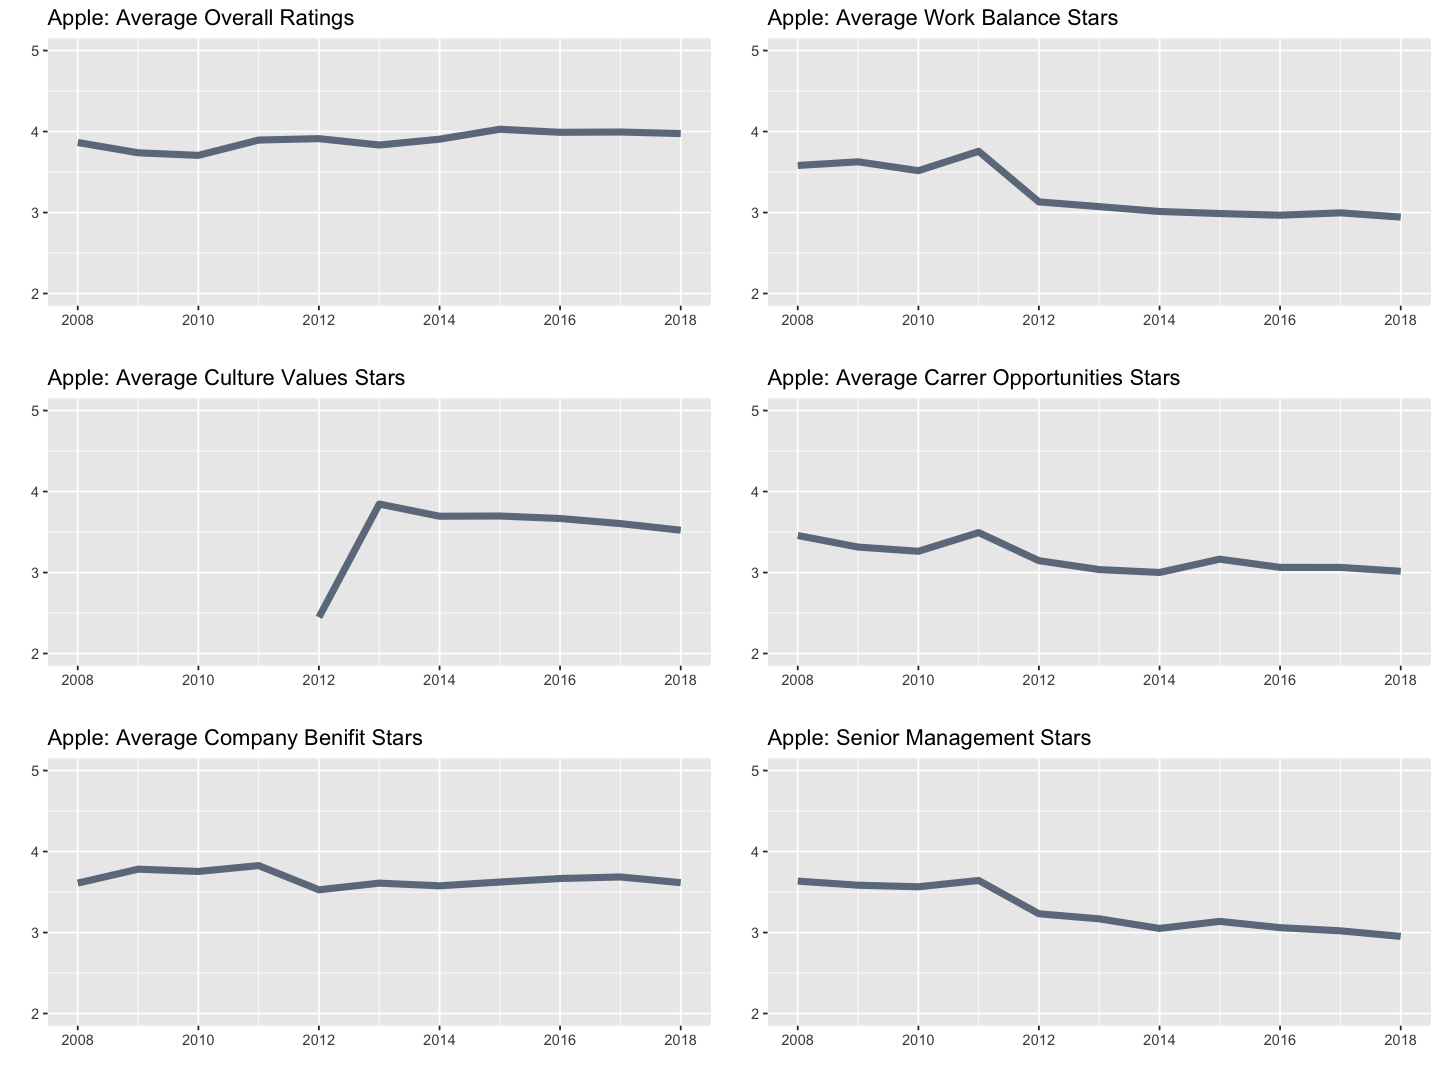

In [151]:
#Apple: Average Overall Ratings

p57 <- df_apl %>%
  select(dates,overall.ratings) %>%
  filter(as.Date(dates) < as.Date("2019-12-31")) %>% #to remove outliers "9999-01-01"
  group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(average =mean(overall.ratings)) %>%
  ggplot(aes(x = year, y = average))+geom_line(color = "slategray4", size = 2)+labs(x="",y="",title ="Apple: Average Overall Ratings" )+
  scale_y_continuous(limits=c(2, 5))

#Apple: Average Work Balance Stars
p58 <- df_apl %>%
  select(dates,work.balance.stars) %>%
  filter(as.Date(dates) < as.Date("2019-12-31")) %>%
  group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(average=mean(work.balance.stars)) %>%
  ggplot(aes(x = year, y = average))+geom_line(color = "slategray4", size = 2)+labs(x="",y="",title ="Apple: Average Work Balance Stars" )+
  scale_y_continuous(limits=c(2, 5))


#Apple: Average Culture Values Stars
p59<-df_apl %>%
  select(dates,culture.values.stars) %>%
  filter(as.Date(dates) < as.Date("2019-12-31")) %>%
  group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(average=mean(culture.values.stars)) %>%
  ggplot(aes(x = year, y = average))+geom_line(color = "slategray4", size = 2)+labs(x="",y="",title ="Apple: Average Culture Values Stars" )+
  scale_y_continuous(limits=c(2, 5))


#Apple: Average Carrer Opportunities Stars
p60 <-df_apl %>%
  select(dates,carrer.opportunities.stars) %>%
  filter(as.Date(dates) < as.Date("2019-12-31")) %>%
  group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(average =mean(carrer.opportunities.stars)) %>%
  ggplot(aes(x = year, y = average))+geom_line(color = "slategray4", size = 2)+labs(x="",y="",title ="Apple: Average Carrer Opportunities Stars" )+
  scale_y_continuous(limits=c(2, 5))

#Apple: Average Company Benifit Stars
p61 <-df_apl %>%
  select(dates,comp.benefit.stars) %>%
  filter(as.Date(dates) < as.Date("2019-12-31")) %>%
  group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(average =mean(comp.benefit.stars)) %>%
  ggplot(aes(x = year, y = average))+geom_line(color = "slategray4", size = 2)+labs(x="",y="",title ="Apple: Average Company Benifit Stars" )+
  scale_y_continuous(limits=c(2, 5))

#Apple: Senior Management Stars
p62 <-df_apl %>%
  select(dates,senior.mangemnet.stars) %>%
  filter(as.Date(dates) < as.Date("2019-12-31")) %>%
  group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(average =mean(senior.mangemnet.stars)) %>%
  ggplot(aes(x = year, y = average))+geom_line(color = "slategray4", size = 2)+labs(x="",y="",title ="Apple: Senior Management Stars" )+
  scale_y_continuous(limits=c(2, 5))

grid.arrange(p57, p58, p59, p60, p61, p62, ncol = 2)

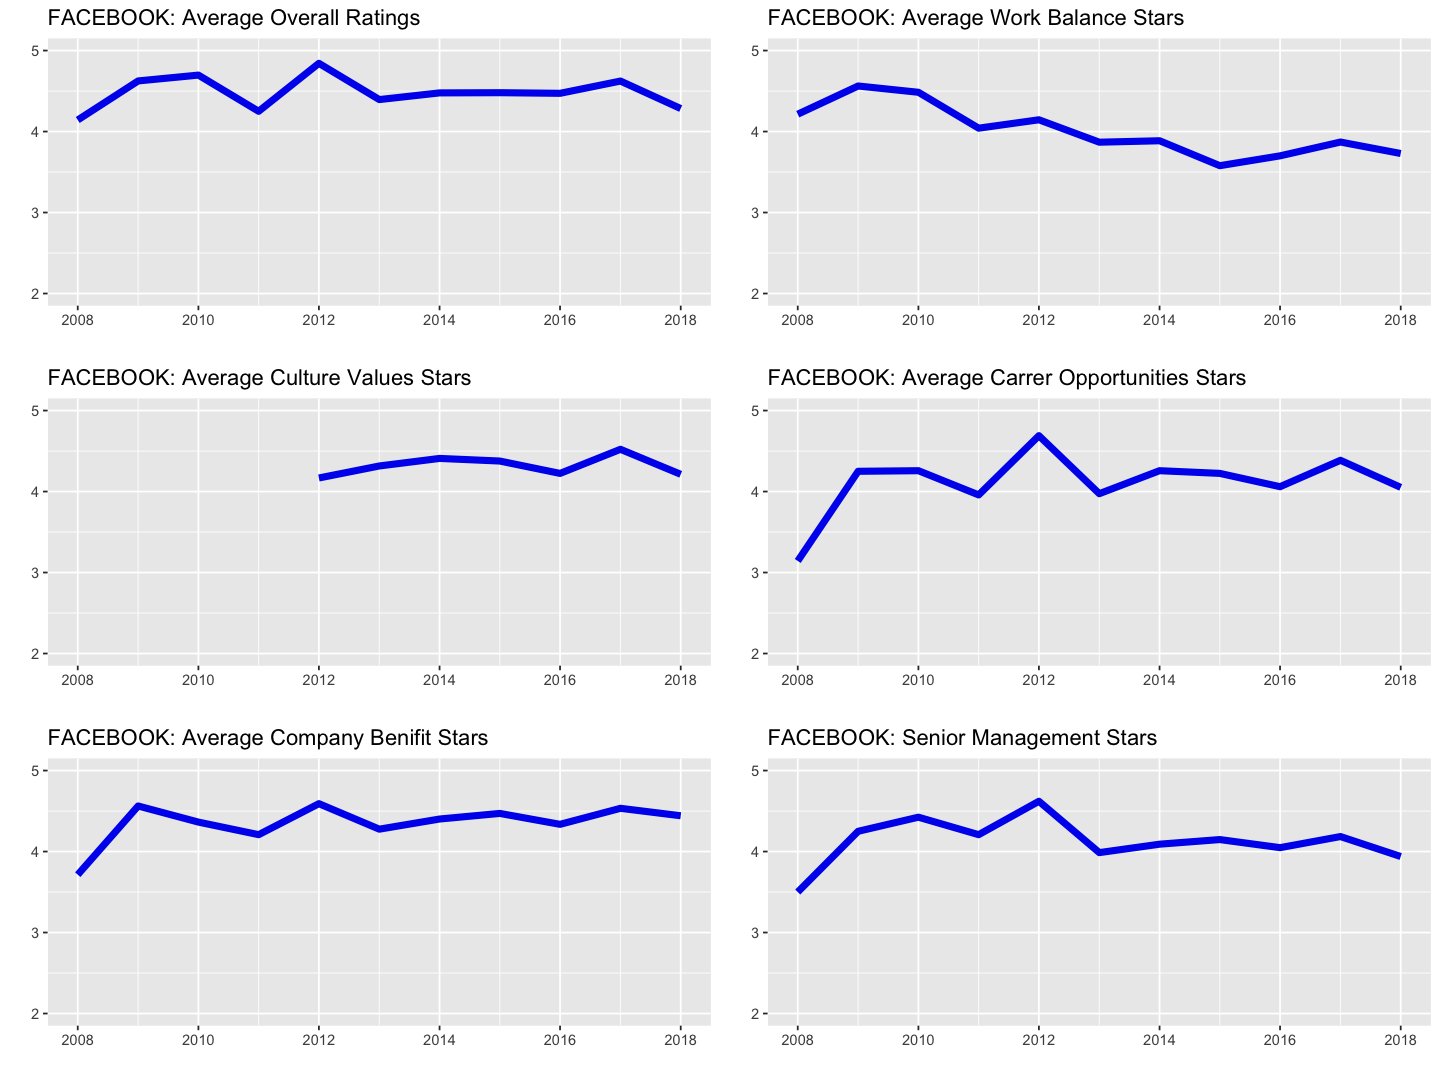

In [152]:
#FB: Average Overall Ratings

p63 <- df_fb %>%
  select(dates,overall.ratings) %>%
  filter(as.Date(dates) < as.Date("2019-12-31")) %>% #to remove outliers "9999-01-01"
  group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(average =mean(overall.ratings)) %>%
  ggplot(aes(x = year, y = average))+geom_line(color = "blue2", size = 2)+labs(x="",y="",title ="FACEBOOK: Average Overall Ratings" )+
  scale_y_continuous(limits=c(2, 5))

#FB: Average Work Balance Stars
p64 <- df_fb %>%
  select(dates,work.balance.stars) %>%
  filter(as.Date(dates) < as.Date("2019-12-31")) %>%
  group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(average=mean(work.balance.stars)) %>%
  ggplot(aes(x = year, y = average))+geom_line(color = "blue2", size = 2)+labs(x="",y="",title ="FACEBOOK: Average Work Balance Stars" )+
  scale_y_continuous(limits=c(2, 5))


#FB: Average Culture Values Stars
p65<-df_fb %>%
  select(dates,culture.values.stars) %>%
  filter(as.Date(dates) < as.Date("2019-12-31")) %>%
  group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(average=mean(culture.values.stars)) %>%
  ggplot(aes(x = year, y = average))+geom_line(color = "blue2", size = 2)+labs(x="",y="",title ="FACEBOOK: Average Culture Values Stars" )+
  scale_y_continuous(limits=c(2, 5))


#FB: Average Carrer Opportunities Stars
p66 <-df_fb %>%
  select(dates,carrer.opportunities.stars) %>%
  filter(as.Date(dates) < as.Date("2019-12-31")) %>%
  group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(average =mean(carrer.opportunities.stars)) %>%
  ggplot(aes(x = year, y = average))+geom_line(color = "blue2", size = 2)+labs(x="",y="",title ="FACEBOOK: Average Carrer Opportunities Stars" )+
  scale_y_continuous(limits=c(2, 5))

#FB: Average Company Benifit Stars
p67 <-df_fb %>%
  select(dates,comp.benefit.stars) %>%
  filter(as.Date(dates) < as.Date("2019-12-31")) %>%
  group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(average =mean(comp.benefit.stars)) %>%
  ggplot(aes(x = year, y = average))+geom_line(color = "blue2", size = 2)+labs(x="",y="",title ="FACEBOOK: Average Company Benifit Stars" )+
  scale_y_continuous(limits=c(2, 5))

#FB: Senior Management Stars
p68 <-df_fb %>%
  select(dates,senior.mangemnet.stars) %>%
  filter(as.Date(dates) < as.Date("2019-12-31")) %>%
  group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(average =mean(senior.mangemnet.stars)) %>%
  ggplot(aes(x = year, y = average))+geom_line(color = "blue2", size = 2)+labs(x="",y="",title ="FACEBOOK: Senior Management Stars" )+
  scale_y_continuous(limits=c(2, 5))

grid.arrange(p63, p64, p65, p66, p67, p68, ncol = 2)

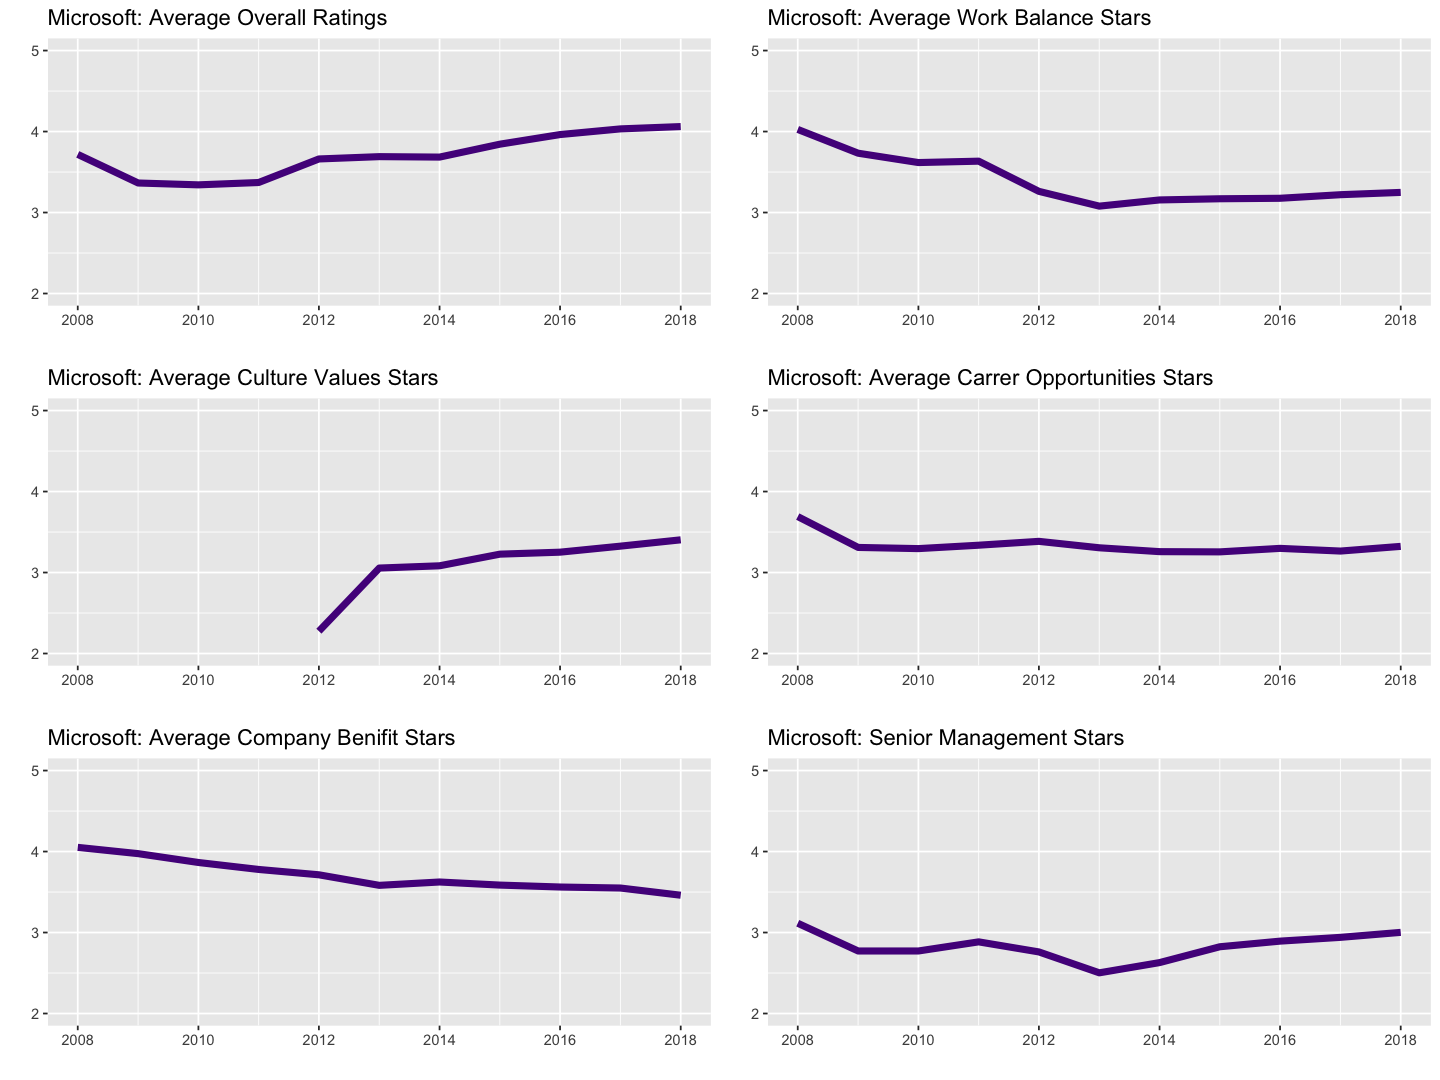

In [153]:
#MS: Average Overall Ratings

p69 <- df_ms %>%
  select(dates,overall.ratings) %>%
  filter(as.Date(dates) < as.Date("2019-12-31")) %>% #to remove outliers "9999-01-01"
  group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(average =mean(overall.ratings)) %>%
  ggplot(aes(x = year, y = average))+geom_line(color = "purple4", size = 2)+labs(x="",y="",title ="Microsoft: Average Overall Ratings" )+
  scale_y_continuous(limits=c(2, 5))


#MS: Average Work Balance Stars
p70 <- df_ms %>%
  select(dates,work.balance.stars) %>%
  filter(as.Date(dates) < as.Date("2019-12-31")) %>%
  group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(average=mean(work.balance.stars)) %>%
  ggplot(aes(x = year, y = average))+geom_line(color = "purple4", size = 2)+labs(x="",y="",title ="Microsoft: Average Work Balance Stars" )+
  scale_y_continuous(limits=c(2, 5))



#MS: Average Culture Values Stars
p71<-df_ms %>%
  select(dates,culture.values.stars) %>%
  filter(as.Date(dates) < as.Date("2019-12-31")) %>%
  group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(average=mean(culture.values.stars)) %>%
  ggplot(aes(x = year, y = average))+geom_line(color = "purple4", size = 2)+labs(x="",y="",title ="Microsoft: Average Culture Values Stars" )+
  scale_y_continuous(limits=c(2, 5))



#MS: Average Carrer Opportunities Stars
p72 <-df_ms %>%
  select(dates,carrer.opportunities.stars) %>%
  filter(as.Date(dates) < as.Date("2019-12-31")) %>%
  group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(average =mean(carrer.opportunities.stars)) %>%
  ggplot(aes(x = year, y = average))+geom_line(color = "purple4", size = 2)+labs(x="",y="",title ="Microsoft: Average Carrer Opportunities Stars" )+
  scale_y_continuous(limits=c(2, 5))


#MS: Average Company Benifit Stars
p73 <-df_ms %>%
  select(dates,comp.benefit.stars) %>%
  filter(as.Date(dates) < as.Date("2019-12-31")) %>%
  group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(average =mean(comp.benefit.stars)) %>%
  ggplot(aes(x = year, y = average))+geom_line(color = "purple4", size = 2)+labs(x="",y="",title ="Microsoft: Average Company Benifit Stars" )+
  scale_y_continuous(limits=c(2, 5))


#MS: Senior Management Stars
p74 <-df_ms %>%
  select(dates,senior.mangemnet.stars) %>%
  filter(as.Date(dates) < as.Date("2019-12-31")) %>%
  group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(average =mean(senior.mangemnet.stars)) %>%
  ggplot(aes(x = year, y = average))+geom_line(color = "purple4", size = 2)+labs(x="",y="",title ="Microsoft: Senior Management Stars" )+
  scale_y_continuous(limits=c(2, 5))


grid.arrange(p69, p70, p71, p72, p73, p74, ncol = 2)

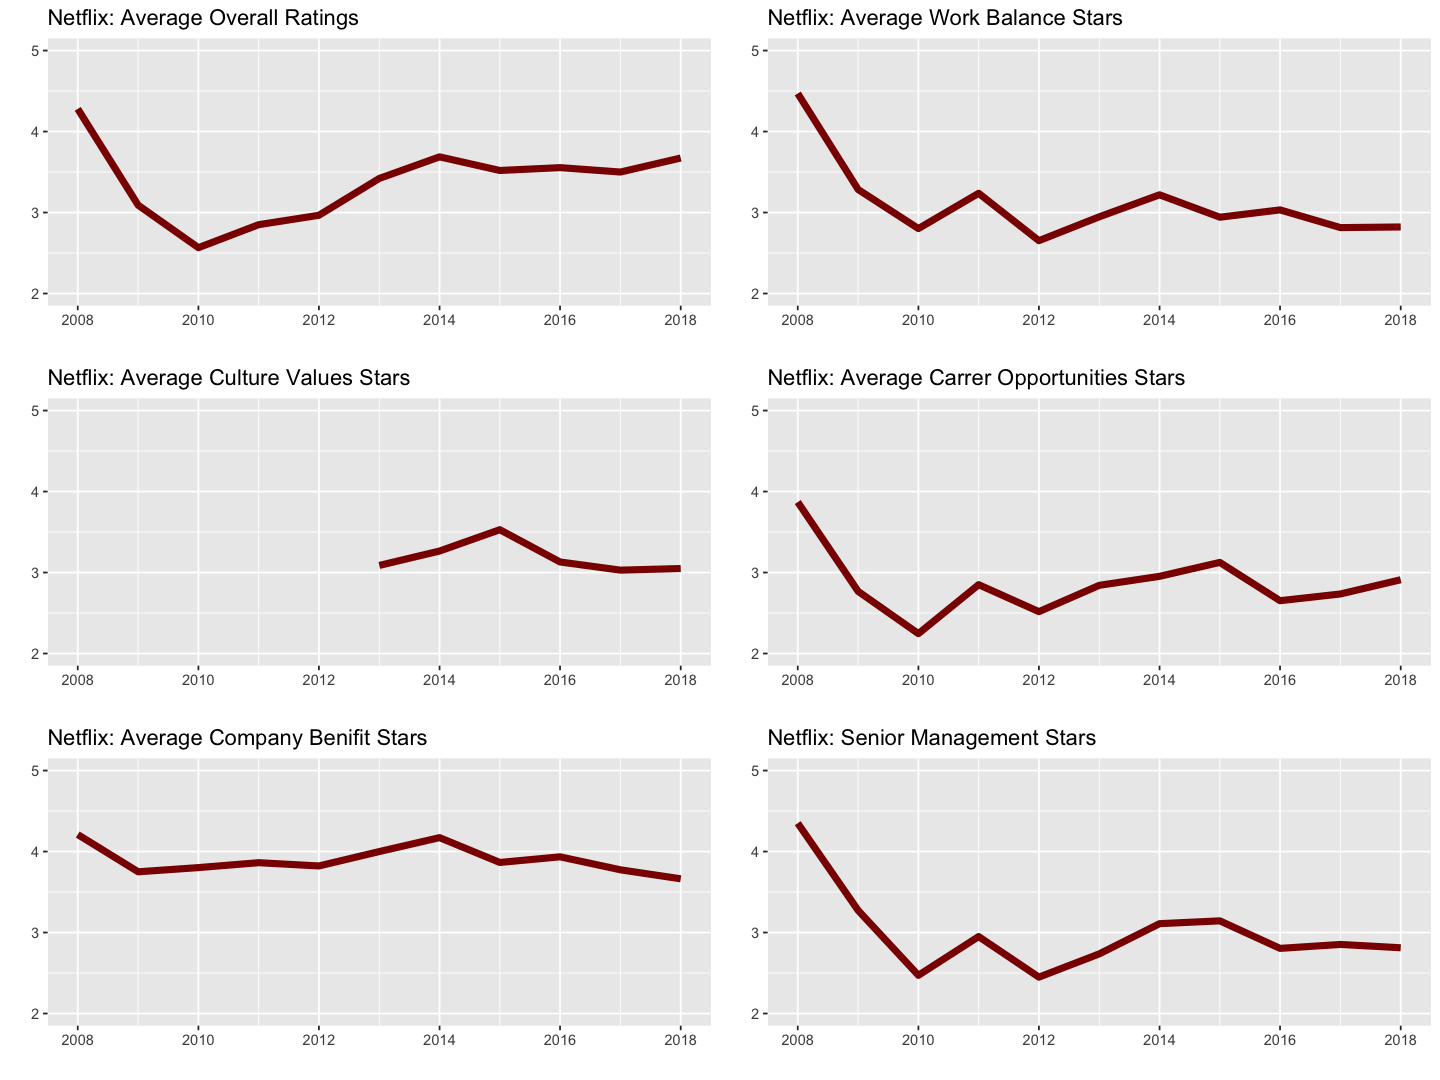

In [154]:
#NF: Average Overall Ratings

p75 <- df_nf %>%
  select(dates,overall.ratings) %>%
  filter(as.Date(dates) < as.Date("2019-12-31")) %>% #to remove outliers "9999-01-01"
  group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(average =mean(overall.ratings)) %>%
  ggplot(aes(x = year, y = average))+geom_line(color = "red4", size = 2)+labs(x="",y="",title ="Netflix: Average Overall Ratings" )+
  scale_y_continuous(limits=c(2, 5))

#NF: Average Work Balance Stars
p76 <- df_nf %>%
  select(dates,work.balance.stars) %>%
  filter(as.Date(dates) < as.Date("2019-12-31")) %>%
  group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(average=mean(work.balance.stars)) %>%
  ggplot(aes(x = year, y = average))+geom_line(color = "red4", size = 2)+labs(x="",y="",title ="Netflix: Average Work Balance Stars" )+
  scale_y_continuous(limits=c(2, 5))


#NF: Average Culture Values Stars
p77<-df_nf %>%
  select(dates,culture.values.stars) %>%
  filter(as.Date(dates) < as.Date("2019-12-31")) %>%
  group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(average=mean(culture.values.stars)) %>%
  ggplot(aes(x = year, y = average))+geom_line(color = "red4", size = 2)+labs(x="",y="",title ="Netflix: Average Culture Values Stars" )+
  scale_y_continuous(limits=c(2, 5))


#NF: Average Carrer Opportunities Stars
p78 <-df_nf %>%
  select(dates,carrer.opportunities.stars) %>%
  filter(as.Date(dates) < as.Date("2019-12-31")) %>%
  group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(average =mean(carrer.opportunities.stars)) %>%
  ggplot(aes(x = year, y = average))+geom_line(color = "red4", size = 2)+labs(x="",y="",title ="Netflix: Average Carrer Opportunities Stars" )+
  scale_y_continuous(limits=c(2, 5))

#NF: Average Company Benifit Stars
p79 <-df_nf %>%
  select(dates,comp.benefit.stars) %>%
  filter(as.Date(dates) < as.Date("2019-12-31")) %>%
  group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(average =mean(comp.benefit.stars)) %>%
  ggplot(aes(x = year, y = average))+geom_line(color = "red4", size = 2)+labs(x="",y="",title ="Netflix: Average Company Benifit Stars" )+
  scale_y_continuous(limits=c(2, 5))

#NF: Senior Management Stars
p80 <-df_nf %>%
  select(dates,senior.mangemnet.stars) %>%
  filter(as.Date(dates) < as.Date("2019-12-31")) %>%
  group_by(year=floor_date(as.Date(dates), "year")) %>%
  summarise(average =mean(senior.mangemnet.stars)) %>%
  ggplot(aes(x = year, y = average))+geom_line(color = "red4", size = 2)+labs(x="",y="",title ="Netflix: Senior Management Stars" )+
  scale_y_continuous(limits=c(2, 5))

grid.arrange(p75, p76, p77,p78, p79, p80, ncol = 2)

- Google: the trends of all variables were on stable except for culture values stars.
- Apple, Facebook and Netflix all share very fluctuant trend over years
- Microsoft’s company benefit stars have decreased over the decade with great fluctuation
- Netflix performs the poorest especially in overall ratings and senior management stars
- Cultures values is a new concept brough in to Glassdoor ratings in 2013, showing a new trend of employees' focus

**compare overall ratings over time by company**

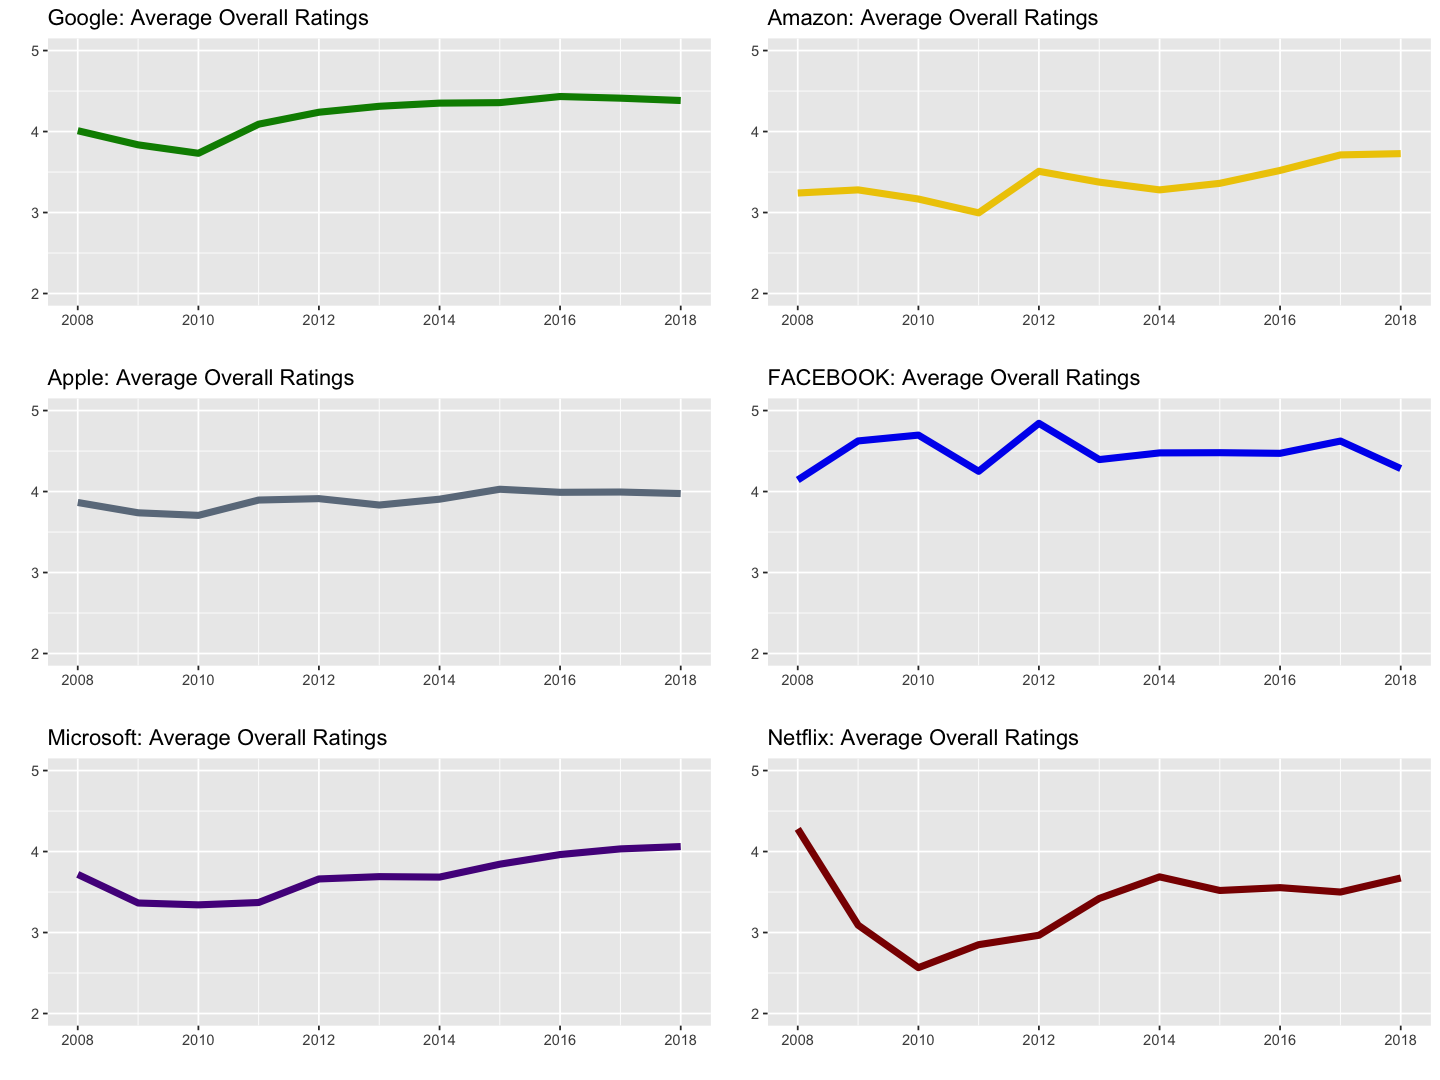

In [155]:
#compare overall ratings over time by company
grid.arrange(p45, p51, p57,p63, p69, p75, ncol = 2)

These firms are making an improvement to raise the satisfaction of employees. Specifically, Google, Amazon, Apple, and Microsoft are making stronger effort comparing to Facebook and Netflix. 

Facebook is the only company whose overall ratings drop in the recent year.


## Part 5: Predictive Analysis with Text

We will use combined text from *pros* and *cons* to predict *overall.ratings* in this part. 

**create a corpus**

In [116]:
df$text <- paste(df$pros , df$cons)

In [117]:
library(tm)
corpus = Corpus(VectorSource(df$text))

#### Clean text
- convert to lower case
- remove punctuation
- remove stopwords
- remove whitespace
- steam document

In [118]:
corpus = tm_map(corpus,FUN = content_transformer(tolower))
corpus = tm_map(corpus,FUN = removePunctuation)
corpus = tm_map(corpus,FUN = removeWords,c(stopwords('english')))
corpus = tm_map(corpus,FUN = stripWhitespace)
corpus = tm_map(corpus,FUN = stemDocument)

**create a dictionary of all words when group together end-chopped words that are similar**

In [119]:
dict = findFreqTerms(DocumentTermMatrix(Corpus(VectorSource(df$text))),lowfreq = 0)
dict_corpus = Corpus(VectorSource(dict))

**document term matrix - tfidf**

In [123]:
#create a document term matrix using tfidf
dtm_tfidf = DocumentTermMatrix(x=corpus,control = list(weighting=function(x) weightTfIdf(x,normalize=F)))

#remove sparse terms, only retain terms that appear in 3% or more text
xdtm_tfidf = removeSparseTerms(dtm_tfidf,sparse = 0.97)

#complete stem
xdtm_tfidf = as.data.frame(as.matrix(xdtm_tfidf))
colnames(xdtm_tfidf) = stemCompletion(x = colnames(xdtm_tfidf),dictionary = dict_corpus,type='prevalent')
colnames(xdtm_tfidf) = make.names(colnames(xdtm_tfidf))
sort(colSums(xdtm_tfidf),decreasing = T)                                                      

work    managable     compania        peopl        great         good 
    52424.93     51701.43     50169.58     48780.60     47536.38     47362.27 
         get          can         time          lot         will         team 
    46286.69     43446.69     41604.53     40629.27     39505.07     38912.96 
     employe      benefit          job         hour          pay       amazon 
    37645.97     36443.04     34269.94     33223.15     33005.24     31645.40 
   opportune         like         make      environ       cultur          day 
    31574.48     31415.73     31132.83     30462.75     30308.81     28920.03 
       mania      product  realligning        learn      balance        place 
    28734.97     28245.97     27965.91     27843.28     27520.40     27513.31 
        year       custom          one         much         hard        thing 
    26660.85     26567.97     25982.61     25756.29     25238.26     25205.80 
     applaud         life         dont         high          new        smart 
    25152.39     25073.11     24888.11     24433.25     23971.84     23449.48 
        best       career       change         need    microsoft         long 
    23116.24     23045.36     22861.16     22740.40     22601.31     22487.97 
        move         just         take      project   experiance       growth 
    21869.38     21474.52     21261.50     20527.60     20449.58     20298.69 
      promot         also         even         want        alway    salariale 
    20290.32     20271.23     20262.06     20096.31     20061.49     19992.84 
        well     politcal      develop       busier     sometime       expect 
    19810.17     19668.21     19482.03     19242.67     19051.48     18924.10 
      retail    challenge   everithing        level          big     flexible 
    18740.81     18703.23     18639.51     18638.50     18527.61     18449.68 
   positieve         your      process     amazaing         feel         hire 
    18287.70     18282.84     18265.13     18260.04     18219.02     18179.30 
       train   technologa       differ         help       intern          way 
    18124.04     17741.55     17735.31     17716.70     17507.20     17232.76 
      person         care         fast          bad          use         perk 
    16983.29     16801.47     16760.13     16606.97     16593.61     16572.93 
       think         nice         know         grow   leadership         free 
    16548.42     16537.50     16487.60     16406.86     16267.18     16249.47 
compensable.       google     worklife        shift       better  competities 
    16224.03     16184.97     16140.78     16128.78     15990.14     15759.62 
     support          fun      perform       engine       around         come 
    15751.84     15749.20     15678.24     15652.17     15614.33     15609.56 
   everyonce     schedule         week       review     interest         role 
    15588.13     15508.22     15474.28     15442.78     15402.98     15379.86 
      little       friend       office        focus        still    innovante 
    15349.83     15345.17     15320.65     15215.45     15095.37     14817.29 
      cowork        stock         part        start       easier    difficult 
    14785.24     14712.81     14581.64     14483.35     14372.42     14271.53 
         con         food         lack        group         find       system 
    14175.96     14119.06     13870.60     13852.06     13834.67     13746.63 
      within        excel        never         meet        large        world 
    13608.85     13551.02     13548.47     13336.47     13314.14     13299.62 
        look      problem        triad      advance         pace       impact 
    13212.25     13209.18     13089.40     13065.22     13007.74     12815.95 
         say         love       talent        leave         less         poor 
    12785.95     12777.59     12758.60     12729.83     12662.61     12565.24 
    constant        often         home      nothign       

### Create Dataset for Building Model

In [124]:
data_tfidf = cbind(overall_rating = df$overall.ratings,xdtm_tfidf)

In [125]:
head(data_tfidf)

overall_rating friend   peopl     smart    thing     also      area     
1 5              4.331123  1.678674 3.360006  3.547115  0.000000  0.000000
2 4              0.000000 10.072047 3.360006  0.000000  4.086118  5.005673
3 5              0.000000  8.393372 0.000000 14.188459  8.172235  0.000000
4 5              0.000000 13.429396 6.720011 21.282689  0.000000  0.000000
5 5              0.000000 31.894815 3.360006 28.376918 20.430588 15.017018
6 5              0.000000  3.357349 0.000000  0.000000  0.000000  0.000000
  balance   benefit  career    ⋯ large salariale cowork talent schedule retail
1  0.000000 0.000000  0.000000 ⋯ 0     0         0      0      0        0     
2  5.725067 1.931269  3.562429 ⋯ 0     0         0      0      0        0     
3  5.725067 0.000000  0.000000 ⋯ 0     0         0      0      0        0     
4  5.725067 0.000000  3.562429 ⋯ 0     0         0      0      0        0     
5 11.450134 1.931269 10.687288 ⋯ 0     0         0      0      0        0     
6  0.000000 0.000000  0.000000 ⋯ 0     0         0      0      0        0     
  fast pace home shift
1 0    0    0    0    
2 0    0    0    0    
3 0    0    0    0    
4 0    0    0    0    
5 0    0    0    0    
6 0    0    0    0

### Split Data

In [126]:
set.seed(617)
split = sample(1:nrow(data_tfidf),size = 0.7*nrow(data_tfidf))
train = data_tfidf[split,]
test = data_tfidf[-split,]

### Predictive Models

**cart**

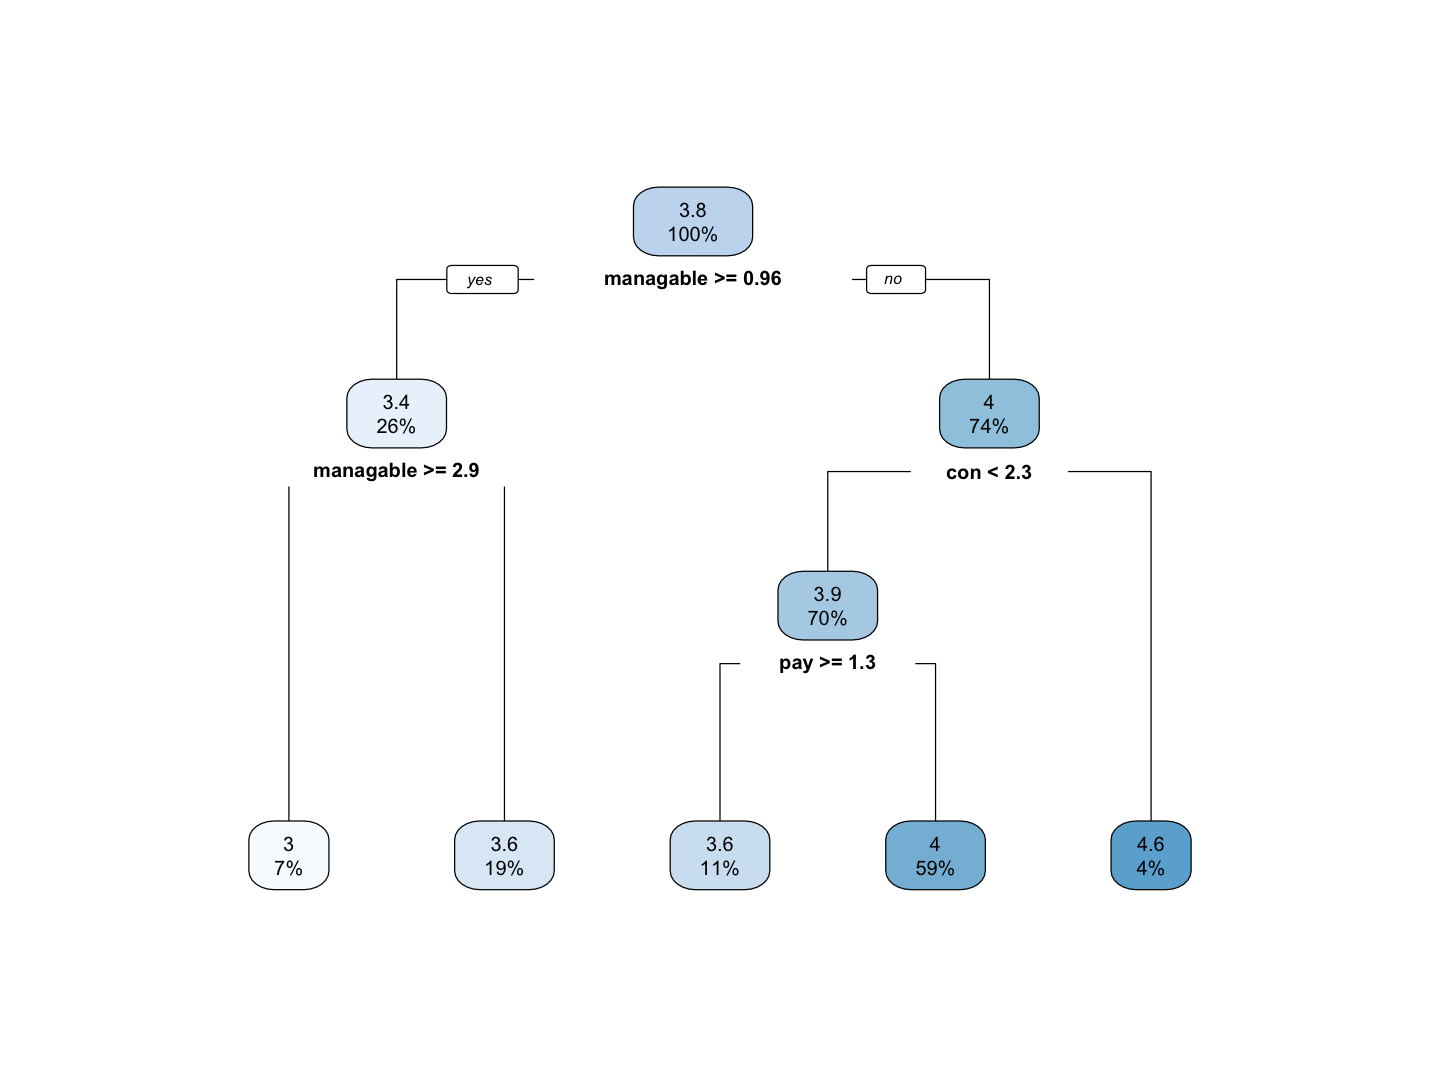

In [127]:
library(rpart); library(rpart.plot)
tree = rpart(overall_rating~.,train)
rpart.plot(tree)

**cart predictions**

In [129]:
pred_tree = predict(tree,newdata=test)
rmse_tree = sqrt(mean((pred_tree - test$overall_rating)^2))
rmse_tree

[1] 1.102888

**regression**

In [130]:
reg = lm(overall_rating~.,train)
summary(reg)


Call:
lm(formula = overall_rating ~ ., data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.9253 -0.6302  0.1405  0.8033  6.6082 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   3.8264917  0.0086545 442.138  < 2e-16 ***
friend        0.0242344  0.0046677   5.192 2.09e-07 ***
peopl        -0.0276265  0.0044064  -6.270 3.65e-10 ***
smart         0.0117193  0.0047048   2.491 0.012745 *  
thing         0.0102605  0.0038800   2.644 0.008184 ** 
also          0.0117653  0.0039087   3.010 0.002613 ** 
area          0.0086227  0.0045526   1.894 0.058231 .  
balance       0.0362810  0.0085697   4.234 2.30e-05 ***
benefit      -0.0329360  0.0053405  -6.167 7.01e-10 ***
career        0.0025497  0.0042550   0.599 0.549036    
change        0.0049519  0.0039438   1.256 0.209264    
come          0.0128255  0.0044571   2.878 0.004009 ** 
compania      0.0114517  0.0038577   2.969 0.002994 ** 
compensable.  0.0042827  0.0045547   0.940 0.347075  

In [131]:
pred_reg = predict(reg, newdata=test)
rmse_reg = sqrt(mean((pred_reg-test$overall_rating)^2))
rmse_reg

[1] 1.027684

**Model built using linear regression has outperformed the regression tree model.**